# Análise da comparação contexto e as palavras das sentenças do FaQuAD 

Realiza a análise da comparação das palavras das sentenças dos documentos originais e perturbados com o contexto dos dados do FaQuAD utilizando o arquivo:

- `comparacao_contexto_pX_kY.zip`

No nome do arquivo `comparacao_palavra_pX_kY.zip`, X é o número de documentos perturbados e Y o valor de top K predições. 




# 1 Preparação do ambiente

Preparação do ambiente para execução do script.

## 1.1 Tempo inicial de processamento

In [ ]:
# Import das bibliotecas.
import time
import datetime

# Marca o tempo de início do processamento
inicio_processamento = time.time()

## 1.2 Funções e classes auxiliares

Verifica se existe o diretório cohebert no diretório corrente.   


In [ ]:
# Import das bibliotecas.
import os # Biblioteca para manipular arquivos

# ============================  
def verificaDiretorioCoheBERT():
    """
      Verifica se existe o diretório cohebert no diretório corrente.    
    """
    
    # Verifica se o diretório existe
    if not os.path.exists(DIRETORIO_COHEBERT):  
        # Cria o diretório
        os.makedirs(DIRETORIO_COHEBERT)
        logging.info("Diretório Cohebert criado: {}".format(DIRETORIO_COHEBERT))
    
    return DIRETORIO_COHEBERT

Realiza o download e um arquivo

In [ ]:
# Import das bibliotecas.
import requests # Biblioteca de download
from tqdm.notebook import tqdm as tqdm_notebook # Biblioteca para barra de progresso
import os # Biblioteca para manipular arquivos

def downloadArquivo(url_arquivo, nome_arquivo_destino):
    """    
      Realiza o download de um arquivo de uma url em salva em nome_arquivo_destino.
    
      Parâmetros:
        `url_arquivo` - URL do arquivo a ser feito download.      
        `nome_arquivo_destino` - Nome do arquivo a ser salvo.      
    """
    
    # Verifica se existe o diretório base
    DIRETORIO_COHEBERT = verificaDiretorioCoheBERT()
    
    # Realiza o download de um arquivo em uma url
    data = requests.get(url_arquivo, stream=True)
    
    # Verifica se o arquivo existe
    if data.status_code != 200:
        logging.info("Exceção ao tentar realizar download {}. Response {}.".format(url_arquivo, data.status_code))
        data.raise_for_status()
        return

    # Recupera o nome do arquivo a ser realizado o download    
    nome_arquivo = nome_arquivo_destino.split("/")[-1]  

    # Define o nome e caminho do arquivo temporário    
    nome_arquivo_temporario = DIRETORIO_COHEBERT + "/" + nome_arquivo + "_part"
    
    logging.info("Download do arquivo: {}.".format(nome_arquivo_destino))
    
    # Baixa o arquivo
    with open(nome_arquivo_temporario, "wb") as arquivo_binario:        
        tamanho_conteudo = data.headers.get("Content-Length")        
        total = int(tamanho_conteudo) if tamanho_conteudo is not None else None
        # Barra de progresso de download
        progresso_bar = tqdm_notebook(unit="B", total=total, unit_scale=True)                
        # Atualiza a barra de progresso
        for chunk in data.iter_content(chunk_size=1024):        
            if chunk:                
                progresso_bar.update(len(chunk))
                arquivo_binario.write(chunk)
    
    # Renomeia o arquivo temporário para o arquivo definitivo
    os.rename(nome_arquivo_temporario, nome_arquivo_destino)
    
    # Fecha a barra de progresso.
    progresso_bar.close()

Remove tags de um documento

In [ ]:
def remove_tags(documento):
    """
      Remove tags de um documento
    """
    
    import re

    documento_limpo = re.compile("<.*?>")
    return re.sub(documento_limpo, "", documento)

Funções auxiliares de arquivos

In [ ]:
def carregar(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como um único parágrafo(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.  
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    paragrafo = ""
    for linha in arquivo:
        linha = linha.splitlines()
        linha = " ".join(linha)
        # Remove as tags existentes no final das linhas
        linha = remove_tags(linha)
        if linha != "":
          paragrafo = paragrafo + linha.strip() + " "
    
    # Fecha o arquivo
    arquivo.close()

    # Remove os espaços em branco antes e depois do parágrafo
    return paragrafo.strip()

In [ ]:
def carregarLista(nome_arquivo, encoding="Windows-1252"):
    """
      Carrega um arquivo texto e retorna as linhas como uma lista de sentenças(texto).
    
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser carregado.   
        `encoding` - Codificação dos caracteres do arquivo.
    """

    # Abre o arquivo
    arquivo = open(nome_arquivo, "r", encoding= encoding)
    
    sentencas = []
    for linha in arquivo:        
        linha = linha.splitlines()
        linha = " ".join(linha)
        linha = remove_tags(linha)
        if linha != "":
          sentencas.append(linha.strip())
    
    # Fecha o arquivo
    arquivo.close()

    return sentencas 

In [ ]:
def salvar(nome_arquivo,texto):                       
    """
      Salva um texto em um arquivo.
     
      Parâmetros:
        `nome_arquivo` - Nome do arquivo a ser salvo.
        `texto` - Texto a ser salvo.     
    """

    arquivo = open(nome_arquivo, "w")
    arquivo.write(str(texto))
    arquivo.close()

Função auxiliar para formatar o tempo como `hh: mm: ss`

In [ ]:
# Import das bibliotecas.
import time
import datetime

def formataTempo(tempo):
    """
      Pega a tempo em segundos e retorna uma string hh:mm:ss
    """
    # Arredonda para o segundo mais próximo.
    tempoArredondado = int(round((tempo)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=tempoArredondado))    

Classe(ModelArguments) de definição dos parâmetros do modelo

In [ ]:
# Import das bibliotecas.
from dataclasses import dataclass, field
from typing import Dict, Optional
from typing import List

@dataclass
class ModeloArgumentosMedida:
    max_seq_len: Optional[int] = field(
        default=None,
        metadata={"help": "max seq len"},
    )    
    pretrained_model_name_or_path: str = field(
        default="neuralmind/bert-base-portuguese-cased",
        metadata={"help": "nome do modelo pré-treinado do BERT."},
    )
    modelo_spacy: str = field(
        default="pt_core_news_lg",
        metadata={"help": "nome do modelo do spaCy."},
    )
    versao_modelo_spacy: str = field(
        default="-3.2.0",
        metadata={"help": "versão do nome do modelo no spaCy."},
    )
    sentenciar_documento: bool = field(
        default=True,
        metadata={"help": "Dividir o documento em sentenças(frases)."},
    )
    do_lower_case: bool = field(
        default=False,
        metadata={"help": "define se o texto do modelo deve ser todo em minúsculo."},
    )    
    output_attentions: bool = field(
        default=False,
        metadata={"help": "habilita se o modelo retorna os pesos de atenção."},
    )
    output_hidden_states: bool = field(
        default=False,
        metadata={"help": "habilita gerar as camadas ocultas do modelo."},
    )
    usar_mcl_ajustado : bool = field(
        default=False,
        metadata={"help": "habilita o carragamento de mcl ajustado."},
    )
    documentos_perturbados: int = field(
        default="1",
        metadata={"help": "Quantidade de documentos a serem perturbados a partir do original."},
    )
    top_k_predicao: int = field(
        default="100",
        metadata={"help": "Quantidade de palavras a serem recuperadas mais próximas da máscara."},
    ) 

Biblioteca de limpeza de tela


In [ ]:
# Import das bibliotecas.
from IPython.display import clear_output

## 1.3 Tratamento de logs

In [ ]:
# Import das bibliotecas.
import logging # Biblioteca de logging

# Formatando a mensagem de logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s")

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## 1.4 Identificando o ambiente Colab

In [ ]:
# Import das bibliotecas.
import sys # Biblioteca para acessar módulos do sistema

# Se estiver executando no Google Colaboratory
# Retorna true ou false se estiver no Google Colaboratory
IN_COLAB = "google.colab" in sys.modules

## 1.5 Colaboratory

Usando Colab GPU para Treinamento


Uma GPU pode ser adicionada acessando o menu e selecionando:

`Edit -> Notebook Settings -> Hardware accelerator -> (GPU)`

Em seguida, execute a célula a seguir para confirmar que a GPU foi detectada.

In [ ]:
# Import das bibliotecas.
import tensorflow as tf

# Recupera o nome do dispositido da GPU.
device_name = tf.test.gpu_device_name()

# O nome do dispositivo deve ser parecido com o seguinte:
if device_name == "/device:GPU:0":
    logging.info("Encontrei GPU em: {}".format(device_name))
else:
    logging.info("Dispositivo GPU não encontrado")
    #raise SystemError("Dispositivo GPU não encontrado")

2022-07-12 00:57:08,356 : INFO : NumExpr defaulting to 2 threads.
2022-07-12 00:57:08,864 : INFO : Dispositivo GPU não encontrado


Nome da GPU

Para que a torch use a GPU, precisamos identificar e especificar a GPU como o dispositivo. Posteriormente, em nosso ciclo de treinamento, carregaremos dados no dispositivo.

Vale a pena observar qual GPU você recebeu. A GPU Tesla P100 é muito mais rápido que as outras GPUs, abaixo uma lista ordenada:
- 1o Tesla P100
- 2o Tesla T4
- 3o Tesla P4 (Não tem memória para execução 4 x 8, somente 2 x 4)
- 4o Tesla K80 (Não tem memória para execução 4 x 8, somente 2 x 4)

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def getDeviceGPU():
    """
    Retorna um dispositivo de GPU se disponível ou CPU.
    
    Retorno:
    `device` - Um device de GPU ou CPU.       
    """
        
    # Se existe GPU disponível.
    if torch.cuda.is_available():
        
        # Diz ao PyTorch para usar GPU.    
        device = torch.device("cuda")
        
        logging.info("Existem {} GPU(s) disponíveis.".format(torch.cuda.device_count()))
        logging.info("Iremos usar a GPU: {}.".format(torch.cuda.get_device_name(0)))

    # Se não.
    else:        
        logging.info("Sem GPU disponível, usando CPU.")
        device = torch.device("cpu")
        
    return device

In [ ]:
device = getDeviceGPU()

2022-07-12 00:57:12,419 : INFO : Sem GPU disponível, usando CPU.


Conecta o modelo ao device

In [ ]:
# Import das bibliotecas.
import torch # Biblioteca para manipular os tensores

def conectaGPU(model, device):
    """
      Conecta um modelo BERT a GPU.

      Parâmetros:
        `model` - Um modelo BERT carregado.       
        `device` - Um device de GPU.     
    
      Retorno:
        `model` - Um objeto model BERT conectado a GPU.     
    """
    # Associa a GPU ao modelo.
    model.to(device)

    # Se existe GPU disponível.
    if torch.cuda.is_available():    
        # Diga ao pytorch para rodar este modelo na GPU.
        logging.info("Pytorch rodando o modelo na GPU.")
        model.cuda()
        
    else:
        logging.info("Pytorch rodando sem GPU.")

    return model

Memória

Memória disponível no ambiente

In [ ]:
# Import das bibliotecas.
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
logging.info("Seu ambiente de execução tem {: .1f} gigabytes de RAM disponível\n".format(ram_gb))

if ram_gb < 20:
  logging.info("Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> \"Alterar tipo de tempo de execução\"")
  logging.info("e selecione High-RAM. Então, execute novamente está célula")
else:
  logging.info("Você está usando um ambiente de execução de memória RAM alta!")

2022-07-12 00:57:12,488 : INFO : Seu ambiente de execução tem  13.6 gigabytes de RAM disponível

2022-07-12 00:57:12,493 : INFO : Para habilitar um tempo de execução de RAM alta, selecione menu o ambiente de execução> "Alterar tipo de tempo de execução"
2022-07-12 00:57:12,495 : INFO : e selecione High-RAM. Então, execute novamente está célula


## 1.6 Monta uma pasta no google drive para carregar os arquivos de dados.

In [ ]:
# Import das bibliotecas.
from google.colab import drive

# Monta o drive na pasta especificada
drive.mount("/content/drive")     

Mounted at /content/drive


## 1.7 Instalação do wandb

Instalação

In [ ]:
!pip install --upgrade wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 12.9 MB/s 
     |████████████████████████████████| 146 kB 48.9 MB/s 
     |████████████████████████████████| 181 kB 46.4 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=2a7d0c92803ee8ca7820cdb1e452a8d2d49c363c68084a97b453c373a326cf33
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


# 2 Parametrização

## Gerais

In [ ]:
# Definição dos parâmetros a serem avaliados
#Quantidade de documentos a serem perturbados a partir do original.
DOCUMENTOS_PERTURBADOS = 20

#Quantidade de palavras a serem recuperadas mais próximas da máscara.
TOP_K_PREDICAO = 20

## Específicos

Parâmetros do modelo

In [ ]:
# Definição dos parâmetros do Modelo.
model_args = ModeloArgumentosMedida(     
    max_seq_len = 512,    
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-large-portuguese-cased/bert-large-portuguese-cased_pytorch_checkpoint.zip",
    #pretrained_model_name_or_path = "https://neuralmind-ai.s3.us-east-2.amazonaws.com/nlp/bert-base-portuguese-cased/bert-base-portuguese-cased_pytorch_checkpoint.zip",
    pretrained_model_name_or_path = "neuralmind/bert-large-portuguese-cased",
    #pretrained_model_name_or_path = "neuralmind/bert-base-portuguese-cased",    
    #pretrained_model_name_or_path = "bert-base-multilingual-cased",
    #pretrained_model_name_or_path = "bert-base-multilingual-uncased",
    modelo_spacy = "pt_core_news_lg",
    #modelo_spacy = "pt_core_news_md",
    #modelo_spacy = "pt_core_news_sm",
    versao_modelo_spacy = "3.2.0",
    sentenciar_documento = False,
    do_lower_case = False, # default True  
    output_attentions = False, # default False
    output_hidden_states = True, # default False, se True retorna todas as camadas do modelo para as operações de soma e concatenação
    usar_mcl_ajustado = False, # Especifica se deve ser carregado um MCL ajustado ou pré-treinado. Necessário especificar o tipo do modelo em pretrained_model_name_or_path. 
    documentos_perturbados = DOCUMENTOS_PERTURBADOS, # Quantidade de documentos a serem perturbados a partir do original.
    top_k_predicao = TOP_K_PREDICAO, # Conjunto de valores: 1, 10, 100, 500 e 1000. Quantidade de palavras a serem recuperadas mais próximas da máscara.
)

## Nome do diretório dos arquivos de dados

In [ ]:
# Diretório do SQuAD
DIRETORIO_COHEBERT = "FAQUAD"

## Define o caminho para os arquivos de dados

In [ ]:
# Diretório local para os arquivos pré-processados
DIRETORIO_LOCAL = "/content/" + DIRETORIO_COHEBERT + "/"

# Diretório no google drive com os arquivos pré-processados
DIRETORIO_DRIVE = "/content/drive/MyDrive/Colab Notebooks/Data/" + DIRETORIO_COHEBERT + "/"

## Configuração do tamanho da fonte dos gráficos

In [ ]:
# Import das bibliotecas.
import matplotlib

TAMANHO_FONTE = 16
matplotlib.rc("font", size=TAMANHO_FONTE)          # Controla o tamanho do do texto default
matplotlib.rc("axes", titlesize=TAMANHO_FONTE)     # Tamanho da fonte do eixo do título
matplotlib.rc("axes", labelsize=TAMANHO_FONTE)     # Tamanho da fonte dos rótulos do eixo x e y
matplotlib.rc("xtick", labelsize=TAMANHO_FONTE-2)    # Tamanho da fonte das marcações do eixo y
matplotlib.rc("ytick", labelsize=TAMANHO_FONTE)    # Tamanho da fonte dos marcações do eixo x
matplotlib.rc("legend", fontsize=TAMANHO_FONTE-2)  # Tamanho da fonte da legenda
matplotlib.rc("figure", titlesize=TAMANHO_FONTE)   # Tamanho da fonte do título da figura

# 3 Estatísticas comparação do contexto com as palavras



## 3.1 Carregamento dos arquivos de dados originais

### 3.1.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_ORIGINAL = "original.csv"
NOME_ARQUIVO_ORIGINAL_COMPACTADO = "original.zip"
NOME_ARQUIVO_ORIGINAL_POS = "originalpos.csv"
NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO = "originalpos.zip"

NOME_ARQUIVO_PERTURBADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_COMPACTADO = "perturbado_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"
NOME_ARQUIVO_PERTURBADO_POS = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO = "perturbadopos_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.1.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-12 01:02:36,140 : INFO : Diretório criado: /content/FAQUAD


### 3.1.3 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_COMPACTADO" "$DIRETORIO_LOCAL"
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" "$DIRETORIO_LOCAL"

  logging.info("Terminei a cópia!")

2022-07-12 01:02:37,604 : INFO : Terminei a cópia!


Descompacta os arquivos.

Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_ORIGINAL_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"
  
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_COMPACTADO" -d "$DIRETORIO_LOCAL"
  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_PERTURBADO_POS_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Terminei a descompactação!")

2022-07-12 01:02:38,137 : INFO : Terminei a descompactação!


### 3.1.4 Carregamento das lista com os dados dos arquivos originais

#### Carrega o arquivo dos dados originais e POS

In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_documentos_originais = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL, sep=";", encoding="UTF-8")
lista_documentos_originais_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_ORIGINAL_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-12 01:02:38,179 : INFO : TERMINADO ORIGINAIS: 900.
2022-07-12 01:02:38,180 : INFO : TERMINADO ORIGINAIS POS: 900.


In [ ]:
lista_documentos_originais.sample(5)

id  \
43   b4bf6ca3ed294ec6ad5410f1071031a9   
134  ef1bc02f6bef4ae992b8a2fa9dbe1257   
744  df2911c85c8141c2b5ccd67c184b9678   
64   1be0a494427f4910982679b5a66b0c88   
49   0d9152126eb14923a0110320e0868290   

                                             sentencas  \
43   ['Como o aluno pode adquirir conhecimento sem ...   
134  ['Quantos bytes em sequência geralmente são ut...   
744                                   ['O que é CSU?']   
64   ['Quantas regras Pānini utilizou para formular...   
49   ['Por que aprender diversas metodologias, sist...   

                                             documento  
43   Como o aluno pode adquirir conhecimento sem o ...  
134  Quantos bytes em sequência geralmente são util...  
744                                       O que é CSU?  
64   Quantas regras Pānini utilizou para formular a...  
49   Por que aprender diversas metodologias, sistem...

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais = lista_documentos_originais.astype(tipos)

In [ ]:
lista_documentos_originais_pos.sample(5)

id  \
664  fa802e95d73d451f9cb2518acdfcf482   
801  2fa0aec8272e47b7b46d2e0e067c8875   
229  790c5a7ad3dc444bbcd4760a29889728   
848  c8ca5537da2349dcbbaa9fd361adb3d7   
651  105dd9b6709b4b4996af1dfe667b1692   

                                         pos_documento  
664  [[['Quais', 'disciplinas', 'não', 'são', 'apro...  
801  [[['Quem', 'tutela', 'as', 'universidades', 'p...  
229  [[['Ao', 'que', 'o', 'curso', 'de', 'Mestrado'...  
848  [[['o', 'que', 'o', 'acadêmico', 'pode', 'soli...  
651  [[['Para', 'que', 'o', 'dia', 'letivo', 'deve'...

In [ ]:
# Corrige os tipos dos dados da lista agrupada
tipos = {"id": str}

lista_documentos_originais_pos = lista_documentos_originais_pos.astype(tipos)

#### Corrigir os tipos de colunas dos dados originais e POS

Em dados originais:
- coluna 1 - `sentenças` carregadas do arquivo vem como string e não como lista.

Em dados originais pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_originais["sentencas"] = lista_documentos_originais["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_originais_pos["pos_documento"] = lista_documentos_originais_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO ORIGINAIS: {}.".format(len(lista_documentos_originais)))
logging.info("TERMINADO CORREÇÃO ORIGINAIS POS: {}.".format(len(lista_documentos_originais_pos)))

2022-07-12 01:02:38,365 : INFO : TERMINADO CORREÇÃO ORIGINAIS: 900.
2022-07-12 01:02:38,367 : INFO : TERMINADO CORREÇÃO ORIGINAIS POS: 900.


#### Criando dados indexados originais

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_indexado = lista_documentos_originais.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_indexado.head()

sentencas  \
id                                                                                    
4918ff59e83343b88c1fd3a204f55a3b  [Como pode ser definido um sistema de informaç...   
fb885a2f0a624520a6586476563715e8      [O que as soluções tecnológicas automatizam?]   
a8d728463e2f4fe792c6c756e0fd14a4  [Por que a preocupação com a coleta, armazenam...   
927902205b9f494881848f7fc065c347  [Qual um componente indispensável nas organiza...   
ee17827309224fa8acfb23a05e2fa853  [Em que se concentram as responsabilidades do ...   

                                                                          documento  
id                                                                                   
4918ff59e83343b88c1fd3a204f55a3b   Como pode ser definido um sistema de informação?  
fb885a2f0a624520a6586476563715e8        O que as soluções tecnológicas automatizam?  
a8d728463e2f4fe792c6c756e0fd14a4  Por que a preocupação com a coleta, armazename...  
927902205b9f494881848f7fc065c347  Qual um componente indispensável nas organizaç...  
ee17827309224fa8acfb23a05e2fa853  Em que se concentram as responsabilidades do a...

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_originais_pos_indexado = lista_documentos_originais_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_originais_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_originais_pos_indexado.head()

pos_documento
id                                                                                 
4918ff59e83343b88c1fd3a204f55a3b  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8  [[[O, que, as, soluções, tecnológicas, automat...
a8d728463e2f4fe792c6c756e0fd14a4  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347  [[[Qual, um, componente, indispensável, nas, o...
ee17827309224fa8acfb23a05e2fa853  [[[Em, que, se, concentram, as, responsabilida...

#### Carrega o arquivo dos dados perturbados e POS

In [ ]:
# Abre o arquivo e retorna o DataFrame
lista_documentos_perturbados = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO, sep=";", encoding="UTF-8")
lista_documentos_perturbados_pos = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_PERTURBADO_POS, sep=";", encoding="UTF-8")

logging.info("TERMINADO PERTURBADOS: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO PERTURBADOS POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-12 01:02:38,665 : INFO : TERMINADO PERTURBADOS: 18000.
2022-07-12 01:02:38,671 : INFO : TERMINADO PERTURBADOS POS: 18000.


In [ ]:
lista_documentos_perturbados.sample(5)

id  \
10395  4069d145f3c84f7f8dfe1a217153520c_pert_15   
1247    e27536d0558f486692fbf13d1bfd9347_pert_7   
2365    b6cd60a93a0e47b387289b8c2accaa27_pert_5   
6770   0eae90cf569546bfa0c97ceb60bad6bc_pert_10   
17562   c2bb4a1d5ea044b2a336034ef26a8c59_pert_2   

                                              perturbado  \
10395  ['Como a computação irá ser definida formalmen...   
1247        ['Qual era o uso original do instrumento ?']   
2365   ['Quais informações deveriam ser representadas...   
6770                 ['Quando a FAPDF foi organizada ?']   
17562  ['quais são as atividades para o regime de tra...   

                                     documentoPerturbado  \
10395   Como a computação irá ser definida formalmente ?   
1247            Qual era o uso original do instrumento ?   
2365   Quais informações deveriam ser representadas p...   
6770                     Quando a FAPDF foi organizada ?   
17562  quais são as atividades para o regime de traba...   

                                               sentencas  
10395  [['Como a computação [MASK] ser definida forma...  
1247   [['Qual era o uso original do [MASK] ?', 'ábac...  
2365   [['Quais informações [MASK] ser representadas ...  
6770   [['Quando a FAPDF foi [MASK] ?', 'implementada...  
17562  [['quais são as atividades para o regime de [M...

In [ ]:
lista_documentos_perturbados_pos.sample(5)

id  \
15734  86703f3d233341669ac8d2bde1bd2b1f_pert_14   
12053  b82ae73f31f4463690ee784902d45094_pert_13   
6828    c8181e1b42f14634acd34608dd257d85_pert_8   
5218   f9d286c7172d48228f2dec0ba7ba6cc5_pert_18   
11527   1567f487837a46728d0830c6fb8ff3a5_pert_7   

                                           pos_documento  
15734  [[['Onde', 'se', 'concentra', 'a', 'CBC', '?']...  
12053  [[['Onde', 'devem', 'ser', 'dadas', 'as', 'not...  
6828   [[['Qual', 'a', 'finalidade', 'da', 'música', ...  
5218   [[['Como', 'você', 'o', 'curso', 'de', 'Engenh...  
11527  [[['Como', 'são', 'designados', 'os', 'profess...

#### Corrigir os tipos de colunas dos dados perturbados e POS

Em dados perturbados:
- coluna 1 - `perturbado` carregadas do arquivo vem como string e não como lista.
- coluna 3 - `sentencas` carregadas do arquivo vem como string e não como lista.

Em dados perturbados pos:
- coluna 1 - `pos_documento` carregadas do arquivo vem como string e não como lista.

In [ ]:
# Import das bibliotecas.
import ast # Biblioteca para conversão de string em lista

# Verifica se o tipo da coluna não é list e converte
lista_documentos_perturbados["perturbado"] = lista_documentos_perturbados["perturbado"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)
lista_documentos_perturbados["sentencas"] = lista_documentos_perturbados["sentencas"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

lista_documentos_perturbados_pos["pos_documento"] = lista_documentos_perturbados_pos["pos_documento"].apply(lambda x: ast.literal_eval(x) if type(x)!=list else x)

logging.info("TERMINADO CORREÇÃO PERTURBADO: {}.".format(len(lista_documentos_perturbados)))
logging.info("TERMINADO CORREÇÃO PERTURBADO POS: {}.".format(len(lista_documentos_perturbados_pos)))

2022-07-12 01:02:41,036 : INFO : TERMINADO CORREÇÃO PERTURBADO: 18000.
2022-07-12 01:02:41,038 : INFO : TERMINADO CORREÇÃO PERTURBADO POS: 18000.


#### Criando dados indexados perturbados

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_indexado = lista_documentos_perturbados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_indexado.head()

perturbado  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [Como deve ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [Como poderia ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [Como deveria ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [Como poderá ser definido um sistema de inform...   

                                                                       documentoPerturbado  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b_pert_0  Como pode ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  Como deve ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  Como poderia ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  Como deveria ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_4  Como poderá ser definido um sistema de informa...   

                                                                                 sentencas  
id                                                                                          
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [[Como [MASK] ser definido um sistema de infor...  
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [[Como [MASK] ser definido um sistema de infor...

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_perturbados_pos_indexado = lista_documentos_perturbados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_perturbados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_perturbados_pos_indexado.head()

pos_documento
id                                                                                        
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [[[Como, pode, ser, definido, um, sistema, de,...
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [[[Como, deve, ser, definido, um, sistema, de,...
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [[[Como, poderia, ser, definido, um, sistema, ...
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [[[Como, deveria, ser, definido, um, sistema, ...
4918ff59e83343b88c1fd3a204f55a3b_pert_4  [[[Como, poderá, ser, definido, um, sistema, d...

### 3.1.5 Agrupar os dados originais e perturbados

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook

def agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados):
  print("Processando",len(lista_documentos_originais),"documentos originais")

  lista_documentos_agrupados = []

  # Barra de progresso dos documentos
  lista_documentos_originais_bar = tqdm_notebook(lista_documentos_originais.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_originais))

  # Percorre os documentos
  for i, linha_documento in lista_documentos_originais_bar: 
    #if i < 2:
      #print("linha_documento:",linha_documento)
      # Recupera o id do documento
      id_documento = linha_documento[0]     
      #print("id_documento:",id_documento)     
  
      # Carrega a lista das sentenças do documento
      lista_sentenca_documento = linha_documento[1]    
      #print("\nlista_sentenca_documento:",lista_sentenca_documento)
      #print("len(lista_sentenca_documento):",len(lista_sentenca_documento)) 

      # Adiciona o original a lista dos dados agrupados, considerando como coerente(1)
      lista_documentos_agrupados.append([id_documento, lista_sentenca_documento, linha_documento[2], 1])

      # Percorre os documentos perturbados apartir do original
      for j in range(0, model_args.documentos_perturbados):

        # Id do documento perturbado
        id_perturbado = str(id_documento) + "_pert_" + str(j)

        # localiza o documento perturbado de acordo com o tipo armazenado        
        # Os conjuntos de dados possuem diferentes formas de armazendo        
        documento_perturbado = lista_documentos_perturbados_indexado.loc[id_perturbado]
        # Recupera a sentença do documento perturbado
        lista_perturbado = documento_perturbado[0]
                      
        # Adiciona o perturbado a lista dos dados agrupados considerando como incoerente(0)
        lista_documentos_agrupados.append([id_perturbado, lista_perturbado, documento_perturbado[1], 0])    

  logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

  # Cria o dataframe da lista
  lista_documentos_agrupados = pd.DataFrame(lista_documentos_agrupados, columns = ["id","sentencas","documento","classe"])

  # Corrige os tipos dos dados da lista agrupada
  tipos = {"id": str, "sentencas": object, "documento": str, "classe": int}

  lista_documentos_agrupados = lista_documentos_agrupados.astype(tipos)

  return lista_documentos_agrupados

In [ ]:
# Importa das bibliotecas
import pandas as pd

print("Analisando documentos originais e perturbados")
# Concatena as listas de documentos originais e perturbados
lista_documentos_agrupados = agruparDadosOriginaisPerturbados(lista_documentos_originais, lista_documentos_perturbados)
lista_documentos_agrupados_pos = pd.concat([lista_documentos_originais_pos, lista_documentos_perturbados_pos])
# Corrige o tipo de dado da coluna id da lista
tipos = {"id": str}
lista_documentos_agrupados_pos = lista_documentos_agrupados_pos.astype(tipos)

Analisando documentos originais e perturbados
Processando 900 documentos originais


Documentos:   0%|          | 0/900 [00:00<?, ? documento/s]

2022-07-12 01:02:42,854 : INFO : TERMINADO AGRUPAMENTO: 18900.


In [ ]:
logging.info("TERMINADO AGRUPAMENTO: {}.".format(len(lista_documentos_agrupados)))

2022-07-12 01:02:42,898 : INFO : TERMINADO AGRUPAMENTO: 18900.


In [ ]:
lista_documentos_agrupados.sample(5)

id  \
6164   3374ef6ff5a34150bb3e6e5e8ff7e9b8_pert_10   
15964   ade01302fbdb4e5cba6388531069f86b_pert_3   
12632  9f3db258b4f4402cb4f4dc104deafa7a_pert_10   
1062   7a0674456eca4078808881042e48ac90_pert_11   
9716   7c874ed1b46243b99ac012346cdccd78_pert_13   

                                               sentencas  \
6164   [Como é definida a área de otimização matemáti...   
15964  [Quem é responsável por testar e desenvolver n...   
12632  [O que o professor deve apresentar ao acadêmic...   
1062   [Em que as atividades complementares atingem o...   
9716         [Qual o objetivo da coleta bibliográfica ?]   

                                               documento  classe  
6164   Como é definida a área de otimização matemátic...       0  
15964  Quem é responsável por testar e desenvolver no...       0  
12632   O que o professor deve apresentar ao acadêmico ?       0  
1062   Em que as atividades complementares atingem o ...       0  
9716           Qual o objetivo da coleta bibliográfica ?       0

In [ ]:
logging.info("TERMINADO AGRUPAMENTO POS: {}.".format(len(lista_documentos_agrupados_pos)))

2022-07-12 01:02:42,952 : INFO : TERMINADO AGRUPAMENTO POS: 18900.


In [ ]:
lista_documentos_agrupados_pos.sample(5)

id  \
6667    a1bf5db1a6fa4ffdaecbb0f53f65bc5c_pert_7   
14974  7c6c4a5666c94361a78682c507d864ab_pert_14   
3603    0eb400da4b774b6d9eb90c7469535a5a_pert_3   
4675   319e0bb3c1294bc9ba0040b79397f0c9_pert_15   
1364    56b4eba75fdf48af9900529219a9b180_pert_4   

                                           pos_documento  
6667   [[[Para, quem, o, professor, costuma, entregar...  
14974  [[[Como, ficaram, conhecidas, a, série, de, in...  
3603   [[[Em, que, foi, inspirado, o, Mark, I, ?], [A...  
4675   [[[Dentro, de, qual, escola, foi, colocado, o,...  
1364   [[[Como, é, conhecido, Alan, Turing, ?], [ADV,...

#### Criar dados indexados

In [ ]:
lista_documentos_agrupados_indexado = lista_documentos_agrupados.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_indexado.head()

sentencas  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b         [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_0  [Como pode ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  [Como deve ser definido um sistema de informaç...   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  [Como poderia ser definido um sistema de infor...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  [Como deveria ser definido um sistema de infor...   

                                                                                 documento  \
id                                                                                           
4918ff59e83343b88c1fd3a204f55a3b          Como pode ser definido um sistema de informação?   
4918ff59e83343b88c1fd3a204f55a3b_pert_0  Como pode ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_1  Como deve ser definido um sistema de informação ?   
4918ff59e83343b88c1fd3a204f55a3b_pert_2  Como poderia ser definido um sistema de inform...   
4918ff59e83343b88c1fd3a204f55a3b_pert_3  Como deveria ser definido um sistema de inform...   

                                         classe  
id                                               
4918ff59e83343b88c1fd3a204f55a3b              1  
4918ff59e83343b88c1fd3a204f55a3b_pert_0       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_1       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_2       0  
4918ff59e83343b88c1fd3a204f55a3b_pert_3       0

In [ ]:
# Faz uma cópia da lista não indexada
lista_documentos_agrupados_pos_indexado = lista_documentos_agrupados_pos.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_documentos_agrupados_pos_indexado.set_index(["id"], inplace=True)
lista_documentos_agrupados_pos_indexado.head()

pos_documento
id                                                                                 
4918ff59e83343b88c1fd3a204f55a3b  [[[Como, pode, ser, definido, um, sistema, de,...
fb885a2f0a624520a6586476563715e8  [[[O, que, as, soluções, tecnológicas, automat...
a8d728463e2f4fe792c6c756e0fd14a4  [[[Por, que, a, preocupação, com, a, coleta, ,...
927902205b9f494881848f7fc065c347  [[[Qual, um, componente, indispensável, nas, o...
ee17827309224fa8acfb23a05e2fa853  [[[Em, que, se, concentram, as, responsabilida...

## 3.2 Carregamento do arquivo de dado comparação palavra e contexto

### 3.2.1 Especifica os nomes dos arquivos de dados



In [ ]:
# Nome do arquivo
NOME_ARQUIVO_COMPARACAO_CONTEXTO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".csv"
NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO = "comparacao_contexto_p" + str(model_args.documentos_perturbados) + "_k" + str(model_args.top_k_predicao) + ".zip"

### 3.2.2 Cria o diretório local para receber os dados

In [ ]:
# Import das bibliotecas.
import os

# Cria o diretório para receber os arquivos Originais e Permutados
# Diretório a ser criado
dirbase = DIRETORIO_LOCAL[:-1]

if not os.path.exists(dirbase):  
    # Cria o diretório
    os.makedirs(dirbase)    
    logging.info("Diretório criado: {}".format(dirbase))
else:    
    logging.info("Diretório já existe: {}".format(dirbase))

2022-07-12 01:02:43,090 : INFO : Diretório já existe: /content/FAQUAD


### 3.2.2 Copia e descompacta os arquivos do Google Drive para o Colaboratory

In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  # Copia o arquivo de comparações do google drive para a diretório local
  !cp "$DIRETORIO_DRIVE$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO"
  
  logging.info("Terminei a cópia!")

2022-07-12 01:02:43,741 : INFO : Terminei a cópia!


Usa o unzip para descompactar:
*   `-o` sobrescreve o arquivo se existir
*   `-j` Não cria nenhum diretório
*   `-q` Desliga as mensagens 
*   `-d` Diretório de destino


In [ ]:
# Se estiver executando no Google Colaboratory
if IN_COLAB:

  !unzip -o -j -q "$DIRETORIO_LOCAL$NOME_ARQUIVO_COMPARACAO_CONTEXTO_COMPACTADO" -d "$DIRETORIO_LOCAL"

  logging.info("Descompactação realizada!")

2022-07-12 01:02:45,014 : INFO : Descompactação realizada!


### 3.2.4 Carregamento das lista com os dados do arquivo


In [ ]:
#Biblioteca
import pandas as pd

# Abre o arquivo e retorna o DataFrame
lista_comparacao_contexto = pd.read_csv(DIRETORIO_LOCAL + NOME_ARQUIVO_COMPARACAO_CONTEXTO, sep=";", encoding="UTF-8")

logging.info("TERMINADO ORIGINAIS: {}.".format(len(lista_comparacao_contexto))) 

2022-07-12 01:02:46,721 : INFO : TERMINADO ORIGINAIS: 204582.


In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  \
194988   bb7dc667337b4cf2af309d60a1f1ecb2_pert_8            17964   
111591   81efd71e897945349cd21e542e948e95_pert_7            10571   
13551   a41abb00c3fc4b2984c234804b4f544d_pert_17             1215   
58323    d1dad06a3dab422ab6d183262d1632bc_pert_2             5673   
130062  1567f487837a46728d0830c6fb8ff3a5_pert_11            12108   

        index_sentenca  index_wi            wi pos_i  cos_ctxall_mean  \
194988               0         3  distribuidas  VERB         0.801578   
111591               0        11          cada   DET         0.831154   
13551                0         6       aguarda  VERB         0.795971   
58323                0         0          Qual  PRON         0.841558   
130062               0         0          Como   ADV         0.822700   

        euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  ...  \
194988        21.996264        1072.0188           0.788566  ...   
111591        21.743824        1075.4827           0.738703  ...   
13551         32.498478        1371.9858           0.851228  ...   
58323         20.882921        1021.9514           0.778966  ...   
130062        21.827414        1080.4154           0.751136  ...   

        man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  \
194988         1397.8595         0.750416        26.879446      1318.769287   
111591         1316.8536         0.736508        27.816088      1362.885254   
13551          1232.7368         1.000000         0.000000         0.000000   
58323          1191.7195         0.801036        23.425835      1154.082520   
130062         1256.8683         0.738348        27.374586      1342.828979   

        cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  \
194988         0.542913        36.391720      1758.800781   
111591         0.719203        27.448921      1361.767578   
13551          0.630429        40.027721      1678.424438   
58323          0.681735        29.069456      1412.270752   
130062         0.626939        31.836514      1565.919922   

        cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
194988             0.726549            27.927845          1369.696167  
111591             0.766888            25.224100          1253.554077  
13551              0.830561            30.020790          1258.818359  
58323              0.785893            24.005512          1183.763916  
130062             0.742322            26.163336          1293.243774  

[5 rows x 36 columns]

Remove as pontuações

In [ ]:
#lista_comparacao_contexto = lista_comparacao_contexto.query('pos_i != "PUNCT"')

In [ ]:
lista_comparacao_contexto.sample(5)

id  index_documento  \
53369    cd8c4b3dcb7548679cb113d84689bf7c_pert_1             5231   
171175  130643c20b5e4d58b0a0cd118bdd61fa_pert_10            15656   
112136   24d6facb6c9444e095df6ca47d7cc8ce_pert_2            10629   
158521  a276eac35a5f4e738c0d34da56cbed05_pert_10            14522   
97928   4ac2a64c1af245c5b712fd7078d25628_pert_15             9193   

        index_sentenca  index_wi              wi  pos_i  cos_ctxall_mean  \
53369                0         1               o    DET         0.857012   
171175               0         0            Para  SCONJ         0.763673   
112136               0         8       resultado   NOUN         0.794756   
158521               0         8  complementares    ADJ         0.841370   
97928                0         2               o    DET         0.861222   

        euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  ...  \
53369         20.193842        995.58655           0.784112  ...   
171175        25.684790       1271.61340           0.678827  ...   
112136        23.624655       1167.39590           0.865137  ...   
158521        22.239676       1046.34610           0.896919  ...   
97928         19.372799        955.61127           0.802058  ...   

        man_ctxclean_max  cos_ctxverb_max  euc_ctxverb_max  man_ctxverb_max  \
53369         1170.92750         0.711028        28.966135      1431.906006   
171175        1480.12040         0.568967        37.164883      1835.064453   
112136         970.96985         0.576213        36.462406      1804.964966   
158521         865.55210              NaN              NaN              NaN   
97928         1109.05310         0.727652        28.966131      1403.032593   

        cos_ctxnoun_max  euc_ctxnoun_max  man_ctxnoun_max  \
53369          0.694466        28.218191      1372.995850   
171175         0.541220        36.907291      1815.275513   
112136         0.892531        17.605951       863.401367   
158521         0.791967        25.336241      1184.881470   
97928          0.721089        27.106901      1283.204468   

        cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
53369              0.764146            24.842775          1216.147461  
171175             0.611672            33.265579          1651.033203  
112136             0.852466            20.336765           999.953308  
158521             0.791967            25.336241          1184.881470  
97928              0.770245            24.747665          1194.124756  

[5 rows x 36 columns]

### 3.2.5 Criando dados indexados

In [ ]:
# Faz uma cópia da lista não indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.copy()

# Expecifica o(s) campo(s) indexado(s)
lista_comparacao_contexto_indexado.set_index(["id", "index_sentenca", "index_wi", "pos_i"], inplace=True)
lista_comparacao_contexto_indexado.head()

index_documento  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV                  0   
                                                1        VERB                 0   
                                                2        AUX                  0   
                                                3        VERB                 0   
                                                4        DET                  0   

                                                                      wi  \
id                               index_sentenca index_wi pos_i             
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV        Como   
                                                1        VERB       pode   
                                                2        AUX         ser   
                                                3        VERB   definido   
                                                4        DET          um   

                                                                cos_ctxall_mean  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV           0.853577   
                                                1        VERB          0.843366   
                                                2        AUX           0.842175   
                                                3        VERB          0.822999   
                                                4        DET           0.890127   

                                                                euc_ctxall_mean  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV          19.730730   
                                                1        VERB         20.869614   
                                                2        AUX          21.132103   
                                                3        VERB         23.358629   
                                                4        DET          16.717981   

                                                                man_ctxall_mean  \
id                               index_sentenca index_wi pos_i                    
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV          958.74950   
                                                1        VERB         984.97650   
                                                2        AUX         1042.47640   
                                                3        VERB        1126.17190   
                                                4        DET          830.50824   

                                                                cos_ctxclean_mean  \
id                               index_sentenca index_wi pos_i                      
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV             0.793780   
                                                1        VERB            0.762653   
                                                2        AUX             0.758202   
                                                3        VERB            0.872648   
                                                4        DET             0.800822   

                                                                euc_ctxclean_mean  \
id                               index_sentenca index_wi pos_i                      
4918ff59e83343b88c1fd3a204f55a3b 0              0        ADV            23.196814   
                                                1        VERB           25.310417   
                                                2        AUX            25.717234   
                                                3        VERB           20.237915   
                                                4        DET            22.226166   

           

## 3.3 Estatísticas

### Colunas medidas discrepantes

In [ ]:
coluna_discrepancia_cos = "min"
coluna_discrepancia_euc = "max"
coluna_discrepancia_man = "max"

### Contexto com todas as palavras(ctxall)

#### Estatísticas das medidas do contexto de todas palavras e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxall_mean", 
                           "euc_ctxall_mean", 
                           "man_ctxall_mean", 
                           "cos_ctxall_max", 
                           "euc_ctxall_max",  
                           "man_ctxall_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
count   204582.000000   204582.000000   204582.000000  204582.000000   
mean         0.815145       22.560275     1087.476015       0.807407   
std          0.056515        3.691554      164.264300       0.058948   
min          0.064022       10.244466      494.070370       0.064022   
25%          0.788173       20.110536      979.457212       0.780039   
50%          0.819242       22.229189     1076.404600       0.812979   
75%          0.849261       24.572840     1183.582850       0.843672   
max          0.958278       45.165359     2096.301800       0.939079   

      euc_ctxall_max man_ctxall_max  
count  204582.000000  204582.000000  
mean       23.105530    1113.795966  
std         3.680610     163.619333  
min        12.695460     613.195560  
25%        20.604490    1003.803300  
50%        22.725211    1099.060250  
75%        25.147157    1207.204250  
max        45.165359    2379.885700

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxall_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxall_mean": [coluna_discrepancia_man],
                                                              "cos_ctxall_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxall_max": [coluna_discrepancia_euc], 
                                                              "man_ctxall_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_max  \
                  min             max             max            min   
count    18900.000000    18900.000000    18900.000000   18900.000000   
mean         0.748687       27.614823     1290.191284       0.733879   
std          0.105937        4.173739      163.306900       0.107110   
min          0.064022       15.736688      784.407000       0.064022   
25%          0.735635       24.745525     1178.027525       0.718656   
50%          0.766850       27.116618     1284.897150       0.754923   
75%          0.794504       29.979656     1394.238300       0.783852   
max          0.902758       45.165359     2096.301800       0.902758   

      euc_ctxall_max man_ctxall_max  
                 max            max  
count   18900.000000   18900.000000  
mean       28.052195    1317.172823  
std         4.200358     177.053789  
min        15.736688     784.407000  
25%        25.124694    1199.540100  
50%        27.557780    1304.978400  
75%        30.395903    1418.772075  
max        45.165359    2379.885700

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/18900 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 18890
2 de 11715
3 a 7628
4 que 7516
5 o 7358
6 O 4034
7 da 3600
8 do 3174
9 é 3156
10 Qual 2837
11 os 2382
12 para 2214
13 em 2025
14 as 1772
15 ser 1644
16 Quem 1407
17 no 1303
18 e 1300
19 foi 1294
20 curso 1218


### Contexto com palavras menos stopswords (ctxclean)

#### Estatísticas das medidas do contexto de todas palavras sen stopwords e as palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxclean_mean",   
                           "euc_ctxclean_mean", 
                           "man_ctxclean_mean",   
                           "cos_ctxclean_max", 
                           "euc_ctxclean_max",    
                           "man_ctxclean_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
count     204582.000000     204582.000000     204582.000000    204582.000000   
mean           0.792510         23.771699       1143.012059         0.784764   
std            0.066082          3.732203        178.765775         0.067518   
min            0.087471          0.000000          0.000000         0.087471   
25%            0.757907         21.317073       1021.765615         0.749419   
50%            0.797617         23.607586       1138.211600         0.789857   
75%            0.834491         25.980866       1255.043100         0.827579   
max            1.000000         48.854042       2107.836000         1.000000   

      euc_ctxclean_max man_ctxclean_max  
count    204582.000000    204582.000000  
mean         24.303469      1168.273160  
std           3.690113       176.133466  
min           0.000000         0.000000  
25%          21.871955      1051.082025  
50%          24.102805      1161.934700  
75%          26.455661      1274.991750  
max          48.854042      2416.819300

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxclean_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_mean": [coluna_discrepancia_man],
                                                              "cos_ctxclean_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxclean_max": [coluna_discrepancia_euc], 
                                                              "man_ctxclean_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxclean_mean euc_ctxclean_mean man_ctxclean_mean cos_ctxclean_max  \
                    min               max               max              min   
count      18900.000000      18900.000000      18900.000000     18900.000000   
mean           0.704057         28.683244       1373.042562         0.691929   
std            0.109461          3.699150        153.178003         0.109677   
min            0.087471         19.906242        952.471070         0.087471   
25%            0.687632         26.044689       1264.358425         0.675796   
50%            0.723302         28.113932       1357.326500         0.712086   
75%            0.755266         30.877357       1479.301775         0.744426   
max            0.847760         48.854042       2107.836000         0.846440   

      euc_ctxclean_max man_ctxclean_max  
                   max              max  
count     18900.000000     18900.000000  
mean         29.188239      1397.674096  
std           3.794453       165.480003  
min          19.906242       974.766700  
25%          26.441421      1280.376600  
50%          28.636741      1380.084100  
75%          31.262584      1497.710125  
max          48.854042      2416.819300

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento 
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1 

Documentos:   0%|          | 0/18900 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 18890
2 de 11715
3 a 7628
4 que 7516
5 o 7358
6 O 4034
7 da 3600
8 do 3174
9 é 3156
10 Qual 2837
11 os 2382
12 para 2214
13 em 2025
14 as 1772
15 ser 1644
16 Quem 1407
17 no 1303
18 e 1300
19 foi 1294
20 curso 1218


### Contexto com palavras da classe VERB(ctxverb)

#### Estatísticas das medidas do contexto de palavras da classe VERB e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverb_mean",  
                           "euc_ctxverb_mean", 
                           "man_ctxverb_mean",  
                           "cos_ctxverb_max", 
                           "euc_ctxverb_max",   
                           "man_ctxverb_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
count    186027.000000    186027.000000    186027.000000   186027.000000   
mean          0.708248        28.852819      1384.158980        0.701730   
std           0.123800         8.875884       415.965652        0.127221   
min           0.030959         0.000000         0.000000        0.030959   
25%           0.630071        26.017572      1269.327942        0.621840   
50%           0.693258        30.349098      1465.949585        0.689208   
75%           0.763323        34.149206      1635.011353        0.760732   
max           1.000000        59.446781      2420.440918        1.000000   

      euc_ctxverb_max man_ctxverb_max  
count   186027.000000   186027.000000  
mean        29.267317     1403.576047  
std          8.979408      420.254998  
min          0.000000        0.000000  
25%         26.255325     1281.534668  
50%         30.707333     1482.823975  
75%         34.664671     1657.299744  
max         60.412590     2643.242676

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverb_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverb_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverb_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverb_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max  \
                   min              max              max             min   
count     16853.000000     16853.000000     16853.000000    16853.000000   
mean          0.574698        35.957670      1700.265191        0.552600   
std           0.109916         4.618025       191.595475        0.109375   
min           0.030959        22.807224      1122.738647        0.030959   
25%           0.539961        32.715248      1567.929810        0.514904   
50%           0.589377        35.539597      1690.616943        0.565509   
75%           0.638103        38.771351      1828.148438        0.616840   
max           0.795651        59.446781      2420.440918        0.788203   

      euc_ctxverb_max man_ctxverb_max  
                  max             max  
count    16853.000000    16853.000000  
mean        36.943601     1744.021289  
std          4.631671      197.772091  
min         23.725010     1122.738647  
25%         33.775532     1610.320190  
50%         36.577358     1733.449951  
75%         39.750881     1866.121582  
max         60.412590     2643.242676

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]    

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/18900 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item]) 

1 ? 18890
2 de 11715
3 a 7628
4 que 7516
5 o 7358
6 O 4034
7 da 3600
8 do 3174
9 é 3156
10 Qual 2837
11 os 2382
12 para 2214
13 em 2025
14 as 1772
15 ser 1644
16 Quem 1407
17 no 1303
18 e 1300
19 foi 1294
20 curso 1218


### Contexto com palavras da classe NOUN(ctxnoun)

#### Estatísticas das medidas do contexto de palavras da classe NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxnoun_mean",  
                           "euc_ctxnoun_mean", 
                           "man_ctxnoun_mean",  
                           "cos_ctxnoun_max", 
                           "euc_ctxnoun_max",   
                           "man_ctxnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
count    196501.000000    196501.000000    196501.000000   196501.000000   
mean          0.732621        26.745067      1280.667327        0.725690   
std           0.108969         6.912576       331.909232        0.109167   
min           0.053923         0.000000         0.000000        0.053923   
25%           0.661976        23.622955      1128.510010        0.657057   
50%           0.721074        27.751289      1336.342285        0.715313   
75%           0.797423        31.047483      1494.890625        0.786123   
max           1.000000        53.475506      2549.481934        1.000000   

      euc_ctxnoun_max man_ctxnoun_max  
count   196501.000000   196501.000000  
mean        27.228973     1303.545000  
std          6.790102      325.758612  
min          0.000000        0.000000  
25%         24.246254     1163.281494  
50%         28.089037     1352.021606  
75%         31.351574     1509.122314  
max         53.475506     2571.148926

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max  \
                   min              max              max             min   
count     17708.000000     17708.000000     17708.000000    17708.000000   
mean          0.606835        34.099103      1617.234530        0.596799   
std           0.102761         4.070759       166.396247        0.104344   
min           0.053923        23.593864      1145.947998        0.053923   
25%           0.580556        31.316743      1506.254456        0.569809   
50%           0.625079        33.565784      1601.837646        0.617050   
75%           0.662831        36.367908      1720.612213        0.655385   
max           0.781867        53.475506      2549.481934        0.777541   

      euc_ctxnoun_max man_ctxnoun_max  
                  max             max  
count    17708.000000    17708.000000  
mean        34.539660     1638.389941  
std          4.203951      179.489351  
min         23.593864     1145.947998  
25%         31.640794     1518.303802  
50%         33.991404     1617.668274  
75%         36.903412     1743.492218  
max         53.475506     2571.148926

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]

    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1

Documentos:   0%|          | 0/18900 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 18890
2 de 11715
3 a 7628
4 que 7516
5 o 7358
6 O 4034
7 da 3600
8 do 3174
9 é 3156
10 Qual 2837
11 os 2382
12 para 2214
13 em 2025
14 as 1772
15 ser 1644
16 Quem 1407
17 no 1303
18 e 1300
19 foi 1294
20 curso 1218


### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### Estatísticas das medidas do contexto de palavras da classe VERB(AUX) e NOUN e as palavras

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_contexto[["cos_ctxverbnoun_mean",  
                           "euc_ctxverbnoun_mean", 
                           "man_ctxverbnoun_mean",  
                           "cos_ctxverbnoun_max", 
                           "euc_ctxverbnoun_max",   
                           "man_ctxverbnoun_max"]].describe(include=["float", "int"]).apply(lambda s: s.apply("{0:.6f}".format))

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
count        203903.000000        203903.000000        203903.000000   
mean              0.773931            24.771677          1189.817711   
std               0.083973             4.768270           228.556697   
min               0.046383             0.000000             0.000000   
25%               0.725198            21.818462          1042.043457   
50%               0.774519            24.943878          1205.260498   
75%               0.832056            27.581625          1334.114868   
max               1.000000            51.320911          2233.275146   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count       203903.000000       203903.000000       203903.000000  
mean             0.766661           25.251125         1212.424941  
std              0.087622            4.900783          234.051214  
min              0.046383            0.000000            0.000000  
25%              0.718662           22.325173         1068.439392  
50%              0.767653           25.348953         1225.459106  
75%              0.826206           27.993016         1351.825684  
max              1.000000           51.320911         2518.620850

#### Estatísticas das maiores discrepâncias por documento

In [ ]:
discrepancias  = lista_comparacao_contexto.groupby("id").agg({"cos_ctxverbnoun_mean": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_mean": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_mean": [coluna_discrepancia_man],
                                                              "cos_ctxverbnoun_max": [coluna_discrepancia_cos], 
                                                              "euc_ctxverbnoun_max": [coluna_discrepancia_euc], 
                                                              "man_ctxverbnoun_max": [coluna_discrepancia_man],
                                                              })

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
discrepancias.describe(include=["float", "int"]) 

cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean  \
                       min                  max                  max   
count         18782.000000         18782.000000         18782.000000   
mean              0.665814            30.503462          1456.502739   
std               0.109573             3.890663           155.884930   
min               0.046383            21.029814          1024.180176   
25%               0.650559            27.768737          1347.036804   
50%               0.688091            29.819444          1436.592651   
75%               0.719829            32.545652          1551.949707   
max               0.827053            51.320911          2233.275146   

      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
                      min                 max                 max  
count        18782.000000        18782.000000        18782.000000  
mean             0.648358           31.305698         1492.424192  
std              0.112834            4.189689          180.413644  
min              0.046383           21.376245         1024.180176  
25%              0.623799           28.307654         1364.818726  
50%              0.673785           30.553179         1466.093933  
75%              0.710856           33.658570         1594.316010  
max              0.827053           51.320911         2518.620850

#### Top 20 palavras com mais ocorrências das sentenças dos documentos

In [ ]:
# Import das bibliotecas.
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_documentos_pos_bar = tqdm_notebook(lista_documentos_agrupados_pos.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados_pos))

# Contador das palavras
contador = Counter()

# Percorre os documentos
for i, linha_documento_pos in lista_documentos_pos_bar:  
     
    # Carrega a lista das sentenças do documento
    lista_sentenca_documento = linha_documento_pos[1]
 
    # Percorre as sentenças pos do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
        #print(sentenca[0])       
        # Carrega a lista dos tokens das sentenças
        for k, palavra in enumerate(sentenca[0]):
            contador[palavra] += 1        

Documentos:   0%|          | 0/18900 [00:00<?, ? documento/s]

In [ ]:
top = 20
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    print (i+1, item, contador[item])     

1 ? 18890
2 de 11715
3 a 7628
4 que 7516
5 o 7358
6 O 4034
7 da 3600
8 do 3174
9 é 3156
10 Qual 2837
11 os 2382
12 para 2214
13 em 2025
14 as 1772
15 ser 1644
16 Quem 1407
17 no 1303
18 e 1300
19 foi 1294
20 curso 1218


## 3.4 Estatísticas das discrepâncias por classe moforsintática

### Contexto com todas as palavras(ctxall)

In [ ]:
equacao_medida = "ctxall"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   12118.000000 0.814524 0.044542 0.645625 0.783589 0.813661 0.845600   
ADP   33468.000000 0.816974 0.043518 0.555679 0.791160 0.821851 0.848005   
ADV    4469.000000 0.797936 0.044278 0.623675 0.774087 0.800576 0.827693   
AUX    9369.000000 0.848394 0.036711 0.666470 0.827352 0.851556 0.873305   
CCONJ  1429.000000 0.556618 0.291109 0.135299 0.229505 0.756765 0.820284   
DET   25591.000000 0.848697 0.037337 0.563480 0.828246 0.854970 0.874679   
INTJ     22.000000 0.832700 0.009345 0.808618 0.829472 0.835123 0.840748   
NOUN  47221.000000 0.800695 0.041982 0.599897 0.776271 0.802795 0.828058   
NUM     871.000000 0.779675 0.053779 0.630758 0.743399 0.776361 0.811644   
PRON  17144.000000 0.823668 0.041491 0.596403 0.799004 0.826131 0.852482   
PROPN  8535.000000 0.803962 0.060343 0.645470 0.762575 0.800810 0.845158   
PUNCT 19664.000000 0.826707 0.044985 0.064022 0.805753 0.830262 0.852552   
SCONJ  4485.000000 0.798768 0.040016 0.606042 0.775549 0.799473 0.824539   
VERB  20191.000000 0.801818 0.043271 0.539066 0.775151 0.802977 0.830286   
X         5.000000 0.795808 0.010207 0.783811 0.788006 0.795092 0.805371   

           max  
pos_i           
ADJ   0.931077  
ADP   0.935803  
ADV   0.921063  
AUX   0.939079  
CCONJ 0.916707  
DET   0.932928  
INTJ  0.842808  
NOUN  0.953742  
NUM   0.929892  
PRON  0.939928  
PROPN 0.955945  
PUNCT 0.925764  
SCONJ 0.901903  
VERB  0.958278  
X     0.806760

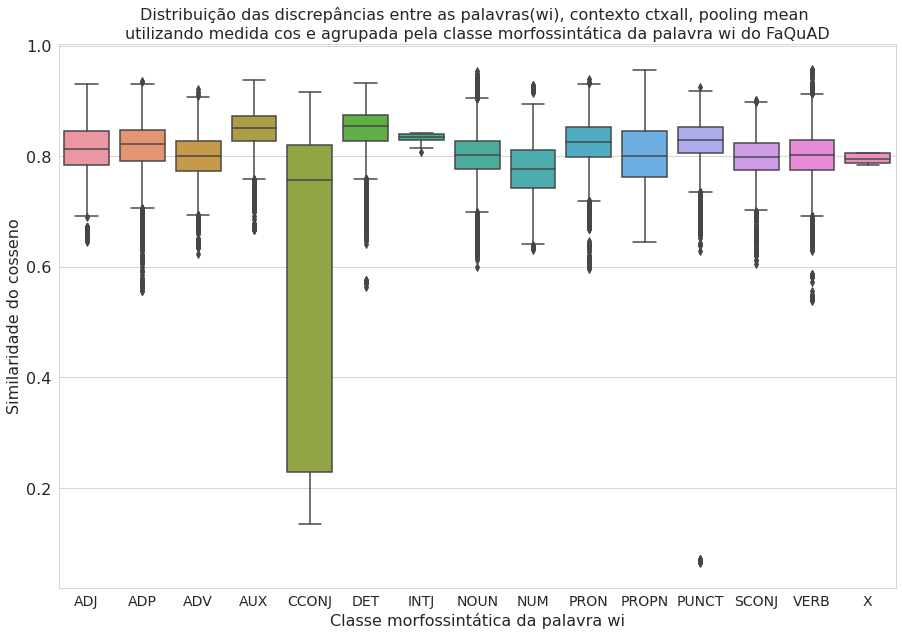

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   12118.000000 0.790118 0.044970 0.583831 0.766867 0.794482 0.820542   
ADP   33468.000000 0.816974 0.043518 0.555679 0.791160 0.821851 0.848005   
ADV    4469.000000 0.796262 0.043107 0.623675 0.772932 0.799114 0.825596   
AUX    9369.000000 0.848394 0.036711 0.666470 0.827352 0.851556 0.873305   
CCONJ  1429.000000 0.551825 0.291298 0.135299 0.229505 0.756765 0.820284   
DET   25591.000000 0.846041 0.038595 0.563480 0.824226 0.852481 0.873203   
INTJ     22.000000 0.832700 0.009345 0.808618 0.829472 0.835123 0.840748   
NOUN  47221.000000 0.789511 0.042649 0.580504 0.765321 0.794587 0.819386   
NUM     871.000000 0.747473 0.074989 0.484280 0.722337 0.758328 0.789101   
PRON  17144.000000 0.822653 0.041447 0.596403 0.797573 0.825150 0.851902   
PROPN  8535.000000 0.751864 0.050938 0.524530 0.717959 0.755079 0.788121   
PUNCT 19664.000000 0.826707 0.044985 0.064022 0.805753 0.830262 0.852552   
SCONJ  4485.000000 0.798768 0.040016 0.606042 0.775549 0.799473 0.824539   
VERB  20191.000000 0.792566 0.043516 0.539066 0.767856 0.795499 0.821356   
X         5.000000 0.795808 0.010207 0.783811 0.788006 0.795092 0.805371   

           max  
pos_i           
ADJ   0.912510  
ADP   0.935803  
ADV   0.900281  
AUX   0.939079  
CCONJ 0.916707  
DET   0.932928  
INTJ  0.842808  
NOUN  0.908355  
NUM   0.894028  
PRON  0.927783  
PROPN 0.913188  
PUNCT 0.925764  
SCONJ 0.901903  
VERB  0.909189  
X     0.806760

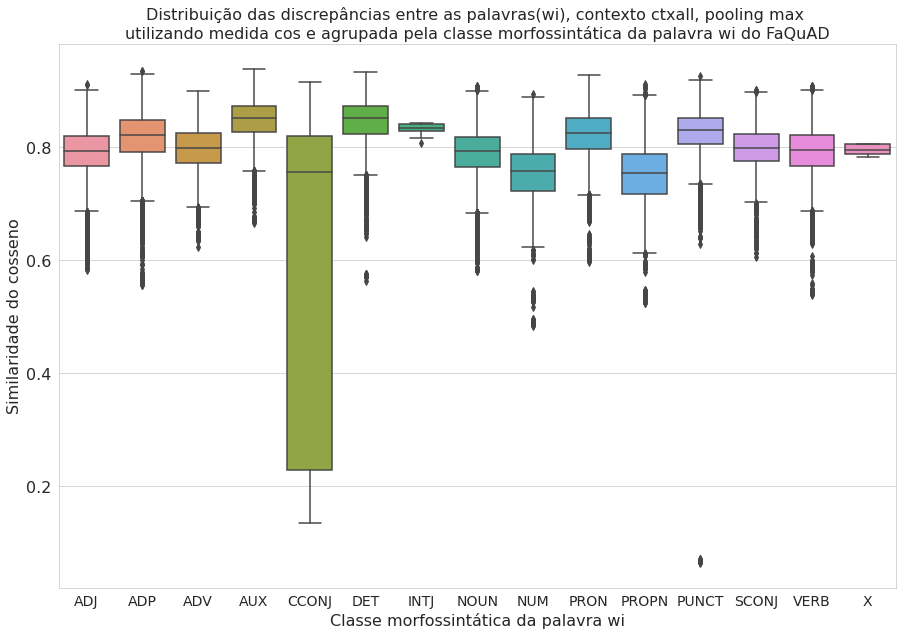

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   12118.000000 23.128905 4.268453 12.266150 20.336857 23.154379 25.622225   
ADP   33468.000000 22.515184 3.074667 13.440358 20.410114 22.205997 24.190068   
ADV    4469.000000 25.039504 3.739991 13.356980 22.499268 24.597639 27.221592   
AUX    9369.000000 20.446771 2.899632 12.695460 18.526802 20.242210 22.032696   
CCONJ  1429.000000 27.609640 6.044130 17.078598 21.792633 26.600557 33.827145   
DET   25591.000000 20.095221 2.652461 12.935775 18.294947 19.708538 21.608898   
INTJ     22.000000 21.511346 0.832420 20.755898 20.925406 21.399916 21.590709   
NOUN  47221.000000 23.276385 3.206298 10.244466 21.360081 23.058807 25.051912   
NUM     871.000000 25.942807 4.917518 11.634485 22.323755 26.489464 29.200660   
PRON  17144.000000 22.037716 2.999940 12.498813 20.103530 21.928077 23.752249   
PROPN  8535.000000 22.205155 4.354630 10.444147 19.471908 22.357655 24.889508   
PUNCT 19664.000000 21.117273 2.795246 14.169297 19.534247 20.900611 22.369619   
SCONJ  4485.000000 24.038080 2.807165 16.207983 22.254230 24.114040 25.722052   
VERB  20191.000000 25.342731 4.183447 10.446237 22.627509 25.099951 27.690548   
X         5.000000 27.697372 1.064652 26.367697 27.441513 27.518072 27.834480   

            max  
pos_i            
ADJ   41.121609  
ADP   42.752651  
ADV   43.530567  
AUX   43.828899  
CCONJ 36.508762  
DET   44.953880  
INTJ  24.300999  
NOUN  43.424953  
NUM   41.822754  
PRON  42.060272  
PROPN 44.943771  
PUNCT 43.524097  
SCONJ 37.227230  
VERB  45.165359  
X     29.325096

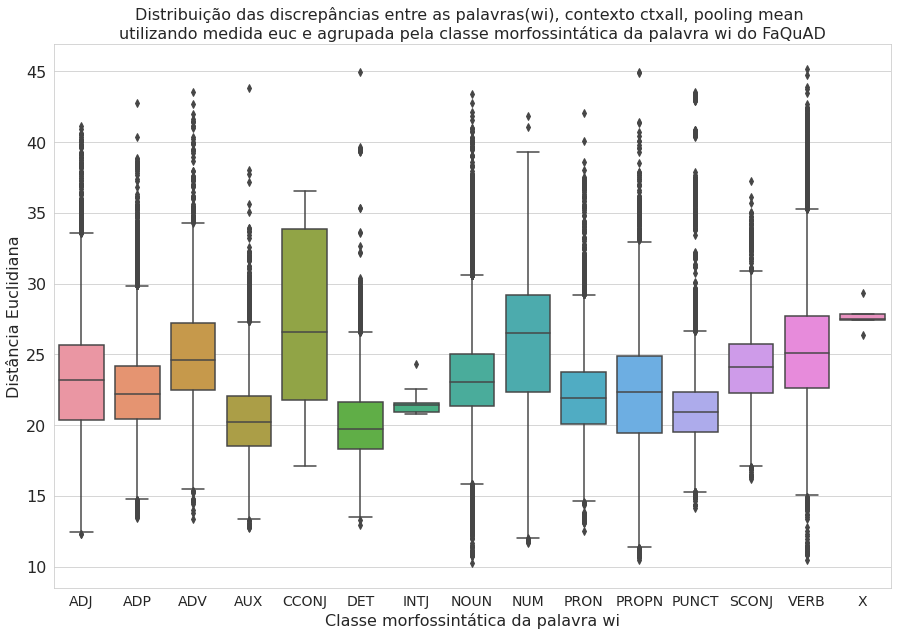

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   12118.000000 24.832842 3.478990 16.071148 22.498690 24.241252 26.651091   
ADP   33468.000000 22.515184 3.074667 13.440358 20.410114 22.205997 24.190068   
ADV    4469.000000 25.157282 3.624101 16.808903 22.639048 24.671139 27.223608   
AUX    9369.000000 20.446771 2.899632 12.695460 18.526802 20.242210 22.032696   
CCONJ  1429.000000 27.868517 6.147576 17.078598 21.934967 26.907448 33.945713   
DET   25591.000000 20.292589 2.720581 12.935775 18.405609 19.911608 21.942816   
INTJ     22.000000 21.511346 0.832420 20.755898 20.925406 21.399916 21.590709   
NOUN  47221.000000 24.053537 2.933351 15.810619 22.029222 23.716198 25.652149   
NUM     871.000000 28.440607 5.320769 17.030682 25.154361 27.830894 31.254359   
PRON  17144.000000 22.114997 2.980508 13.704464 20.162819 21.994607 23.839967   
PROPN  8535.000000 25.814934 3.273380 17.192293 23.572071 25.461760 27.575786   
PUNCT 19664.000000 21.117273 2.795246 14.169297 19.534247 20.900611 22.369619   
SCONJ  4485.000000 24.038080 2.807165 16.207983 22.254230 24.114040 25.722052   
VERB  20191.000000 26.033440 3.819571 16.289457 23.464928 25.667862 28.096280   
X         5.000000 27.697372 1.064652 26.367697 27.441513 27.518072 27.834480   

            max  
pos_i            
ADJ   41.121609  
ADP   42.752651  
ADV   43.530567  
AUX   43.828899  
CCONJ 39.459072  
DET   44.953880  
INTJ  24.300999  
NOUN  43.424953  
NUM   44.832123  
PRON  42.060272  
PROPN 44.943771  
PUNCT 43.524097  
SCONJ 37.227230  
VERB  45.165359  
X     29.325096

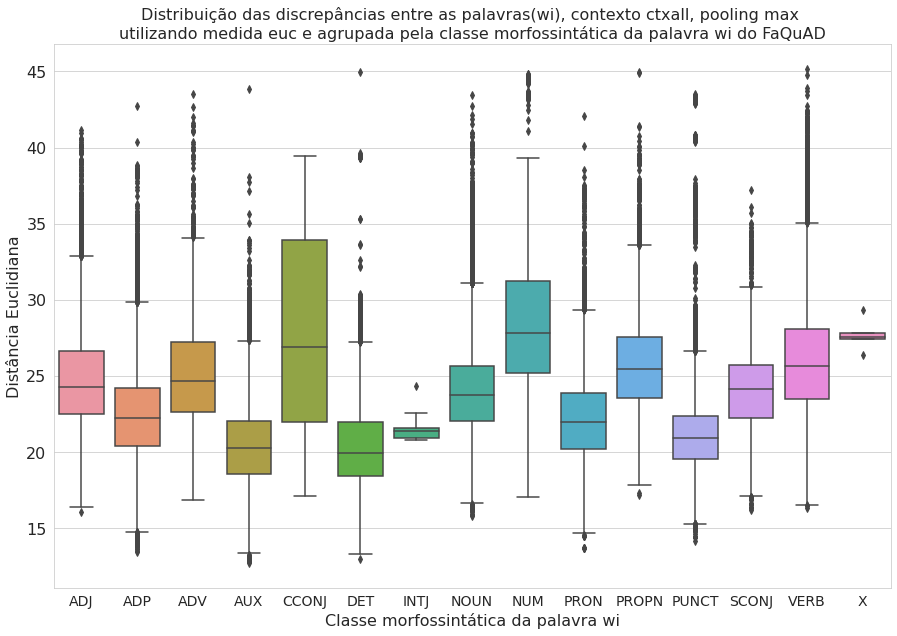

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   12118.000000 1091.491474 188.288138  562.979430  967.224335 1101.866350   
ADP   33468.000000 1106.722510 150.032737  660.910300 1004.487062 1090.989850   
ADV    4469.000000 1209.144106 166.675911  604.859100 1097.200200 1201.522000   
AUX    9369.000000  994.385564 142.596574  613.195560  898.855800  983.979400   
CCONJ  1429.000000 1103.620495 105.185961  846.335450 1052.024800 1095.748000   
DET   25591.000000  986.965624 130.423119  631.158100  897.248135  969.730100   
INTJ     22.000000 1045.158422  42.885669 1008.033260 1016.691450 1040.789700   
NOUN  47221.000000 1099.016163 143.600945  494.070370 1013.065060 1088.969600   
NUM     871.000000 1235.173315 214.037072  563.257000 1089.878450 1269.747300   
PRON  17144.000000 1083.409084 149.387895  601.046000  986.903032 1078.862350   
PROPN  8535.000000 1047.138302 194.636757  504.507450  926.521950 1055.391800   
PUNCT 19664.000000 1043.192815 124.785261  657.454300  965.958683 1037.637650   
SCONJ  4485.000000 1186.062738 140.134511  802.930050 1093.941800 1193.350500   
VERB  20191.000000 1204.052196 178.422974  507.446400 1089.270400 1200.591600   
X         5.000000 1269.179180  51.447990 1222.521500 1234.863000 1264.105700   

              75%         max  
pos_i                          
ADJ   1209.872750 1737.147000  
ADP   1188.822875 1925.855300  
ADV   1309.609400 1942.541400  
AUX   1074.304900 1888.893100  
CCONJ 1140.392300 1531.681400  
DET   1063.262250 1970.572300  
INTJ  1049.955100 1205.568700  
NOUN  1181.370600 1996.594200  
NUM   1377.188300 1844.930700  
PRON  1172.556025 1866.254600  
PROPN 1169.370450 1946.452300  
PUNCT 1113.859275 1740.347800  
SCONJ 1273.590600 1743.244600  
VERB  1313.006300 2096.301800  
X     1270.338600 1354.067100

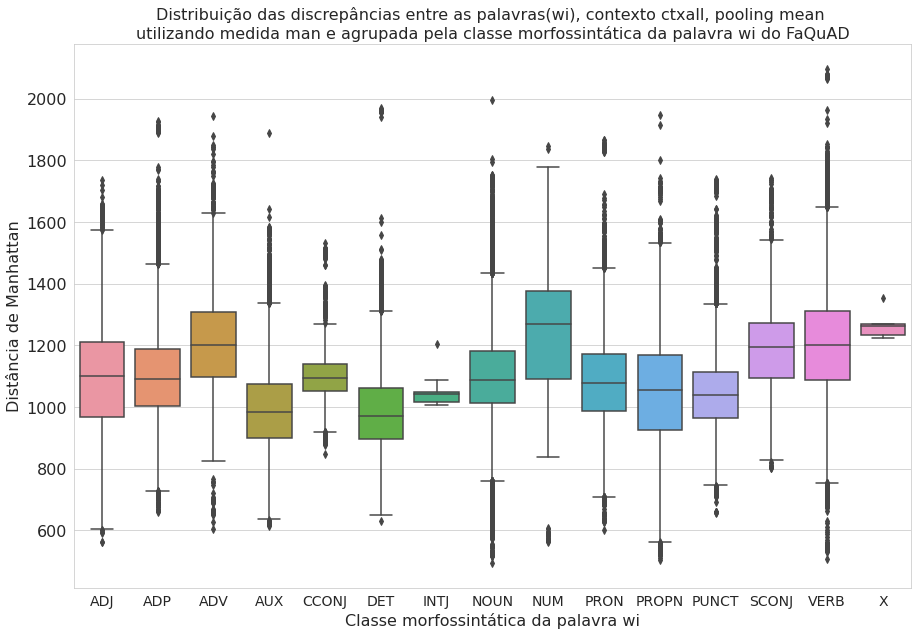

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   12118.000000 1172.370481 153.092086  780.633300 1068.023400 1148.268750   
ADP   33468.000000 1106.722510 150.032737  660.910300 1004.487062 1090.989850   
ADV    4469.000000 1215.151333 159.924308  826.006350 1105.219600 1205.825800   
AUX    9369.000000  994.385564 142.596574  613.195560  898.855800  983.979400   
CCONJ  1429.000000 1114.979533 124.741204  846.335450 1055.389900 1097.974100   
DET   25591.000000  996.284948 132.950911  631.158100  903.308550  979.794070   
INTJ     22.000000 1045.158422  42.885669 1008.033260 1016.691450 1040.789700   
NOUN  47221.000000 1136.026107 133.952150  758.468260 1042.240600 1118.981900   
NUM     871.000000 1364.717994 276.768721  848.229860 1210.843450 1330.749800   
PRON  17144.000000 1086.734369 148.184902  682.545700  990.864285 1081.759650   
PROPN  8535.000000 1226.531006 162.690432  818.444100 1116.758200 1206.410200   
PUNCT 19664.000000 1043.192815 124.785261  657.454300  965.958683 1037.637650   
SCONJ  4485.000000 1186.062738 140.134511  802.930050 1093.941800 1193.350500   
VERB  20191.000000 1237.449344 164.148036  790.707300 1127.367400 1225.216600   
X         5.000000 1269.179180  51.447990 1222.521500 1234.863000 1264.105700   

              75%         max  
pos_i                          
ADJ   1255.936825 1892.661600  
ADP   1188.822875 1925.855300  
ADV   1310.774800 1942.541400  
AUX   1074.304900 1888.893100  
CCONJ 1142.088900 1709.468500  
DET   1077.147550 1970.572300  
INTJ  1049.955100 1205.568700  
NOUN  1210.973900 1996.594200  
NUM   1464.355750 2379.885700  
PRON  1176.163300 1866.254600  
PROPN 1306.773650 1946.452300  
PUNCT 1113.859275 1740.347800  
SCONJ 1273.590600 1743.244600  
VERB  1334.234150 2123.833000  
X     1270.338600 1354.067100

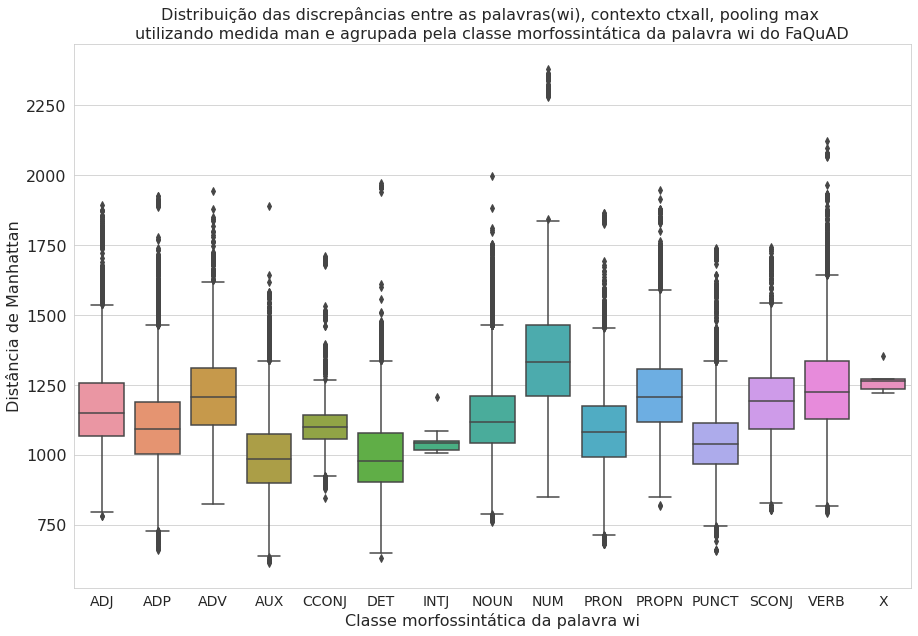

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras sem as stopwords(ctxclean)

In [ ]:
equacao_medida = "ctxclean"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   12118.000000 0.832002 0.047091 0.578657 0.807372 0.839266 0.864551   
ADP   33468.000000 0.755780 0.047913 0.485761 0.727532 0.761551 0.789294   
ADV    4469.000000 0.757780 0.056497 0.595596 0.723870 0.753604 0.790107   
AUX    9369.000000 0.782838 0.042764 0.606675 0.755386 0.783731 0.808574   
CCONJ  1429.000000 0.494058 0.286385 0.094301 0.167748 0.684015 0.755133   
DET   25591.000000 0.784819 0.041540 0.546125 0.759584 0.789306 0.814328   
INTJ     22.000000 0.757731 0.022885 0.730800 0.747357 0.753756 0.760477   
NOUN  47221.000000 0.825993 0.045958 0.553994 0.800951 0.831825 0.857735   
NUM     871.000000 0.786135 0.054212 0.632085 0.755831 0.790935 0.825830   
PRON  17144.000000 0.746001 0.041749 0.528476 0.720916 0.750422 0.775163   
PROPN  8535.000000 0.817558 0.052338 0.636304 0.783200 0.818474 0.856101   
PUNCT 19664.000000 0.818482 0.049902 0.087471 0.791469 0.818868 0.845142   
SCONJ  4485.000000 0.734055 0.046549 0.520808 0.703731 0.732103 0.764615   
VERB  20191.000000 0.811326 0.050969 0.508645 0.781270 0.818029 0.846843   
X         5.000000 0.833440 0.009459 0.823408 0.824588 0.833429 0.842442   

           max  
pos_i           
ADJ   0.950571  
ADP   0.904727  
ADV   0.935495  
AUX   0.923898  
CCONJ 0.845109  
DET   0.928719  
INTJ  0.849790  
NOUN  0.954357  
NUM   0.914468  
PRON  0.938594  
PROPN 0.952024  
PUNCT 1.000000  
SCONJ 0.861014  
VERB  0.935620  
X     0.843333

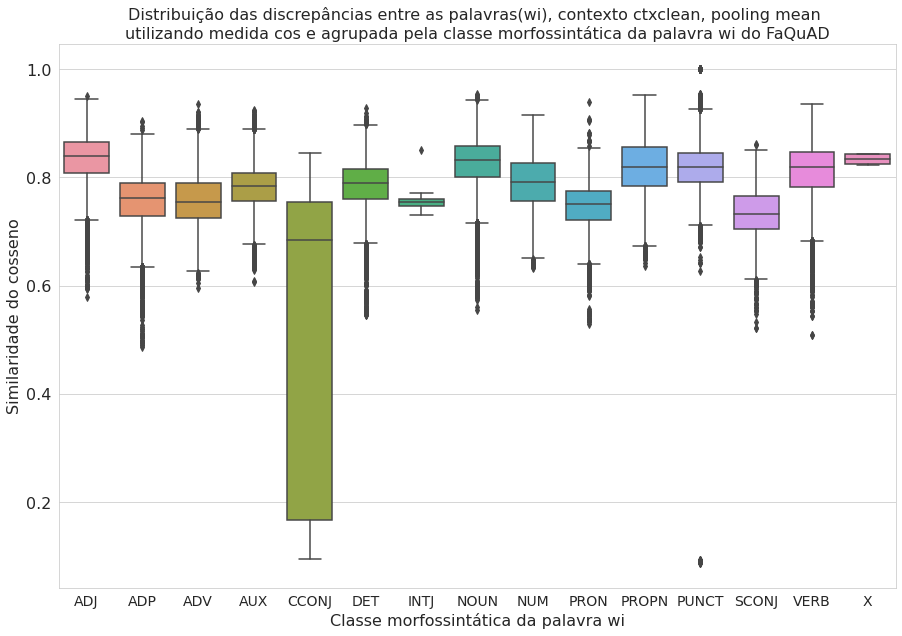

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   12118.000000 0.807219 0.059890 0.532829 0.773290 0.817079 0.850033   
ADP   33468.000000 0.755780 0.047913 0.485761 0.727532 0.761551 0.789294   
ADV    4469.000000 0.756122 0.054837 0.595596 0.723771 0.752767 0.786921   
AUX    9369.000000 0.782838 0.042764 0.606675 0.755386 0.783731 0.808574   
CCONJ  1429.000000 0.489526 0.286181 0.094301 0.167748 0.684015 0.755133   
DET   25591.000000 0.782184 0.041503 0.546125 0.756679 0.787015 0.812114   
INTJ     22.000000 0.757731 0.022885 0.730800 0.747357 0.753756 0.760477   
NOUN  47221.000000 0.814782 0.055313 0.553994 0.785888 0.825114 0.853694   
NUM     871.000000 0.755172 0.089726 0.453562 0.727899 0.773919 0.820272   
PRON  17144.000000 0.745024 0.041921 0.528476 0.719834 0.749398 0.774348   
PROPN  8535.000000 0.765700 0.070237 0.482041 0.718334 0.769488 0.817765   
PUNCT 19664.000000 0.818482 0.049902 0.087471 0.791469 0.818868 0.845142   
SCONJ  4485.000000 0.734055 0.046549 0.520808 0.703731 0.732103 0.764615   
VERB  20191.000000 0.802043 0.055521 0.508645 0.767420 0.808867 0.841796   
X         5.000000 0.833440 0.009459 0.823408 0.824588 0.833429 0.842442   

           max  
pos_i           
ADJ   0.950571  
ADP   0.904727  
ADV   0.935495  
AUX   0.923898  
CCONJ 0.845109  
DET   0.912420  
INTJ  0.849790  
NOUN  0.954357  
NUM   0.914468  
PRON  0.938594  
PROPN 0.952024  
PUNCT 1.000000  
SCONJ 0.861014  
VERB  0.935620  
X     0.843333

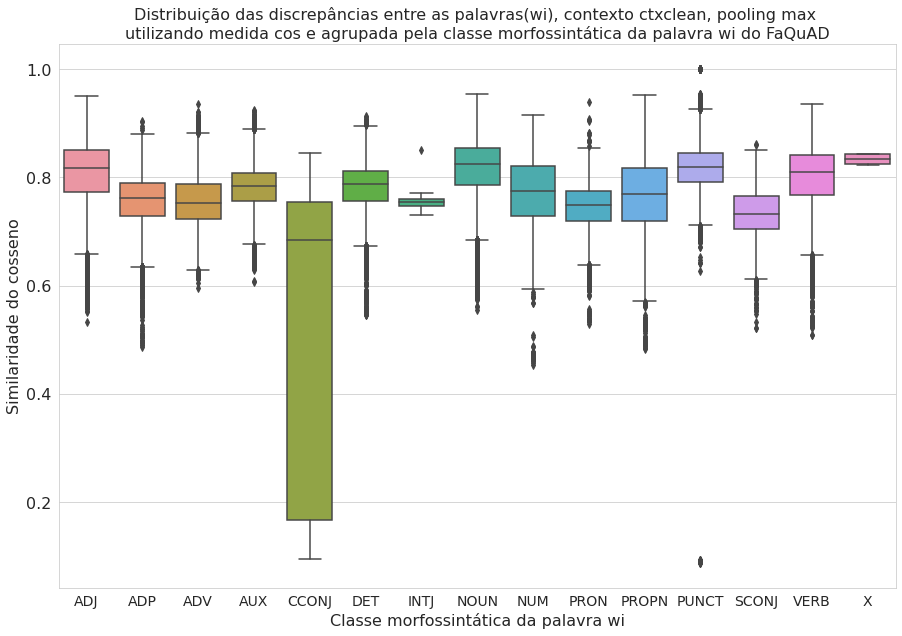

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   12118.000000 22.096275 3.923131 11.087727 19.373537 21.630011 24.390457   
ADP   33468.000000 25.747573 2.934314 16.351160 23.756270 25.395941 27.326419   
ADV    4469.000000 27.051765 3.332943 13.931999 25.073656 26.788567 28.882874   
AUX    9369.000000 24.164228 2.663942 14.392744 22.619562 24.088804 25.780947   
CCONJ  1429.000000 30.808849 5.678953 20.745806 25.479742 28.842936 36.892113   
DET   25591.000000 23.733620 2.442872 13.549007 22.052580 23.537167 25.200577   
INTJ     22.000000 25.843216 1.156425 22.024366 25.407312 26.003521 26.434177   
NOUN  47221.000000 21.857361 3.315166 11.572813 19.688345 21.477093 23.569895   
NUM     871.000000 25.595843 3.668781 15.770556 22.789144 25.322914 28.086364   
PRON  17144.000000 26.226481 2.525471 13.499160 24.503371 26.034897 27.655532   
PROPN  8535.000000 21.553301 3.587646 11.364957 19.389162 21.541233 23.577835   
PUNCT 19664.000000 21.582847 3.082533  0.000000 20.061379 21.690814 23.232204   
SCONJ  4485.000000 27.346389 2.745295 19.800234 25.590492 27.271938 29.033749   
VERB  20191.000000 24.731028 3.938316 12.951006 22.107205 24.528278 26.877032   
X         5.000000 25.272656 1.020440 23.951057 25.072861 25.208973 25.317410   

            max  
pos_i            
ADJ   39.204811  
ADP   46.468918  
ADV   43.639805  
AUX   43.232044  
CCONJ 39.110958  
DET   48.854042  
INTJ  27.774925  
NOUN  45.852936  
NUM   38.258713  
PRON  45.751255  
PROPN 43.336609  
PUNCT 41.456024  
SCONJ 39.810234  
VERB  48.667980  
X     26.812979

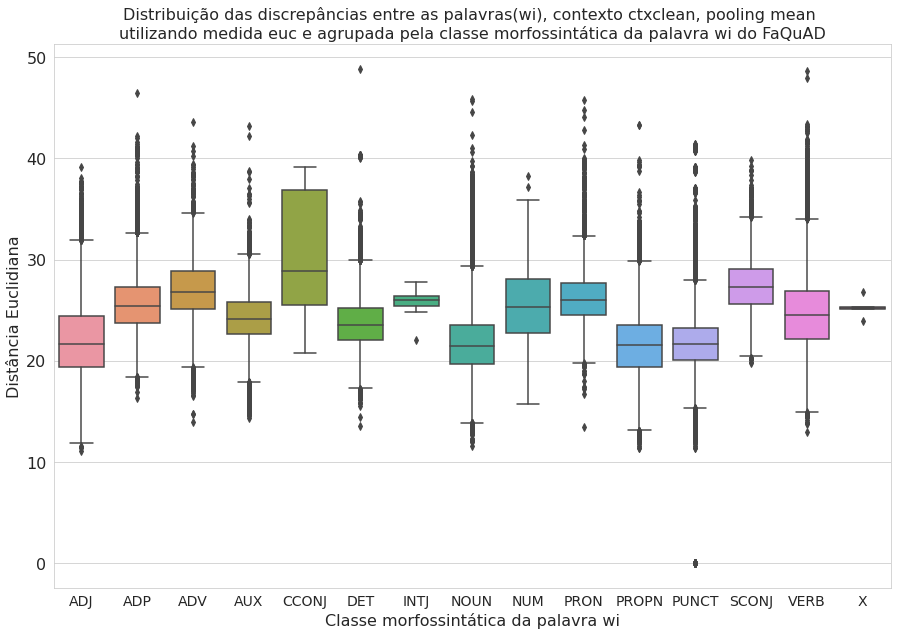

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   12118.000000 23.797503 3.840079 12.384276 21.215338 23.419905 25.933525   
ADP   33468.000000 25.747573 2.934314 16.351160 23.756270 25.395941 27.326419   
ADV    4469.000000 27.165702 3.169314 16.602484 25.239719 26.794556 28.882874   
AUX    9369.000000 24.164228 2.663942 14.392744 22.619562 24.088804 25.780947   
CCONJ  1429.000000 31.055516 5.709932 20.745806 25.568083 29.501854 36.970840   
DET   25591.000000 23.914040 2.430166 16.407963 22.212185 23.701500 25.391365   
INTJ     22.000000 25.843216 1.156425 22.024366 25.407312 26.003521 26.434177   
NOUN  47221.000000 22.618188 3.585914 11.572813 20.164122 22.143478 24.594397   
NUM     871.000000 27.954641 5.277834 20.190586 24.560084 26.969828 30.332143   
PRON  17144.000000 26.291851 2.522657 13.499160 24.559042 26.074778 27.722772   
PROPN  8535.000000 25.062020 4.089249 13.799813 22.145023 24.789368 27.524389   
PUNCT 19664.000000 21.582847 3.082533  0.000000 20.061379 21.690814 23.232204   
SCONJ  4485.000000 27.346389 2.745295 19.800234 25.590492 27.271938 29.033749   
VERB  20191.000000 25.406927 3.836268 14.424446 22.945341 25.171650 27.456827   
X         5.000000 25.272656 1.020440 23.951057 25.072861 25.208973 25.317410   

            max  
pos_i            
ADJ   39.204811  
ADP   46.468918  
ADV   43.639805  
AUX   43.232044  
CCONJ 40.533363  
DET   48.854042  
INTJ  27.774925  
NOUN  45.852936  
NUM   46.676414  
PRON  45.751255  
PROPN 43.336609  
PUNCT 41.456024  
SCONJ 39.810234  
VERB  48.667980  
X     26.812979

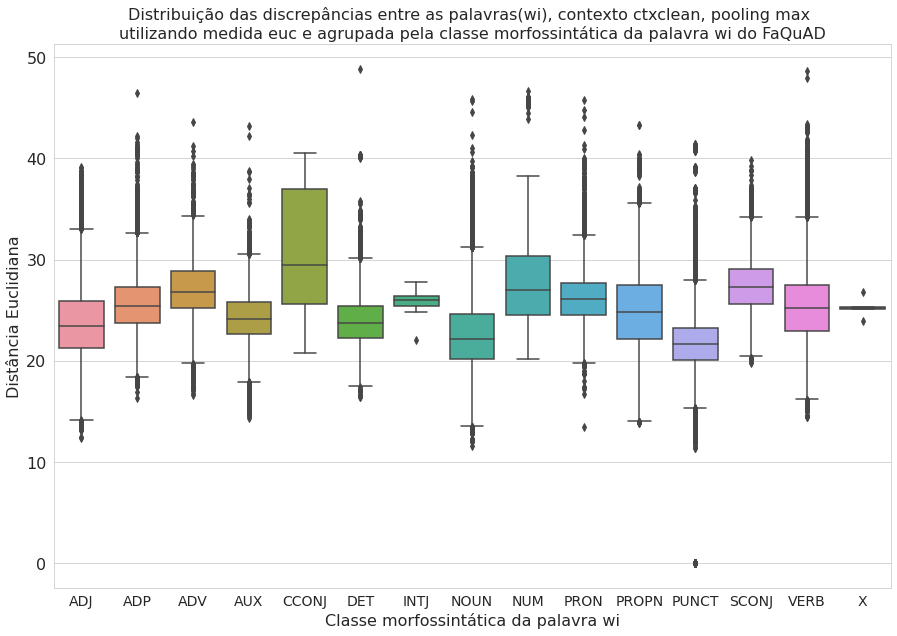

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   12118.000000 1042.816926 179.705761  530.128300  916.821025 1023.820450   
ADP   33468.000000 1257.021074 144.607061  783.303200 1158.826575 1237.060050   
ADV    4469.000000 1305.483138 161.246841  690.530300 1207.490000 1298.897700   
AUX    9369.000000 1165.410180 128.405014  705.057800 1086.599100 1160.045200   
CCONJ  1429.000000 1230.803659  99.574487  998.926450 1169.981600 1211.254300   
DET   25591.000000 1154.815467 117.044843  640.704160 1073.754950 1145.349000   
INTJ     22.000000 1244.420900  48.711268 1082.256700 1220.255425 1255.698450   
NOUN  47221.000000 1034.509492 153.131857  565.882750  934.104400 1015.104400   
NUM     871.000000 1221.802725 174.771136  752.305000 1086.555150 1222.033900   
PRON  17144.000000 1279.188837 126.269462  649.738160 1191.981100 1269.908900   
PROPN  8535.000000 1017.103285 160.774640  554.778750  917.536500 1014.645750   
PUNCT 19664.000000 1054.056152 144.636206    0.000000  980.086580 1063.131600   
SCONJ  4485.000000 1341.851387 137.857394  965.970340 1252.633700 1339.952900   
VERB  20191.000000 1176.942456 175.528741  630.106450 1057.995050 1170.974400   
X         5.000000 1176.825840  55.476528 1119.536600 1138.277800 1179.813700   

              75%         max  
pos_i                          
ADJ   1152.412075 1702.087800  
ADP   1333.608725 2029.858800  
ADV   1397.372700 1818.209800  
AUX   1244.832000 1842.581800  
CCONJ 1270.985400 1645.745700  
DET   1224.055800 2107.836000  
INTJ  1271.228275 1316.143600  
NOUN  1115.250500 2009.354000  
NUM   1334.625850 1709.127700  
PRON  1353.864900 2048.918000  
PROPN 1102.960750 1877.994400  
PUNCT 1138.944350 1664.042000  
SCONJ 1431.088500 1920.238800  
VERB  1281.939300 2052.186800  
X     1183.106200 1263.394900

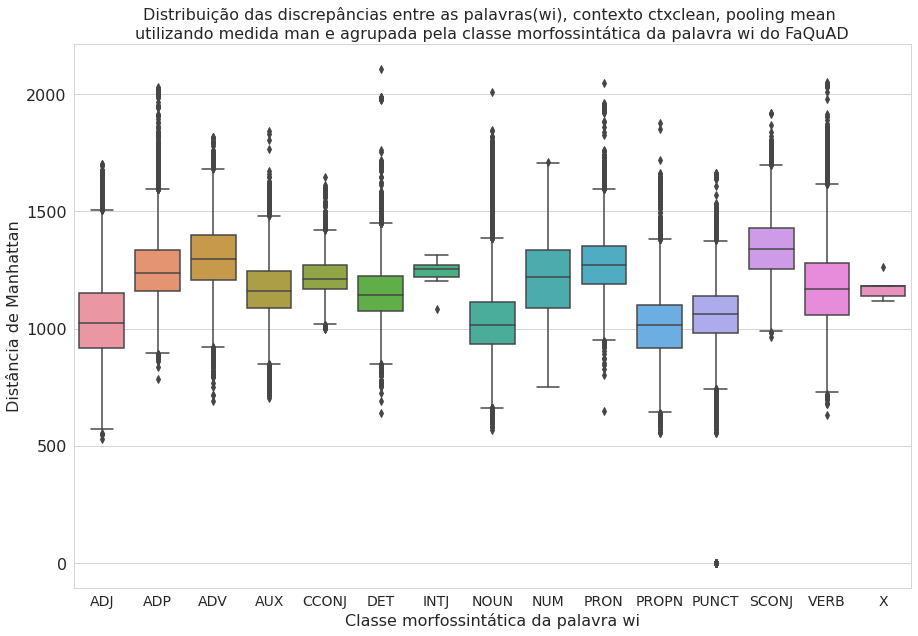

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   12118.000000 1122.162458 177.067810  599.437870 1005.820722 1102.867300   
ADP   33468.000000 1257.021074 144.607061  783.303200 1158.826575 1237.060050   
ADV    4469.000000 1311.198184 152.808962  794.782530 1213.853800 1300.616200   
AUX    9369.000000 1165.410180 128.405014  705.057800 1086.599100 1160.045200   
CCONJ  1429.000000 1241.468199 113.286778 1005.976140 1172.162600 1213.944000   
DET   25591.000000 1163.275379 115.421470  792.279100 1082.217550 1153.698900   
INTJ     22.000000 1244.420900  48.711268 1082.256700 1220.255425 1255.698450   
NOUN  47221.000000 1070.178864 167.633078  565.882750  954.261350 1045.201400   
NUM     871.000000 1343.735988 281.394304  921.451230 1176.462550 1286.551100   
PRON  17144.000000 1281.928270 125.566768  649.738160 1193.811725 1271.747250   
PROPN  8535.000000 1188.250173 203.005305  657.157700 1045.088750 1169.300200   
PUNCT 19664.000000 1054.056152 144.636206    0.000000  980.086580 1063.131600   
SCONJ  4485.000000 1341.851387 137.857394  965.970340 1252.633700 1339.952900   
VERB  20191.000000 1209.181027 174.367882  697.656600 1095.006450 1201.898200   
X         5.000000 1176.825840  55.476528 1119.536600 1138.277800 1179.813700   

              75%         max  
pos_i                          
ADJ   1220.516175 1951.361300  
ADP   1333.608725 2029.858800  
ADV   1397.372700 1818.209800  
AUX   1244.832000 1842.581800  
CCONJ 1274.793300 1756.179200  
DET   1231.464850 2107.836000  
INTJ  1271.228275 1316.143600  
NOUN  1165.413800 2009.354000  
NUM   1429.250000 2416.819300  
PRON  1357.218600 2048.918000  
PROPN 1302.044150 1937.613000  
PUNCT 1138.944350 1664.042000  
SCONJ 1431.088500 1920.238800  
VERB  1308.633050 2148.943000  
X     1183.106200 1263.394900

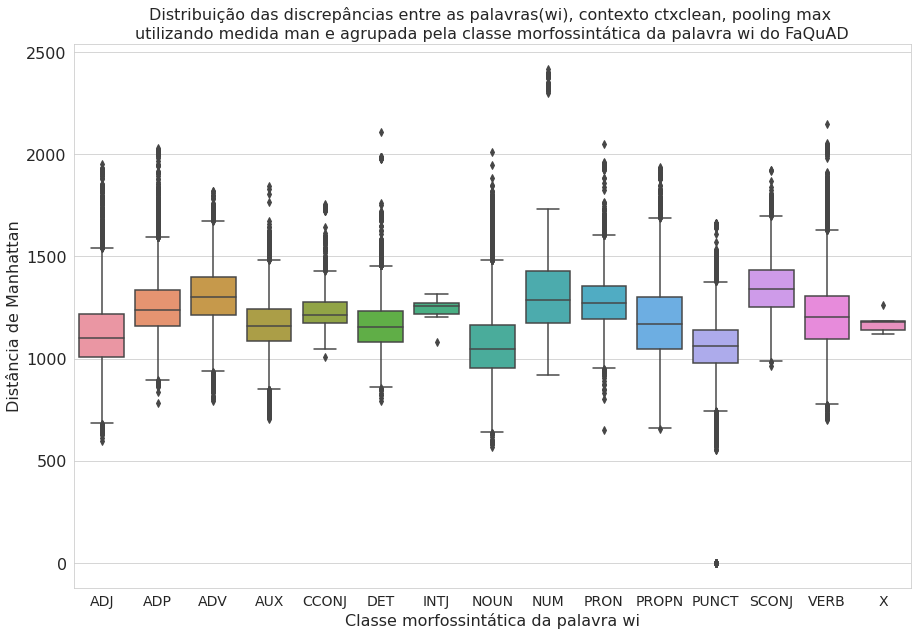

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

In [ ]:
equacao_medida = "ctxverb"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   10363.000000 0.662182 0.070028 0.417619 0.610603 0.662770 0.713221   
ADP   29760.000000 0.646898 0.077914 0.335106 0.596416 0.654000 0.703221   
ADV    4285.000000 0.721765 0.061140 0.498216 0.685392 0.731421 0.765789   
AUX    9369.000000 0.930455 0.057706 0.727411 0.891244 0.917674 1.000000   
CCONJ  1295.000000 0.406888 0.266918 0.040933 0.124419 0.533309 0.652521   
DET   22317.000000 0.715155 0.071556 0.420191 0.667632 0.717714 0.768605   
INTJ      1.000000 0.673239      NaN 0.673239 0.673239 0.673239 0.673239   
NOUN  41984.000000 0.641167 0.068724 0.367089 0.595320 0.645260 0.690805   
NUM     856.000000 0.630135 0.059223 0.495745 0.584589 0.630519 0.667839   
PRON  15973.000000 0.709251 0.061201 0.473783 0.668762 0.710325 0.753159   
PROPN  7754.000000 0.604392 0.076798 0.366237 0.551859 0.605962 0.658937   
PUNCT 17506.000000 0.698172 0.064831 0.030959 0.660330 0.707970 0.743630   
SCONJ  4368.000000 0.706339 0.065276 0.481119 0.659385 0.713805 0.755258   
VERB  20191.000000 0.919100 0.060371 0.621091 0.879130 0.919675 1.000000   
X         5.000000 0.591420 0.011787 0.573948 0.585761 0.594187 0.600310   

           max  
pos_i           
ADJ   0.911387  
ADP   0.848085  
ADV   0.885967  
AUX   1.000000  
CCONJ 0.802824  
DET   0.890831  
INTJ  0.673239  
NOUN  0.892101  
NUM   0.817252  
PRON  0.885224  
PROPN 0.823466  
PUNCT 0.843460  
SCONJ 0.873806  
VERB  1.000000  
X     0.602896

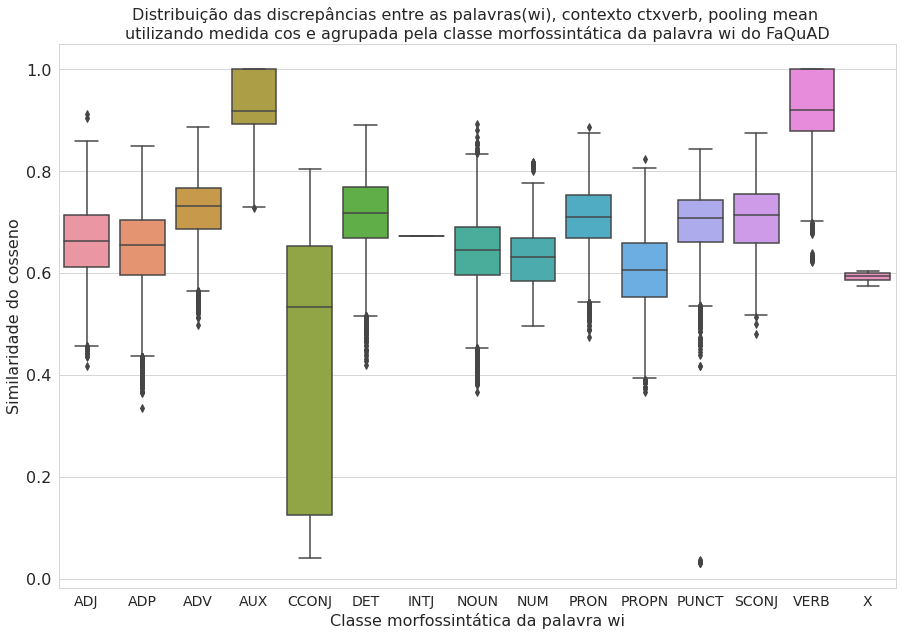

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   10363.000000 0.642618 0.080845 0.337460 0.585702 0.647218 0.703295   
ADP   29760.000000 0.646898 0.077914 0.335106 0.596416 0.654000 0.703221   
ADV    4285.000000 0.720826 0.062381 0.498216 0.683914 0.731327 0.765789   
AUX    9369.000000 0.930455 0.057706 0.727411 0.891244 0.917674 1.000000   
CCONJ  1295.000000 0.402079 0.265948 0.040933 0.124419 0.501899 0.652521   
DET   22317.000000 0.712792 0.072266 0.420191 0.664304 0.715531 0.766128   
INTJ      1.000000 0.673239      NaN 0.673239 0.673239 0.673239 0.673239   
NOUN  41984.000000 0.631713 0.072347 0.318914 0.582207 0.636511 0.684559   
NUM     856.000000 0.604836 0.088715 0.294368 0.556032 0.609605 0.665104   
PRON  15973.000000 0.708325 0.061080 0.473783 0.667747 0.709886 0.752992   
PROPN  7754.000000 0.562538 0.077005 0.303833 0.507956 0.568048 0.616958   
PUNCT 17506.000000 0.698172 0.064831 0.030959 0.660330 0.707970 0.743630   
SCONJ  4368.000000 0.706339 0.065276 0.481119 0.659385 0.713805 0.755258   
VERB  20191.000000 0.909742 0.072849 0.546779 0.868594 0.917733 0.957579   
X         5.000000 0.591420 0.011787 0.573948 0.585761 0.594187 0.600310   

           max  
pos_i           
ADJ   0.911387  
ADP   0.848085  
ADV   0.885967  
AUX   1.000000  
CCONJ 0.802824  
DET   0.890831  
INTJ  0.673239  
NOUN  0.892101  
NUM   0.817252  
PRON  0.885224  
PROPN 0.777816  
PUNCT 0.843460  
SCONJ 0.873806  
VERB  1.000000  
X     0.602896

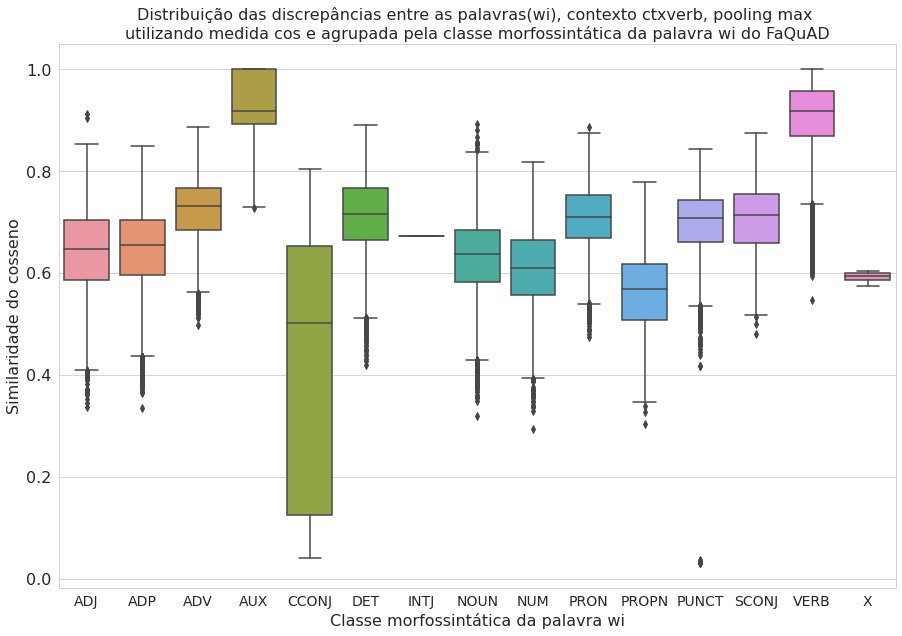

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   10363.000000 32.481672 4.333540 17.498550 29.514500 32.442352 35.168154   
ADP   29760.000000 33.079798 4.700108 21.028620 29.776421 32.554989 35.906375   
ADV    4285.000000 30.028052 4.418828 20.057484 26.640959 29.317947 32.864510   
AUX    9369.000000 11.438773 8.667453  0.000000  0.000000 15.452831 17.871454   
CCONJ  1295.000000 37.483671 6.784974 22.463518 31.816699 38.884727 42.870781   
DET   22317.000000 29.284765 4.943406 16.953341 25.698763 28.812403 32.454582   
INTJ      1.000000 32.300083      NaN 32.300083 32.300083 32.300083 32.300083   
NOUN  41984.000000 33.227609 4.311970 19.317062 30.225821 32.880369 35.810095   
NUM     856.000000 35.497814 4.268155 22.895027 32.720691 35.266623 38.206861   
PRON  15973.000000 29.849473 4.380418 17.233864 26.609568 29.585472 32.609226   
PROPN  7754.000000 34.318863 4.385470 22.412123 31.386742 34.254810 37.022869   
PUNCT 17506.000000 29.948475 4.515193 20.395153 26.634661 29.008649 32.432712   
SCONJ  4368.000000 30.172044 4.540806 18.732771 26.954298 29.500863 32.870354   
VERB  20191.000000 14.056261 8.784381  0.000000  0.000000 16.713814 19.925132   
X         5.000000 38.325243 1.085657 37.183247 37.574814 38.375805 38.488373   

            max  
pos_i            
ADJ   55.272598  
ADP   59.446781  
ADV   51.041286  
AUX   40.762741  
CCONJ 59.254642  
DET   53.412556  
INTJ  32.300083  
NOUN  57.853046  
NUM   51.823425  
PRON  52.722588  
PROPN 57.500439  
PUNCT 53.725338  
SCONJ 50.204811  
VERB  40.276051  
X     40.003975

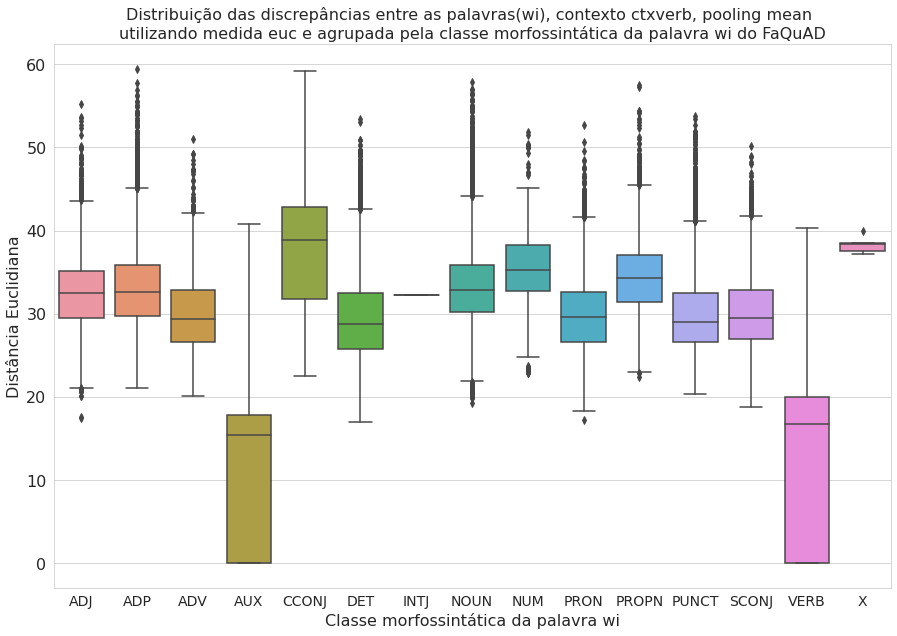

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   10363.000000 33.636629 4.458278 17.498550 30.716547 33.410095 36.519417   
ADP   29760.000000 33.079798 4.700108 21.028620 29.776421 32.554989 35.906375   
ADV    4285.000000 30.083425 4.466767 20.057484 26.648548 29.345701 32.897533   
AUX    9369.000000 11.438773 8.667453  0.000000  0.000000 15.452831 17.871454   
CCONJ  1295.000000 37.737370 6.699916 22.463518 32.228748 39.212612 42.961025   
DET   22317.000000 29.430672 4.976928 16.953341 25.837776 28.951468 32.654064   
INTJ      1.000000 32.300083      NaN 32.300083 32.300083 32.300083 32.300083   
NOUN  41984.000000 33.787677 4.348734 19.317062 30.688802 33.512224 36.446678   
NUM     856.000000 37.313116 5.644099 22.895027 33.409264 37.207254 39.810872   
PRON  15973.000000 29.911277 4.356648 17.233864 26.611265 29.635845 32.672283   
PROPN  7754.000000 36.768244 4.348213 23.725010 33.674061 36.323652 39.488437   
PUNCT 17506.000000 29.948475 4.515193 20.395153 26.634661 29.008649 32.432712   
SCONJ  4368.000000 30.172044 4.540806 18.732771 26.954298 29.500863 32.870354   
VERB  20191.000000 14.862036 9.323236  0.000000 11.877746 17.122120 21.169042   
X         5.000000 38.325243 1.085657 37.183247 37.574814 38.375805 38.488373   

            max  
pos_i            
ADJ   59.808708  
ADP   59.446781  
ADV   51.041286  
AUX   40.762741  
CCONJ 59.254642  
DET   53.412556  
INTJ  32.300083  
NOUN  57.853046  
NUM   54.910103  
PRON  52.722588  
PROPN 60.412590  
PUNCT 53.725338  
SCONJ 50.204811  
VERB  41.658283  
X     40.003975

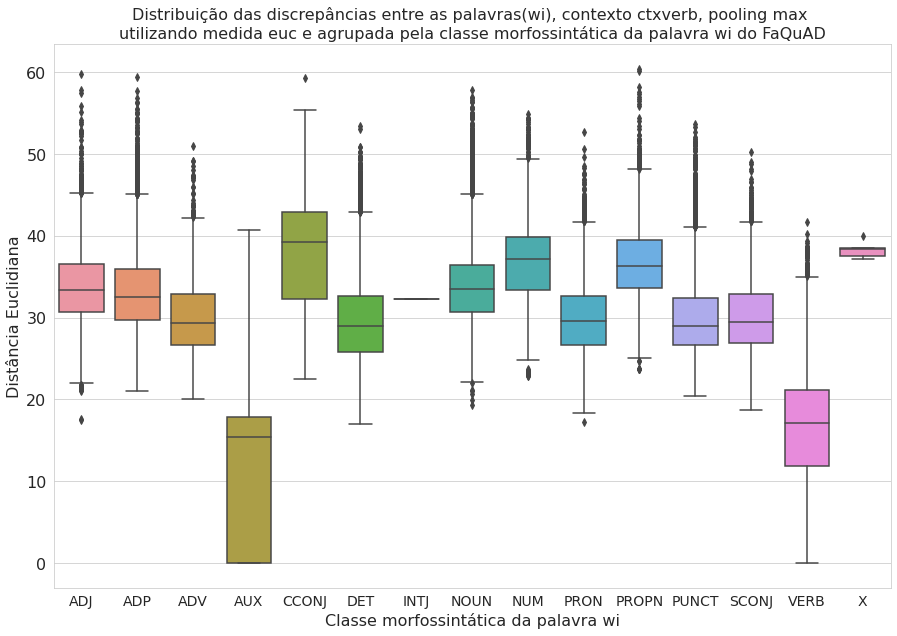

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   10363.000000 1542.318854 192.795474  838.093750 1409.277588 1547.400146   
ADP   29760.000000 1604.601699 204.072704 1027.001343 1458.944244 1591.414246   
ADV    4285.000000 1456.803740 207.300344  977.560669 1298.394897 1431.103271   
AUX    9369.000000  547.190132 414.685321    0.000000    0.000000  740.555298   
CCONJ  1295.000000 1567.301401 181.542842 1095.507446 1439.656433 1563.955078   
DET   22317.000000 1418.413765 220.073786  824.862549 1259.971924 1405.384155   
INTJ      1.000000 1586.296143        NaN 1586.296143 1586.296143 1586.296143   
NOUN  41984.000000 1573.014955 189.574662  906.888184 1439.312836 1563.135498   
NUM     856.000000 1697.040238 182.457525 1118.581787 1572.340332 1689.615784   
PRON  15973.000000 1447.601257 202.485895  855.255371 1300.951172 1440.119873   
PROPN  7754.000000 1621.191092 192.353017 1077.808350 1491.357880 1621.087769   
PUNCT 17506.000000 1455.571869 192.818220  987.958191 1313.598358 1421.906616   
SCONJ  4368.000000 1468.687242 208.667278  929.643494 1316.482422 1443.397095   
VERB  20191.000000  673.925002 420.875838    0.000000    0.000000  801.517944   
X         5.000000 1774.418652  45.838436 1746.555176 1747.157715 1755.531494   

              75%         max  
pos_i                          
ADJ   1669.871338 2297.573730  
ADP   1735.660767 2420.440918  
ADV   1592.771240 2296.178467  
AUX    851.392944 1798.678223  
CCONJ 1683.252625 2126.576172  
DET   1565.751099 2279.921387  
INTJ  1586.296143 1586.296143  
NOUN  1698.537933 2389.483154  
NUM   1833.233795 2269.652832  
PRON  1581.050537 2283.325684  
PROPN 1744.776978 2349.222900  
PUNCT 1572.895874 2325.741211  
SCONJ 1599.275787 2146.676025  
VERB   953.226410 1946.588623  
X     1767.895508 1854.953369

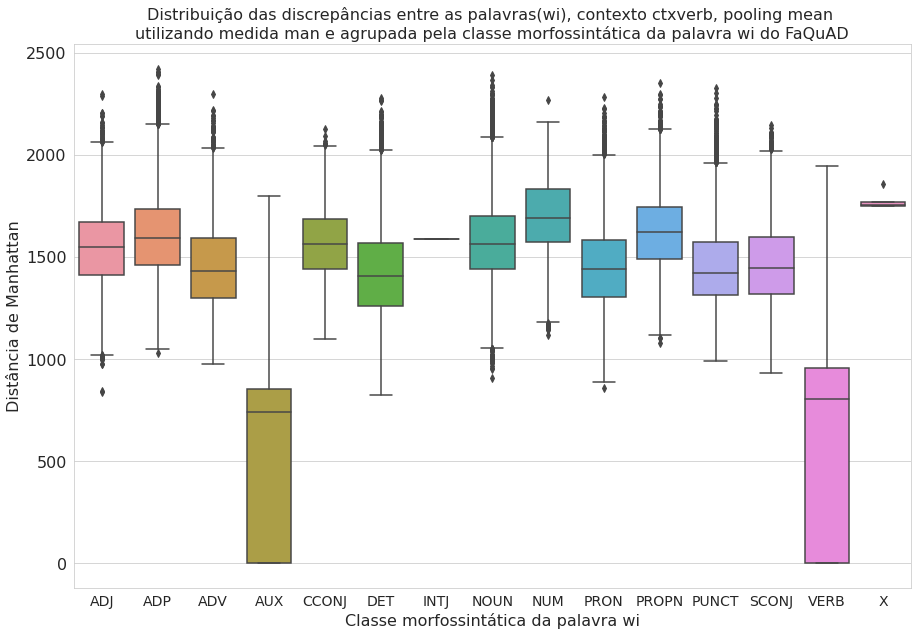

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   10363.000000 1595.237557 198.144499  838.093750 1465.034790 1590.577881   
ADP   29760.000000 1604.601699 204.072704 1027.001343 1458.944244 1591.414246   
ADV    4285.000000 1459.488784 209.722171  977.560669 1299.462646 1432.426270   
AUX    9369.000000  547.190132 414.685321    0.000000    0.000000  740.555298   
CCONJ  1295.000000 1577.927466 179.003087 1095.507446 1445.843811 1571.469238   
DET   22317.000000 1425.066428 221.069643  824.862549 1267.630737 1411.852051   
INTJ      1.000000 1586.296143        NaN 1586.296143 1586.296143 1586.296143   
NOUN  41984.000000 1598.862781 191.729433  906.888184 1461.874725 1591.828735   
NUM     856.000000 1787.940348 260.426421 1118.581787 1611.637299 1789.267273   
PRON  15973.000000 1450.264287 201.073905  855.255371 1301.167480 1442.485352   
PROPN  7754.000000 1737.014413 195.735198 1122.738647 1598.478302 1717.654419   
PUNCT 17506.000000 1455.571869 192.818220  987.958191 1313.598358 1421.906616   
SCONJ  4368.000000 1468.687242 208.667278  929.643494 1316.482422 1443.397095   
VERB  20191.000000  712.869701 447.925645    0.000000  568.986755  818.966309   
X         5.000000 1774.418652  45.838436 1746.555176 1747.157715 1755.531494   

              75%         max  
pos_i                          
ADJ   1725.176453 2380.051514  
ADP   1735.660767 2420.440918  
ADV   1595.255249 2296.178467  
AUX    851.392944 1798.678223  
CCONJ 1694.473999 2126.576172  
DET   1572.850098 2279.921387  
INTJ  1586.296143 1586.296143  
NOUN  1727.222504 2445.218750  
NUM   1905.462006 2643.242676  
PRON  1583.865723 2283.325684  
PROPN 1859.155457 2504.222656  
PUNCT 1572.895874 2325.741211  
SCONJ 1599.275787 2146.676025  
VERB  1016.034180 2155.059082  
X     1767.895508 1854.953369

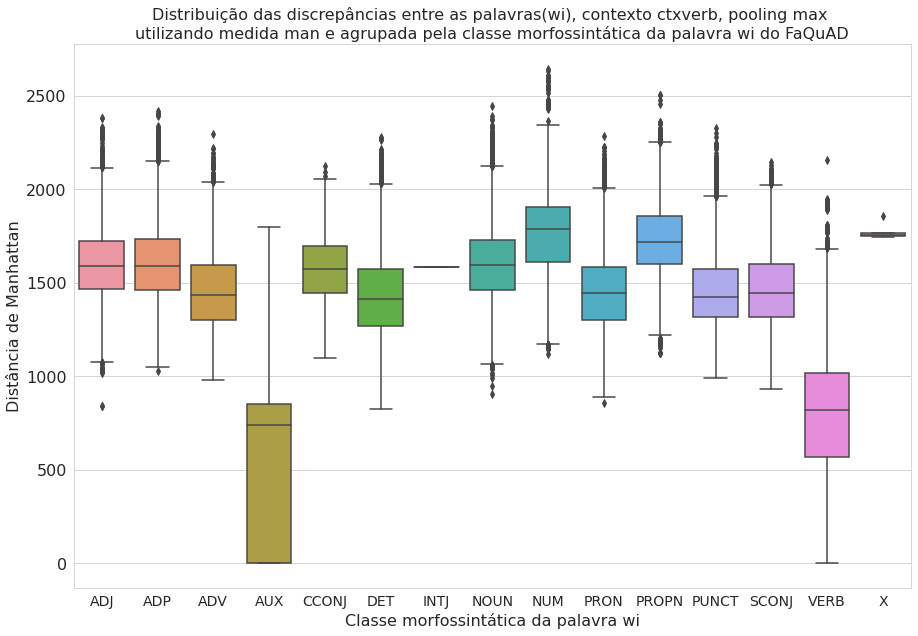

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

In [ ]:
equacao_medida = "ctxnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   11979.000000 0.733838 0.063786 0.443994 0.697412 0.739711 0.776886   
ADP   32751.000000 0.714291 0.070252 0.346324 0.681727 0.730129 0.761781   
ADV    4338.000000 0.649467 0.056530 0.473031 0.613266 0.648688 0.690259   
AUX    8726.000000 0.678010 0.049984 0.451737 0.645794 0.677799 0.712683   
CCONJ  1386.000000 0.447536 0.262742 0.058509 0.157811 0.614463 0.692883   
DET   25001.000000 0.725238 0.045408 0.457886 0.699467 0.729081 0.756217   
INTJ     22.000000 0.697493 0.012036 0.677915 0.688116 0.697253 0.704596   
NOUN  47221.000000 0.878429 0.055854 0.634331 0.842979 0.877219 0.910970   
NUM     870.000000 0.670714 0.051835 0.531470 0.638381 0.675890 0.706003   
PRON  15401.000000 0.640948 0.054564 0.425546 0.605240 0.642375 0.677460   
PROPN  6720.000000 0.636585 0.084428 0.331530 0.587862 0.643774 0.697024   
PUNCT 18435.000000 0.665044 0.050501 0.053923 0.636133 0.669262 0.697430   
SCONJ  4337.000000 0.630251 0.057292 0.413729 0.593822 0.630916 0.669044   
VERB  19309.000000 0.676653 0.058278 0.395881 0.640969 0.679927 0.718486   
X         5.000000 0.684419 0.027999 0.652436 0.661560 0.683040 0.710508   

           max  
pos_i           
ADJ   0.912062  
ADP   0.867786  
ADV   0.851276  
AUX   0.829319  
CCONJ 0.798841  
DET   0.873616  
INTJ  0.717469  
NOUN  1.000000  
NUM   0.846251  
PRON  0.830298  
PROPN 0.852243  
PUNCT 0.829051  
SCONJ 0.789321  
VERB  0.903529  
X     0.714551

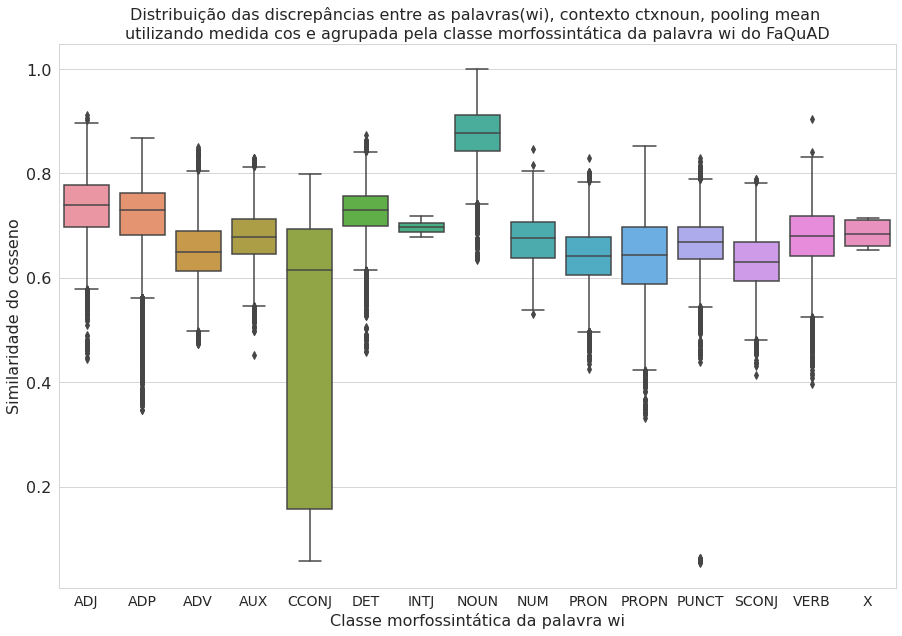

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   11979.000000 0.710522 0.064983 0.443994 0.674217 0.713985 0.753647   
ADP   32751.000000 0.714291 0.070252 0.346324 0.681727 0.730129 0.761781   
ADV    4338.000000 0.648086 0.055490 0.473031 0.612652 0.647232 0.688776   
AUX    8726.000000 0.678010 0.049984 0.451737 0.645794 0.677799 0.712683   
CCONJ  1386.000000 0.443510 0.263050 0.058509 0.157811 0.614463 0.692883   
DET   25001.000000 0.722798 0.047521 0.457886 0.695584 0.727442 0.755886   
INTJ     22.000000 0.697493 0.012036 0.677915 0.688116 0.697253 0.704596   
NOUN  47221.000000 0.866979 0.065506 0.565387 0.830684 0.870583 0.907360   
NUM     870.000000 0.644393 0.083361 0.361936 0.608328 0.661689 0.700372   
PRON  15401.000000 0.640010 0.054779 0.425546 0.603563 0.641433 0.676887   
PROPN  6720.000000 0.596163 0.088816 0.331530 0.532906 0.600808 0.656562   
PUNCT 18435.000000 0.665044 0.050501 0.053923 0.636133 0.669262 0.697430   
SCONJ  4337.000000 0.630251 0.057292 0.413729 0.593822 0.630916 0.669044   
VERB  19309.000000 0.668354 0.057768 0.395881 0.633386 0.672345 0.708663   
X         5.000000 0.684419 0.027999 0.652436 0.661560 0.683040 0.710508   

           max  
pos_i           
ADJ   0.912062  
ADP   0.867786  
ADV   0.851276  
AUX   0.829319  
CCONJ 0.798841  
DET   0.873616  
INTJ  0.717469  
NOUN  1.000000  
NUM   0.846251  
PRON  0.830298  
PROPN 0.835801  
PUNCT 0.829051  
SCONJ 0.789321  
VERB  0.903529  
X     0.714551

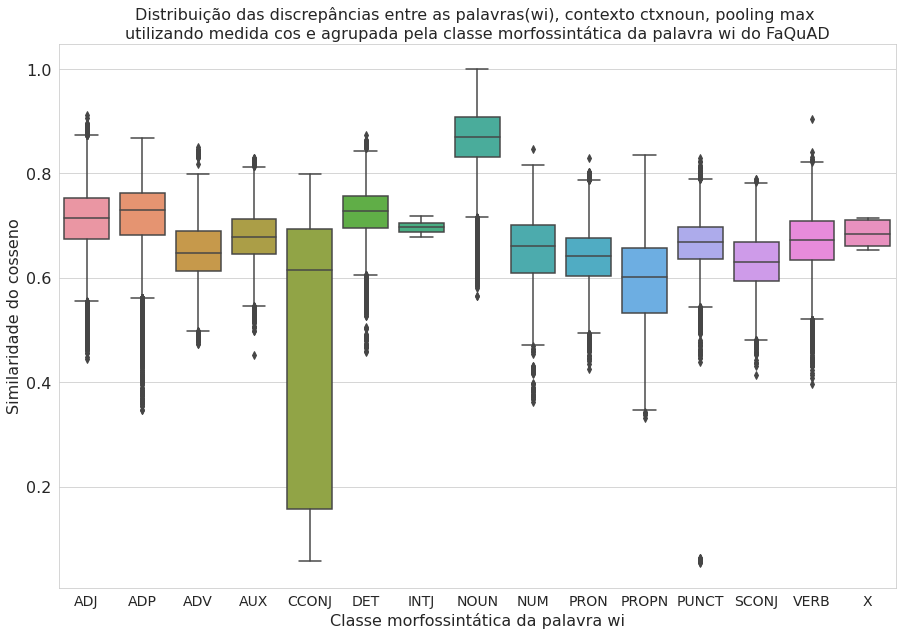

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   11979.000000 27.758764 4.656492 16.109329 24.646093 27.247812 30.600425   
ADP   32751.000000 28.118079 3.998683 18.736053 25.245654 27.315191 30.216134   
ADV    4338.000000 32.757987 3.353649 21.059134 30.672858 32.186951 34.433706   
AUX    8726.000000 29.894147 2.811817 21.624643 28.012941 29.768625 31.453901   
CCONJ  1386.000000 34.080858 5.749187 24.847654 28.637360 33.159878 38.812551   
DET   25001.000000 27.192166 2.579531 18.156540 25.471880 26.967955 28.556211   
INTJ     22.000000 29.561054 1.137742 27.721729 28.731794 29.577482 30.332058   
NOUN  47221.000000 17.696914 6.167775  0.000000 15.857524 18.549200 21.130516   
NUM     870.000000 31.933366 4.038501 21.845448 28.939905 31.878283 34.527254   
PRON  15401.000000 31.674776 2.939022 20.573772 29.673939 31.500275 33.385960   
PROPN  6720.000000 31.623501 4.730142 20.572918 28.455335 31.081161 34.364053   
PUNCT 18435.000000 29.870867 3.004430 20.487247 27.937671 29.424816 31.221445   
SCONJ  4337.000000 32.636054 3.229888 23.464041 30.511709 32.325760 34.518738   
VERB  19309.000000 31.859588 4.032888 18.659601 29.211937 31.523319 34.099205   
X         5.000000 33.343891 2.018072 31.175716 31.900337 32.728645 35.146381   

            max  
pos_i            
ADJ   48.038025  
ADP   49.963310  
ADV   48.335682  
AUX   46.691944  
CCONJ 47.964497  
DET   51.649445  
INTJ  31.685789  
NOUN  40.557644  
NUM   47.834606  
PRON  50.841106  
PROPN 52.906063  
PUNCT 51.019691  
SCONJ 45.300587  
VERB  53.475506  
X     35.768375

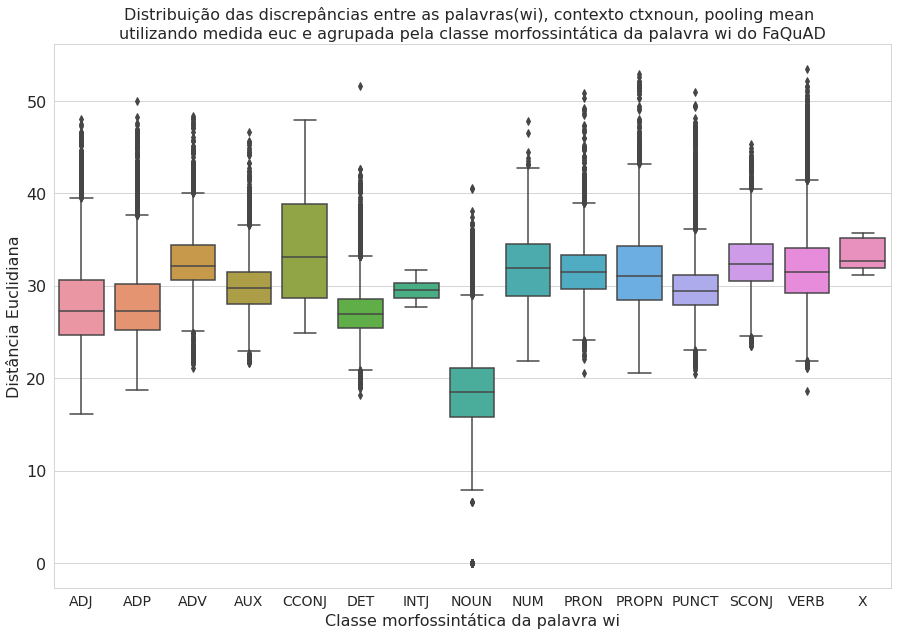

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   11979.000000 29.213862 4.273528 16.109329 26.378645 28.798666 31.488839   
ADP   32751.000000 28.118079 3.998683 18.736053 25.245654 27.315191 30.216134   
ADV    4338.000000 32.839522 3.264242 21.059134 30.735913 32.228718 34.454561   
AUX    8726.000000 29.894147 2.811817 21.624643 28.012941 29.768625 31.453901   
CCONJ  1386.000000 34.306386 5.804183 24.847654 28.816762 33.453640 39.158132   
DET   25001.000000 27.342711 2.681383 18.156540 25.500662 27.096478 28.803617   
INTJ     22.000000 29.561054 1.137742 27.721729 28.731794 29.577482 30.332058   
NOUN  47221.000000 18.620415 6.338819  0.000000 16.323467 19.232294 22.138178   
NUM     870.000000 33.891074 5.319988 21.845448 30.269241 33.039005 36.781469   
PRON  15401.000000 31.733776 2.941992 20.573772 29.731472 31.550791 33.450169   
PROPN  6720.000000 34.051007 4.852572 20.572918 30.701190 33.871944 37.119969   
PUNCT 18435.000000 29.870867 3.004430 20.487247 27.937671 29.424816 31.221445   
SCONJ  4337.000000 32.636054 3.229888 23.464041 30.511709 32.325760 34.518738   
VERB  19309.000000 32.413423 3.747493 18.659601 29.916636 31.982111 34.420940   
X         5.000000 33.343891 2.018072 31.175716 31.900337 32.728645 35.146381   

            max  
pos_i            
ADJ   49.662643  
ADP   49.963310  
ADV   48.335682  
AUX   46.691944  
CCONJ 47.964497  
DET   51.649445  
INTJ  31.685789  
NOUN  40.557644  
NUM   51.324749  
PRON  50.841106  
PROPN 53.062195  
PUNCT 51.019691  
SCONJ 45.300587  
VERB  53.475506  
X     35.768375

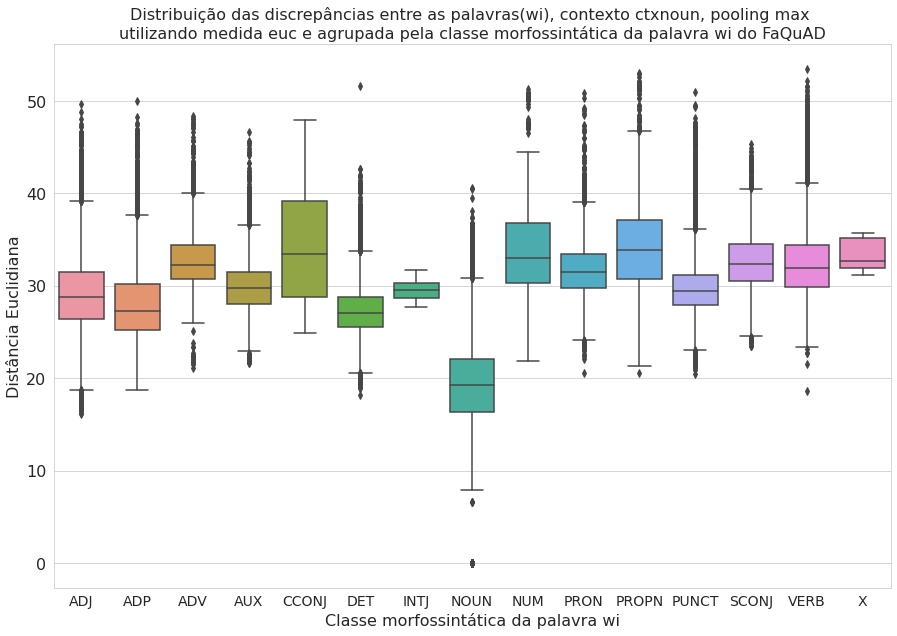

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   11979.000000 1304.436164 214.089619  745.595520 1153.569397 1285.475586   
ADP   32751.000000 1360.757459 195.442199  897.467407 1220.130432 1320.716064   
ADV    4338.000000 1568.443022 151.680325  992.361328 1470.425201 1552.432678   
AUX    8726.000000 1433.015840 131.754202 1044.989868 1344.137146 1426.430176   
CCONJ  1386.000000 1427.791892 177.512729 1165.970703 1304.862854 1394.983215   
DET   25001.000000 1310.704397 122.899922  874.871521 1229.503418 1297.146484   
INTJ     22.000000 1423.939575  46.315971 1349.718140 1384.979858 1427.822998   
NOUN  47221.000000  835.385697 289.322670    0.000000  750.517090  877.356812   
NUM     870.000000 1514.640717 168.225887 1018.777832 1389.668396 1516.891724   
PRON  15401.000000 1536.236895 140.205059  987.327637 1440.884277 1530.625244   
PROPN  6720.000000 1492.793154 220.047634  917.634644 1341.697449 1468.226013   
PUNCT 18435.000000 1455.200855 127.994514 1001.515381 1371.010864 1439.657227   
SCONJ  4337.000000 1590.289980 158.953758 1157.232178 1480.792236 1577.438354   
VERB  19309.000000 1511.474459 176.459644  861.612183 1393.689087 1504.148438   
X         5.000000 1483.529517 100.353167 1380.101929 1391.354980 1487.472412   

              75%         max  
pos_i                          
ADJ   1449.092773 2156.050293  
ADP   1464.744019 2436.965332  
ADV   1653.274139 2285.698730  
AUX   1511.167999 2246.502930  
CCONJ 1479.900024 2156.354004  
DET   1376.678345 2238.284180  
INTJ  1455.250397 1503.175537  
NOUN   999.449402 1799.209473  
NUM   1621.017517 2049.340820  
PRON  1619.763428 2276.420898  
PROPN 1622.841278 2549.481934  
PUNCT 1526.236084 2287.364502  
SCONJ 1684.341553 2222.923584  
VERB  1614.914062 2395.207520  
X     1542.566162 1616.152100

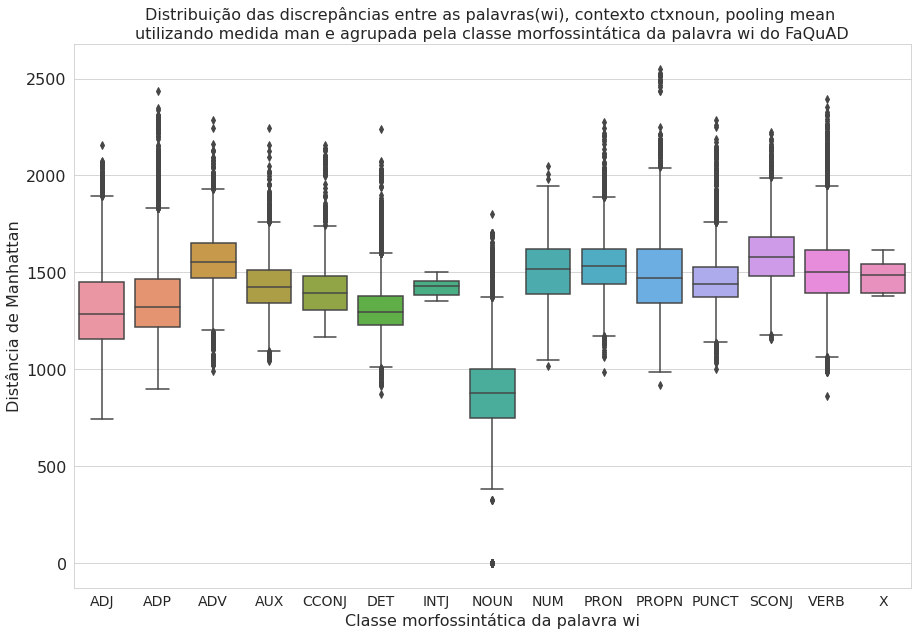

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   11979.000000 1371.824977 195.992706  757.856567 1239.815552 1349.737549   
ADP   32751.000000 1360.757459 195.442199  897.467407 1220.130432 1320.716064   
ADV    4338.000000 1572.548281 146.765489  992.361328 1473.394714 1554.600464   
AUX    8726.000000 1433.015840 131.754202 1044.989868 1344.137146 1426.430176   
CCONJ  1386.000000 1437.352633 184.485165 1165.970703 1310.807861 1398.897766   
DET   25001.000000 1317.748438 127.743568  874.871521 1230.544678 1302.954468   
INTJ     22.000000 1423.939575  46.315971 1349.718140 1384.979858 1427.822998   
NOUN  47221.000000  879.105270 298.639662    0.000000  773.727356  908.731934   
NUM     870.000000 1614.564882 259.017996 1018.777832 1471.832977 1578.146545   
PRON  15401.000000 1538.762778 140.033837  987.327637 1443.780762 1532.928711   
PROPN  6720.000000 1609.122501 233.401772  992.447754 1440.544891 1590.414673   
PUNCT 18435.000000 1455.200855 127.994514 1001.515381 1371.010864 1439.657227   
SCONJ  4337.000000 1590.289980 158.953758 1157.232178 1480.792236 1577.438354   
VERB  19309.000000 1537.836096 165.257693  861.612183 1426.571045 1522.501465   
X         5.000000 1483.529517 100.353167 1380.101929 1391.354980 1487.472412   

              75%         max  
pos_i                          
ADJ   1484.924866 2156.050293  
ADP   1464.744019 2436.965332  
ADV   1656.355652 2285.698730  
AUX   1511.167999 2246.502930  
CCONJ 1485.368530 2156.354004  
DET   1389.980103 2238.284180  
INTJ  1455.250397 1503.175537  
NOUN  1045.594238 1939.636963  
NUM   1712.763458 2571.148926  
PRON  1622.985107 2276.420898  
PROPN 1762.610199 2549.481934  
PUNCT 1526.236084 2287.364502  
SCONJ 1684.341553 2222.923584  
VERB  1632.901855 2395.207520  
X     1542.566162 1616.152100

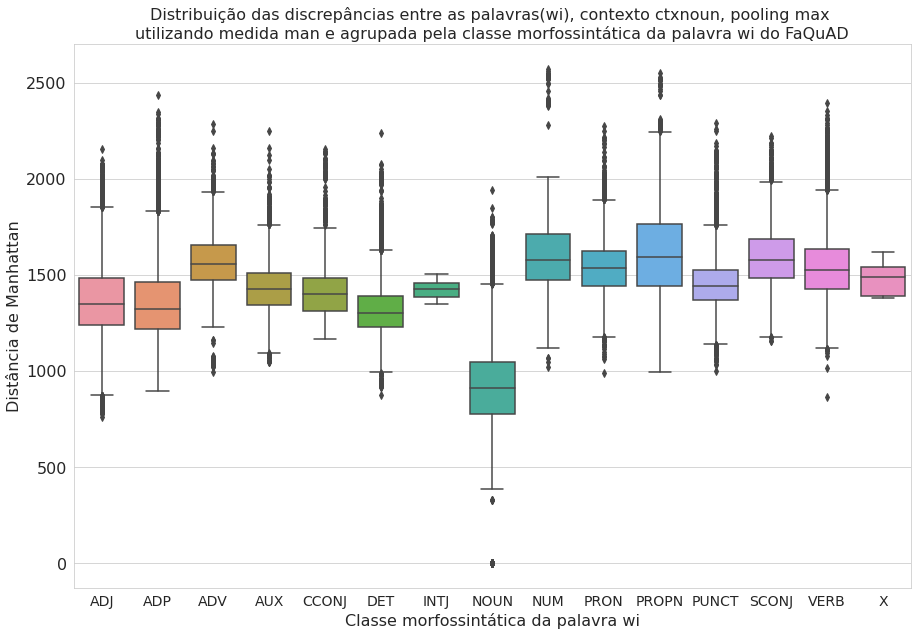

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

In [ ]:
equacao_medida = "ctxverbnoun"

#### COS

In [ ]:
medida = "cos"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   12095.000000 0.752973 0.046671 0.521054 0.723253 0.754644 0.784570   
ADP   33422.000000 0.735451 0.058712 0.393465 0.707376 0.745322 0.775222   
ADV    4464.000000 0.732071 0.048293 0.534301 0.704823 0.738569 0.765064   
AUX    9369.000000 0.857925 0.049780 0.690401 0.827696 0.855385 0.885795   
CCONJ  1406.000000 0.465472 0.280196 0.079173 0.156261 0.647714 0.726466   
DET   25530.000000 0.766106 0.049471 0.526801 0.734256 0.769984 0.801308   
INTJ     22.000000 0.699009 0.014688 0.677915 0.688116 0.697253 0.708199   
NOUN  47221.000000 0.841426 0.046028 0.592524 0.812053 0.843506 0.872390   
NUM     871.000000 0.704476 0.045404 0.563957 0.678443 0.704749 0.732423   
PRON  16927.000000 0.720949 0.045591 0.518180 0.693302 0.723904 0.751978   
PROPN  8365.000000 0.661896 0.073998 0.375438 0.619643 0.668121 0.713638   
PUNCT 19530.000000 0.725836 0.046416 0.046383 0.701272 0.729964 0.754531   
SCONJ  4485.000000 0.716043 0.050862 0.543361 0.681026 0.721122 0.753099   
VERB  20191.000000 0.847291 0.048984 0.573206 0.818776 0.846567 0.875405   
X         5.000000 0.700951 0.018728 0.675270 0.691462 0.700671 0.715139   

           max  
pos_i           
ADJ   0.911387  
ADP   0.870048  
ADV   0.877554  
AUX   1.000000  
CCONJ 0.798841  
DET   0.898433  
INTJ  0.737239  
NOUN  1.000000  
NUM   0.844018  
PRON  0.885224  
PROPN 0.840918  
PUNCT 0.844746  
SCONJ 0.848861  
VERB  1.000000  
X     0.722212

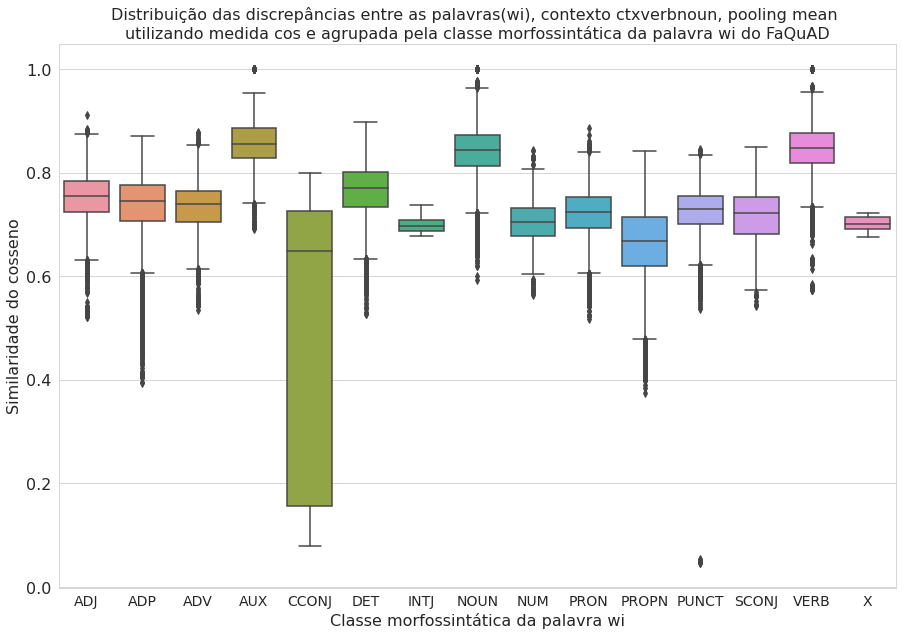

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#      avg      std      min      25%      50%      75%  \
pos_i                                                                      
ADJ   12095.000000 0.729783 0.056411 0.492318 0.698838 0.735480 0.767781   
ADP   33422.000000 0.735451 0.058712 0.393465 0.707376 0.745322 0.775222   
ADV    4464.000000 0.730565 0.049040 0.534301 0.703117 0.737427 0.764361   
AUX    9369.000000 0.857925 0.049780 0.690401 0.827696 0.855385 0.885795   
CCONJ  1406.000000 0.461036 0.280151 0.079173 0.156261 0.647714 0.726466   
DET   25530.000000 0.763602 0.051431 0.526801 0.730067 0.767918 0.800764   
INTJ     22.000000 0.699009 0.014688 0.677915 0.688116 0.697253 0.708199   
NOUN  47221.000000 0.830249 0.057574 0.539717 0.799203 0.837649 0.869025   
NUM     871.000000 0.676908 0.084905 0.374405 0.645437 0.692352 0.730577   
PRON  16927.000000 0.720012 0.045724 0.518180 0.692244 0.723479 0.751262   
PROPN  8365.000000 0.617791 0.077342 0.352262 0.565290 0.623065 0.669335   
PUNCT 19530.000000 0.725836 0.046416 0.046383 0.701272 0.729964 0.754531   
SCONJ  4485.000000 0.716043 0.050862 0.543361 0.681026 0.721122 0.753099   
VERB  20191.000000 0.837960 0.057500 0.528096 0.808048 0.840460 0.871928   
X         5.000000 0.700951 0.018728 0.675270 0.691462 0.700671 0.715139   

           max  
pos_i           
ADJ   0.911387  
ADP   0.870048  
ADV   0.877554  
AUX   1.000000  
CCONJ 0.798841  
DET   0.898433  
INTJ  0.737239  
NOUN  1.000000  
NUM   0.844018  
PRON  0.885224  
PROPN 0.820403  
PUNCT 0.844746  
SCONJ 0.848861  
VERB  1.000000  
X     0.722212

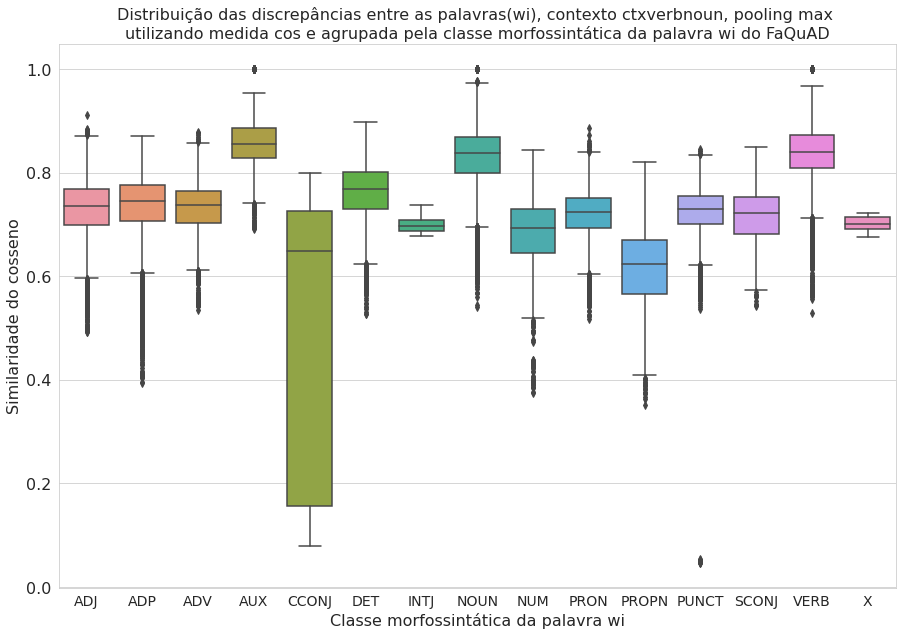

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Similaridade do cosseno")

# Mostra o gráfico
plt.show()

#### EUC

In [ ]:
medida = "euc"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   12095.000000 26.625311 3.765941 17.057652 24.101817 26.363783 28.594141   
ADP   33422.000000 26.965194 3.327088 18.855675 24.704438 26.420732 28.543073   
ADV    4464.000000 28.572408 3.432220 18.771376 26.134254 28.155187 30.531613   
AUX    9369.000000 19.400247 4.835327  0.000000 17.867582 19.997614 21.982771   
CCONJ  1406.000000 32.619794 5.963651 22.416420 26.854198 31.267594 38.042892   
DET   25530.000000 24.924805 2.876403 15.924151 22.971263 24.742813 26.758702   
INTJ     22.000000 29.490039 1.189889 27.721729 28.490050 29.558332 30.332058   
NOUN  47221.000000 20.882385 3.485698  0.000000 18.789530 20.833269 22.865572   
NUM     871.000000 30.051409 3.524115 19.991943 27.338514 29.924635 32.253130   
PRON  16927.000000 27.766689 2.735075 17.233864 25.945810 27.592142 29.265456   
PROPN  8365.000000 30.218195 4.125991 21.168777 27.376896 29.748468 32.516331   
PUNCT 19530.000000 26.818802 2.695201 19.585373 25.154436 26.442734 27.984201   
SCONJ  4485.000000 28.441397 2.976710 20.235411 26.323908 28.269285 30.403900   
VERB  20191.000000 22.240978 4.932912  0.000000 19.990830 22.333448 24.858289   
X         5.000000 32.504706 1.630280 30.714544 31.619909 31.798239 33.733044   

            max  
pos_i            
ADJ   44.147335  
ADP   47.384819  
ADV   46.853817  
AUX   42.711033  
CCONJ 44.752380  
DET   47.091919  
INTJ  31.685789  
NOUN  39.103588  
NUM   43.188549  
PRON  46.561028  
PROPN 51.320911  
PUNCT 45.125347  
SCONJ 43.393200  
VERB  42.891533  
X     34.657795

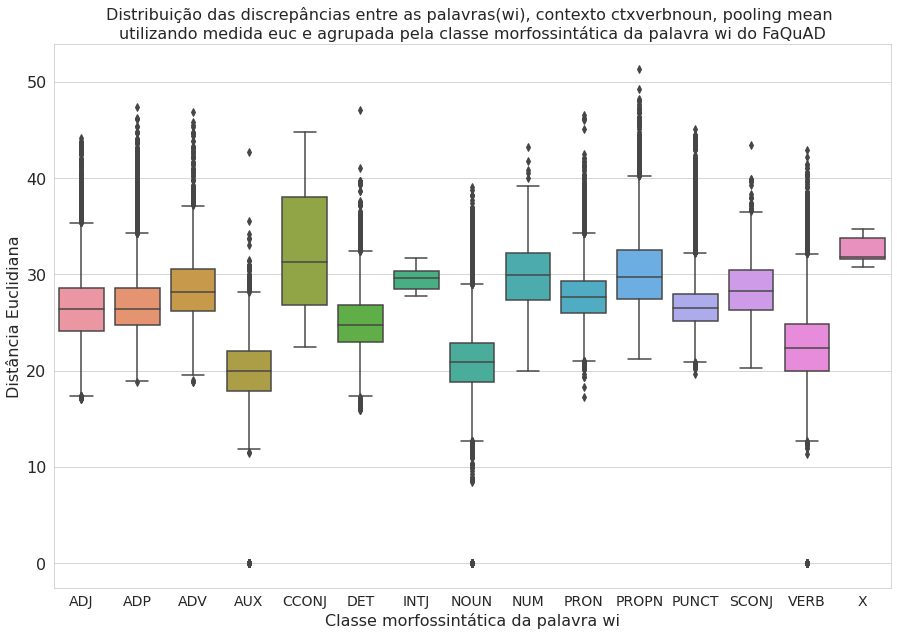

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas.
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#       avg      std       min       25%       50%       75%  \
pos_i                                                                           
ADJ   12095.000000 28.075742 3.597981 17.130932 25.710613 27.678616 30.025210   
ADP   33422.000000 26.965194 3.327088 18.855675 24.704438 26.420732 28.543073   
ADV    4464.000000 28.662597 3.426760 18.771376 26.193027 28.302329 30.676353   
AUX    9369.000000 19.400247 4.835327  0.000000 17.867582 19.997614 21.982771   
CCONJ  1406.000000 32.859259 6.006521 22.416420 26.966758 31.912361 38.108393   
DET   25530.000000 25.084606 2.985530 15.924151 23.023094 24.875255 27.001064   
INTJ     22.000000 29.490039 1.189889 27.721729 28.490050 29.558332 30.332058   
NOUN  47221.000000 21.651228 3.901036  0.000000 19.215326 21.414747 23.910856   
NUM     871.000000 32.092682 5.230248 19.991943 29.169906 31.691992 34.821367   
PRON  16927.000000 27.828654 2.727574 17.233864 25.978526 27.624630 29.336477   
PROPN  8365.000000 32.868594 4.185765 21.653017 30.086023 32.651478 35.486713   
PUNCT 19530.000000 26.818802 2.695201 19.585373 25.154436 26.442734 27.984201   
SCONJ  4485.000000 28.441397 2.976710 20.235411 26.323908 28.269285 30.403900   
VERB  20191.000000 22.939103 5.086200  0.000000 20.669161 23.065807 25.664006   
X         5.000000 32.504706 1.630280 30.714544 31.619909 31.798239 33.733044   

            max  
pos_i            
ADJ   44.147335  
ADP   47.384819  
ADV   46.853817  
AUX   42.711033  
CCONJ 44.752380  
DET   47.091919  
INTJ  31.685789  
NOUN  39.489048  
NUM   50.453609  
PRON  46.561028  
PROPN 51.320911  
PUNCT 45.125347  
SCONJ 43.393200  
VERB  42.891533  
X     34.657795

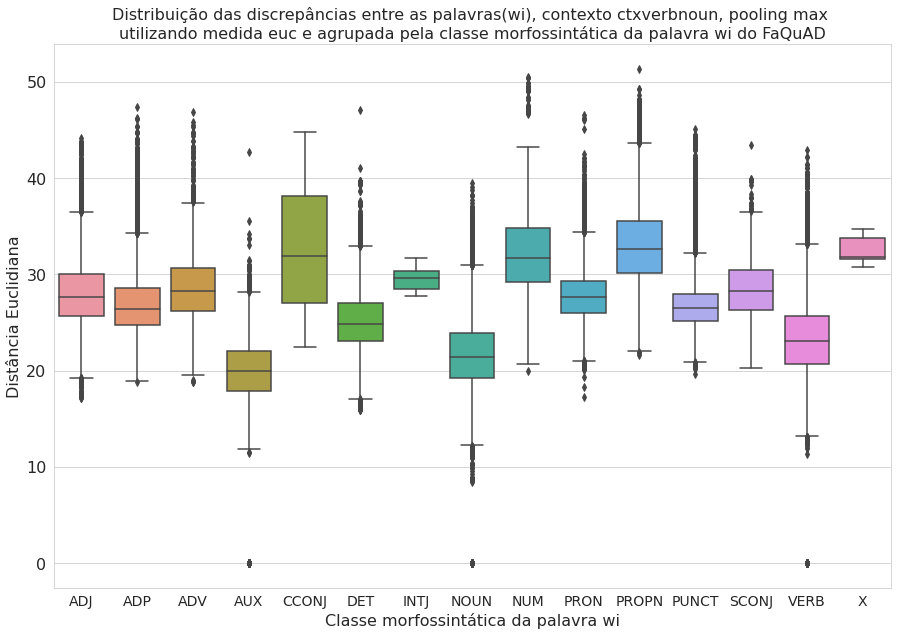

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

# Mostra o gráfico
plt.show()

#### MAN

In [ ]:
medida = "man"

##### MEAN

In [ ]:
estrategia_medida = "mean"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   12095.000000 1254.932207 168.830546  790.855164 1138.142700 1243.597412   
ADP   33422.000000 1311.949544 161.057125  927.604736 1201.470001 1283.758423   
ADV    4464.000000 1376.535008 153.555314  906.845337 1266.959076 1361.302856   
AUX    9369.000000  931.318181 233.681179    0.000000  853.729858  960.680664   
CCONJ  1406.000000 1323.290651 129.394461 1084.568970 1236.529694 1292.745117   
DET   25530.000000 1209.105814 134.955471  772.356812 1118.844116 1201.418640   
INTJ     22.000000 1420.989191  46.896612 1349.718140 1381.608276 1426.195679   
NOUN  47221.000000  987.474733 160.545961    0.000000  891.371521  985.554443   
NUM     871.000000 1432.459551 150.678361  990.156189 1319.020630 1439.099976   
PRON  16927.000000 1352.449429 133.068329  855.255371 1263.455811 1345.243896   
PROPN  8365.000000 1425.789075 188.660292  999.123535 1293.674316 1407.951172   
PUNCT 19530.000000 1313.114451 114.771944  952.838013 1236.901825 1299.829773   
SCONJ  4485.000000 1393.825334 146.695635  994.756348 1288.252197 1385.634521   
VERB  20191.000000 1057.391125 227.301268    0.000000  954.668671 1066.966553   
X         5.000000 1459.223828  73.314777 1387.878906 1408.612549 1441.415771   

              75%         max  
pos_i                          
ADJ   1356.460876 1954.200684  
ADP   1388.740570 2228.859863  
ADV   1469.929016 2032.410400  
AUX   1053.801514 1842.073975  
CCONJ 1386.342102 1843.912598  
DET   1292.179657 2029.195801  
INTJ  1455.250397 1503.175537  
NOUN  1080.979492 1761.926758  
NUM   1539.624634 1884.695312  
PRON  1427.045532 2164.633301  
PROPN 1533.113281 2233.275146  
PUNCT 1375.275055 2043.019897  
SCONJ 1492.516479 1921.609497  
VERB  1183.598816 2030.208618  
X     1485.721191 1572.490723

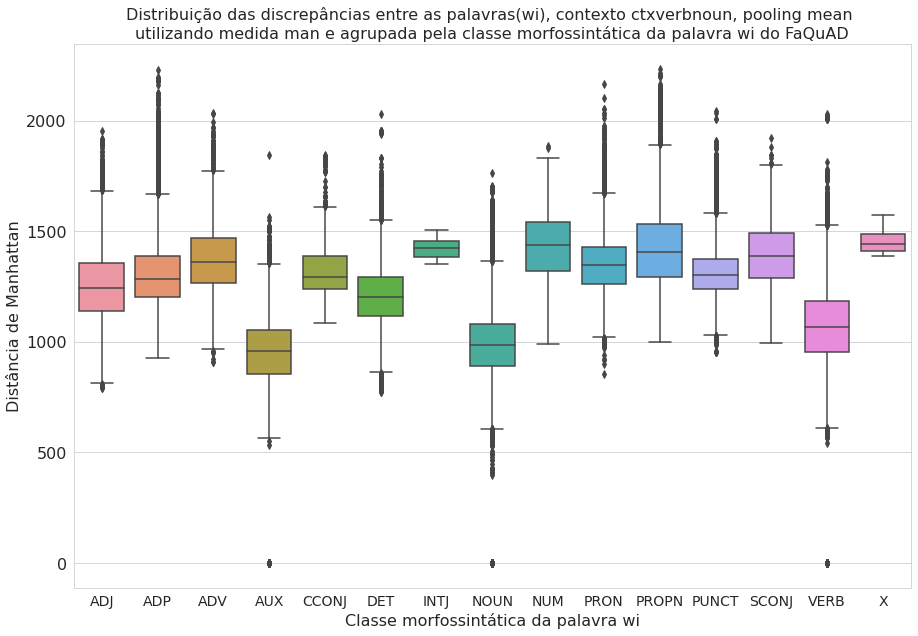

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

##### MAX

In [ ]:
estrategia_medida = "max"
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("display.float_format", lambda x: "%.6f" % x)

# Agrupamento dos dados
lista = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao]

# Exibe as estatísticas
lista.describe().rename(columns={"count": "#","mean": "avg"})

#         avg        std         min         25%         50%  \
pos_i                                                                           
ADJ   12095.000000 1321.833034 160.728006  790.855164 1216.592041 1305.893677   
ADP   33422.000000 1311.949544 161.057125  927.604736 1201.470001 1283.758423   
ADV    4464.000000 1380.931791 152.885977  906.845337 1270.543549 1367.437561   
AUX    9369.000000  931.318181 233.681179    0.000000  853.729858  960.680664   
CCONJ  1406.000000 1333.311813 138.940678 1084.568970 1239.880432 1297.956970   
DET   25530.000000 1216.573402 139.776947  772.356812 1121.126984 1207.574951   
INTJ     22.000000 1420.989191  46.896612 1349.718140 1381.608276 1426.195679   
NOUN  47221.000000 1023.566333 181.751252    0.000000  911.343079 1011.180969   
NUM     871.000000 1536.262917 258.661902  990.156189 1403.951538 1508.867920   
PRON  16927.000000 1355.097899 132.374306  855.255371 1264.552002 1346.988770   
PROPN  8365.000000 1552.691487 201.618388 1027.920898 1410.801758 1537.263428   
PUNCT 19530.000000 1313.114451 114.771944  952.838013 1236.901825 1299.829773   
SCONJ  4485.000000 1393.825334 146.695635  994.756348 1288.252197 1385.634521   
VERB  20191.000000 1090.826243 237.848503    0.000000  984.913757 1098.828613   
X         5.000000 1459.223828  73.314777 1387.878906 1408.612549 1441.415771   

              75%         max  
pos_i                          
ADJ   1406.752991 2065.299805  
ADP   1388.740570 2228.859863  
ADV   1474.099915 2032.410400  
AUX   1053.801514 1842.073975  
CCONJ 1393.589844 1843.912598  
DET   1304.671600 2029.195801  
INTJ  1455.250397 1503.175537  
NOUN  1129.727173 1946.494629  
NUM   1635.632141 2518.620850  
PRON  1429.576294 2164.633301  
PROPN 1686.189331 2286.414062  
PUNCT 1375.275055 2043.019897  
SCONJ 1492.516479 1921.609497  
VERB  1219.963135 2168.713379  
X     1485.721191 1572.490723

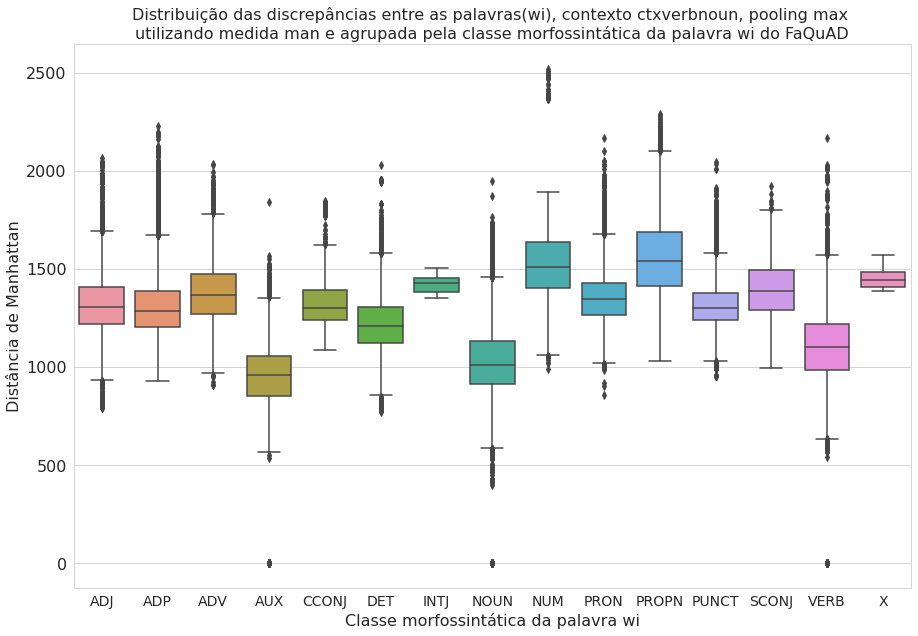

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Estilo do gráfico
sns.set_style("whitegrid")

# Define o tamanho do gráfico 
fig = plt.figure(figsize =(15, 10))

# Encontra a ordem do eixo y
ordem = lista_comparacao_contexto.groupby(by=["pos_i"])[coluna_equacao].median().iloc[::].index

# Insere os dados no gráfico
sns.boxplot(x = "pos_i", y = coluna_equacao, data = lista_comparacao_contexto, order = ordem)

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras(wi), contexto " + equacao_medida + ", pooling " + estrategia_medida + " \nutilizando medida " + medida + " e agrupada pela classe morfossintática da palavra wi do FaQuAD")
# Texto do eixo x
plt.xlabel("Classe morfossintática da palavra wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

# Mostra o gráfico
plt.show()

## 3.5 Estatísticas das discrepâncias do contexto e palavras

### Geral

Conta pares de classes de palavras

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_bar = tqdm_notebook(lista_comparacao_contexto.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_contexto))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_bar:  
  #if i < 10:             
    contador[linha_comparacao[4]] += 1

Documentos:   0%|          | 0/204582 [00:00<?, ? documento/s]

Ordenada as contagens dos pares

In [ ]:
top = 10
dicdados = {}
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    dicdados.update({item: contador[item]})    

Mostra o gráfico

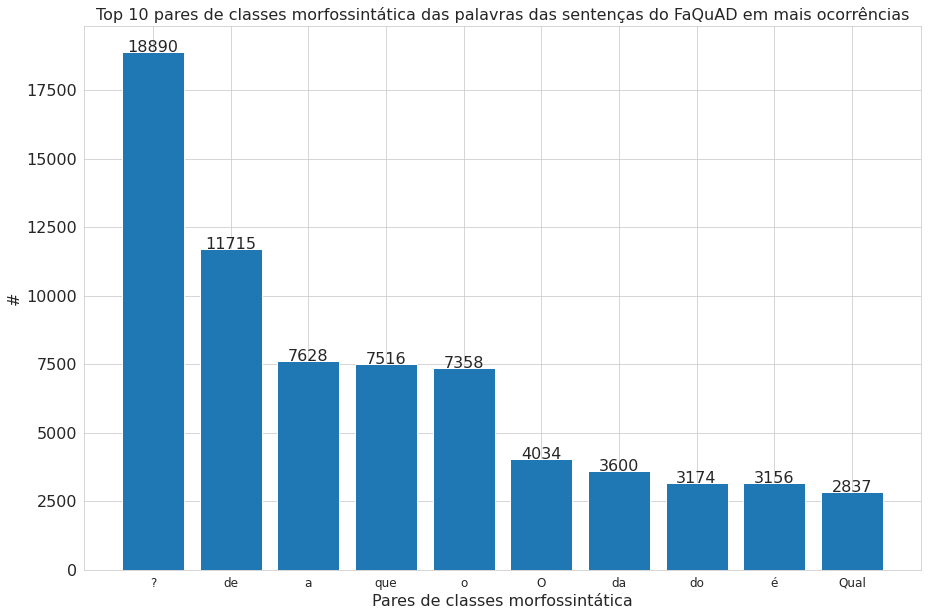

In [ ]:
# Import da biblioteca
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
plt.figure(figsize =(15, 10))

# Recupera os rótulos e os valores
rotulos = list(dicdados.keys())
valores = list(dicdados.values())

# Título do gráfico
plt.title("Top 10 pares de classes morfossintática das palavras das sentenças do FaQuAD em mais ocorrências")
# Texto do eixo x
plt.xlabel("Pares de classes morfossintática")
# Texto do eixo y
plt.ylabel("#")

# Insere os dados no gráfico
plt.bar(rotulos, valores)

plt.xticks(fontsize=12)

# Adiciona os rótulos as barras
for i in range(len(valores)):
  plt.annotate(str(valores[i]), xy = (rotulos[i], valores[i]), ha = "center")

# Mostra o gráfico
plt.show()

### Contexto com todas as palavras (ctxall)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 20191


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean" ,"euc_ctxall_mean",
                          "man_ctxall_max"  ,"cos_ctxall_max",
                          "euc_ctxall_max"  ,"man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_max  cos_ctxall_max  \
count     20191.000000     20191.000000    20191.000000    20191.000000   
mean          0.801818        25.342731     1237.449344        0.792566   
std           0.043271         4.183447      164.148036        0.043516   
min           0.539066        10.446237      790.707300        0.539066   
25%           0.775151        22.627509     1127.367400        0.767856   
50%           0.802977        25.099951     1225.216600        0.795499   
75%           0.830286        27.690548     1334.234150        0.821356   
max           0.958278        45.165359     2123.833000        0.909189   

       euc_ctxall_max  man_ctxall_max  
count    20191.000000    20191.000000  
mean        26.033440     1237.449344  
std          3.819571      164.148036  
min         16.289457      790.707300  
25%         23.464928     1127.367400  
50%         25.667862     1225.216600  
75%         28.096280     1334.234150  
max         45.165359     2123.833000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/20191 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2 3461
      2        4 2854
      3        3 2484
      4        5 2171
      5        6 2020
      6        1 1677
      7        7 1516
      8        8 1004
      9        9  741
     10       10  534
     11       11  364
     12       12  338
     13       13  300
     14       14  274
     15       15  113
     16       16   81
     17        0   51
     18       20   42
     19       18   42
     20       41   21


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.055134981870651245
Limite superior             : 0.9129880517721176
Limite inferior             : 0.6924481242895126


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 66 de 20191 ( 0.0032687831211926106 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 214 de 20191 ( 0.010598781635382101 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  280 de 20191 ( 0.013867564756574711 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.958277702331543 logarítmos
         Quem controla os logarítmos ?

 2 0.956552267074585 logarítmos
         Quem fez os logarítmos ?

 3 0.9556065201759338 logarítmos
         Quem faz os logarítmos ?

 4 0.9554635286331176 logarítmos
         Quem tem os logarítmos ?

 5 0.9547964334487916 logarítmos
         Quem disse os logarítmos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5390658974647522 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.5406664609909058 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornam em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.5410881042480469 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornarem em fatos que beneficiarão os moradores de Brasília ” ?

 4 0.54162

###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que quer acontecer quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?
       1 0.8065980672836304 opta
       2 0.7594416737556458 avaliar
       3 0.7537314295768738 acontecer
       4 0.6920862793922424 quer

 2 Como o Ministério da Educação e Saúde começa a se chamar depois que o governo federal criou o Ministério da Saúde ?
       1 0.7943553328514099 começa
       2 0.7655430436134338 criou
       3 0.6920596957206726 chamar

 3 O que acontece caso o Aluno Especial não faça o aproveitamento das duas disciplinas cursadas até a data de matrícula ?
       1 0.8268032073974609 cursadas
       2 0.7609674334526062 faça
       3 0.6913400888442993 acontece

 4 O que acontece caso o Aluno Especial não obteve o aproveitamento das duas disciplinas cursadas até a data de matrícula ?
       1 0.8334767818450928 cursadas
       2 0.7323358654975891 obteve
       3 0.6912845969200134 acontece

 5 como é realizada a seleção de alunos para uma dis

##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05349990725517273
Limite superior             : 0.9016055315732956
Limite inferior             : 0.6876059025526047


Encontra os documentos com as maiores similaridades (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 10 de 20191 ( 0.0004952701698776683 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 358 de 20191 ( 0.017730672081620526 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  368 de 20191 ( 0.018225942251498192 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.909189224243164 fez
         Quem fez a academia ?

 2 0.9081903100013732 quer
         Quem quer a academia ?

 3 0.9080277681350708 tem
         Quem tem os programas ?

 4 0.9069225788116456 pode
         Como o tema pode ser procurado ?

 5 0.906460165977478 faz
         Quem faz a academia ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5390658974647522 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.5406664609909058 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornam em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.5410881042480469 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornarem em fatos que beneficiarão os moradores de Brasília ” ?

 4 0.54162

###### Top 5 documentos com as discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como o Ministério da Educação e Saúde começou a se chamar depois que o governo federal criou o Ministério da Saúde ?
       1 0.7888001799583435 começou
       2 0.7559409737586975 criou
       3 0.6874903440475464 chamar

 2 O que quer ver quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?
       1 0.7639180421829224 avaliar
       2 0.7487123608589172 opta
       3 0.7320135235786438 ver
       4 0.687434196472168 quer

 3 Qual curso foi produzido através da parceria entre a Escola de Engenharia de São Carlos e o Instituto de Ciências Matemáticas e de Computação da Universidade de São Paulo ?
       1 0.6873183250427246 produzido

 4 Quem é considerado o autor da frase ” Ciência da Computação tem tanto a oferecer com o computador como a astronomia com o telescópio [ … ] " ?
       1 0.7990624308586121 tem
       2 0.7634196877479553 considerado
       3 0.6872925162315369 oferecer

 5 De quem foram as palavras “ Há pouco tempo não passav

##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.063038825988773
Limite superior             : 35.285106182098396
Limite inferior             : 15.032950878143305


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 427 de 20191 ( 0.021148036253776436 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 66 de 20191 ( 0.0032687831211926106 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  493 de 20191 ( 0.024416819374969045 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 45.16535949707031 Havia
         Quantos membros Havia no corpo docente do curso de Engenharia de Computação da UNIVASF em 2008 ?

 2 44.73481369018555 ia
         O que quer ia quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?

 3 43.89828109741211 comer
         O que comer se houver mais de uma turma ofertada para uma mesma disciplina ?

 4 43.72631072998047 ultrapass
         como é realizada a seleção de alunos para uma disciplina cujo número de inscritos ultrapass o número de vagas ?

 5 43.45534896850586 provar
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fatos que beneficiarão os moradores de Brasília ” ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 10.446236610412598 logarítmos
         Quem controla os logarítmos ?

 2 10.801430702209473 logarítmos
         Quem lê os logarítmos ?

 3 10.849260330200195 logarítmos
         Quem escreve os logarítmos ?

 4 10.870257377624512 logarítmos
         Quem eram os logarítmos ?

 5 10.908831596374512 logarítmos
         Quem escreveu os logarítmos ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quantos membros Havia no corpo docente do curso de Engenharia de Computação da UNIVASF em 2008 ?
       1 45.16535949707031 Havia

 2 O que quer ia quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?
       1 44.73481369018555 ia
       2 34.74332809448242 quer
       3 24.45781135559082 avaliar
       4 22.898521423339844 opta

 3 O que comer se houver mais de uma turma ofertada para uma mesma disciplina ?
       1 43.89828109741211 comer
       2 24.30533599853516 houver
       3 19.022680282592773 ofertada

 4 como é realizada a seleção de alunos para uma disciplina cujo número de inscritos ultrapass o número de vagas ?
       1 43.72631072998047 ultrapass
       2 30.480792999267575 realizada

 5 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fat

##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.631352424621582
Limite superior             : 35.0433087348938
Limite inferior             : 16.51789903640747


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 521 de 20191 ( 0.025803575850626516 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3 de 20191 ( 0.00014858105096330048 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  524 de 20191 ( 0.025952156901589817 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 45.16535949707031 Havia
         Quantos membros Havia no corpo docente do curso de Engenharia de Computação da UNIVASF em 2008 ?

 2 44.73481369018555 ia
         O que quer ia quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?

 3 43.89828109741211 comer
         O que comer se houver mais de uma turma ofertada para uma mesma disciplina ?

 4 43.72631072998047 ultrapass
         como é realizada a seleção de alunos para uma disciplina cujo número de inscritos ultrapass o número de vagas ?

 5 43.45534896850586 provar
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fatos que beneficiarão os moradores de Brasília ” ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 16.289457321166992 pode
         Como o tema pode ser procurado ?

 2 16.436811447143555 pode
         O que pode representar um professor ?

 3 16.48267936706543 recebe
         Quem recebe os programas ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quantos membros Havia no corpo docente do curso de Engenharia de Computação da UNIVASF em 2008 ?
       1 45.16535949707031 Havia

 2 O que quer ia quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?
       1 44.73481369018555 ia
       2 34.74332809448242 quer
       3 27.001150131225582 opta
       4 24.45781135559082 avaliar

 3 O que comer se houver mais de uma turma ofertada para uma mesma disciplina ?
       1 43.89828109741211 comer
       2 24.80457305908203 ofertada
       3 24.30533599853516 houver

 4 como é realizada a seleção de alunos para uma disciplina cujo número de inscritos ultrapass o número de vagas ?
       1 43.72631072998047 ultrapass
       2 30.480792999267575 realizada

 5 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fato

##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 223.73590000000013
Limite superior             : 1648.6101500000002
Limite inferior             : 753.6665499999997


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 222 de 20191 ( 0.010994997771284236 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 101 de 20191 ( 0.0050022287157644495 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  323 de 20191 ( 0.015997226487048686 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2096.3018 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2080.0393 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituem em fatos que beneficiarão os moradores de Brasília ” ?

 3 2078.6716 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se apresentam em fatos que beneficiarão os moradores de Brasília ” ?

 4 2077.9302 Há
         De que

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 507.4464 logarítmos
         Quem controla os logarítmos ?

 2 529.46924 logarítmos
         Quem lê os logarítmos ?

 3 534.6355 logarítmos
         Quem eram os logarítmos ?

 4 534.9691 logarítmos
         Quem disse os logarítmos ?

 5 535.2772 logarítmos
         Quem fez os logarítmos ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2096.3018 Há
       2 1839.5706 passava
       3 1219.2422 financiadas
       4 1215.3572 beneficiarão
       5 1153.0365 constituírem-se

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituem em fatos que beneficiarão os moradores de Brasília ” ?
       1 2080.0393 Há
       2 1817.771 passava
       3 1636.2045 constituem
       4 1214.9636 beneficiarão
       5 1200.3026 financiadas

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irr

##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 206.8667499999999
Limite superior             : 1644.534275
Limite inferior             : 817.0672750000002


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 297 de 20191 ( 0.014709524045366748 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 9 de 20191 ( 0.00044574315288990144 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  306 de 20191 ( 0.015155267198256649 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2123.833 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2096.3018 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 2080.0393 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituem em fatos que beneficiarão os moradores de Brasília ” ?

 4 2078.6716 Há
    

###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 790.7073 pode
         Como o tema pode ser procurado ?

 2 794.21924 pode
         O que pode representar um professor ?

 3 798.4877 recebe
         Quem recebe os programas ?

 4 801.66296 quer
         Quem quer a academia ?

 5 806.6969 pode
         O que pode ser um professor ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2123.833 constituírem-se
       2 2096.3018 Há
       3 1839.5706 passava
       4 1501.3914 financiadas
       5 1478.8793 beneficiarão

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2123.833 constituírem-se
       2 2096.3018 Há
       3 1839.5706 passava
       4 1501.3914 financiadas
       5 1478.8793 beneficiarão

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade 

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 47221


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean", "cos_ctxall_max","euc_ctxall_max","man_ctxall_max"]].describe(include=["float", "int"]) 

cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxall_max  \
count     47221.000000     47221.000000     47221.000000    47221.000000   
mean          0.800695        23.276385      1099.016163        0.789511   
std           0.041982         3.206298       143.600945        0.042649   
min           0.599897        10.244466       494.070370        0.580504   
25%           0.776271        21.360081      1013.065060        0.765321   
50%           0.802795        23.058807      1088.969600        0.794587   
75%           0.828058        25.051912      1181.370600        0.819386   
max           0.953742        43.424953      1996.594200        0.908355   

       euc_ctxall_max  man_ctxall_max  
count    47221.000000    47221.000000  
mean        24.053537     1136.026107  
std          2.933351      133.952150  
min         15.810619      758.468260  
25%         22.029222     1042.240600  
50%         23.716198     1118.981900  
75%         25.652149     1210.973900  
max         43.424953     1996.594200

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/47221 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3 6170
      2        5 5704
      3        4 5160
      4        6 4404
      5        2 4282
      6        7 4051
      7        8 3673
      8        9 3090
      9        1 2495
     10       10 1670
     11       11 1613
     12       12 1167
     13       13  914
     14       14  628
     15       15  441
     16       17  399
     17       16  314
     18        0  289
     19       18  189
     20       19  147


##### COS - MEAN

In [ ]:
medida = "cos_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05178755521774292
Limite superior             : 0.9057393968105316
Limite inferior             : 0.6985891759395599


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 365 de 47221 ( 0.007729611825247242 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 706 de 47221 ( 0.014950975201711103 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1071 de 47221 ( 0.022680587026958344 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9537418484687804 logaritmo
         Quem fez o logaritmo ?

 2 0.9495340585708618 logaritmo
         Quem escreve o logaritmo ?

 3 0.9488868713378906 logaritmo
         Quem faz o logaritmo ?

 4 0.948474109172821 logaritmo
         Quem escreveu o logaritmo ?

 5 0.9476627707481384 logaritmo
         Quem disse o logaritmo ?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5998973846435547 matéria
         O que nem sempre são pequenos na matéria de tecnologia ?

 2 0.6122053265571594 sonho
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 0.6160096526145935 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 4 0.6186012625694275 sonho
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os result

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quem Deve ser consultado em caso de dúvidas quanto ao enquadramento do laudo médico ?
       1 0.811126172542572 enquadramento
       2 0.7646664977073669 laudo
       3 0.7491436004638672 caso
       4 0.6984798312187195 dúvidas

 2 Qual curso foi disponibilizado através da parceria entre a Escola de Engenharia de São Carlos e o Instituto de Ciências Matemáticas e de Computação da Universidade de São Paulo ?
       1 0.6984645128250122 curso
       2 0.6504220366477966 parceria

 3 Pelo que faziam os membros do corpo docente antes de serem designados Maître de conférences ?
       1 0.7537943720817566 membros
       2 0.6983446478843689 corpo

 4 Quais atividades foram destinadas ao MEC em 8 de novembro de 1990 ?
       1 0.8262384533882141 atividades
       2 0.6983185410499573 novembro

 5 o que fazem com o acadêmico com vínculo trancado em caso de não renovação de sua matrícula no semestre seguinte ?
       1 0.7945078611373901 vínculo
       2 0.763550877571106 matrícula
     

##### COS - MAX

In [ ]:
medida = "cos_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.054065585136413574
Limite superior             : 0.900484561920166
Limite inferior             : 0.6842222213745117


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 15 de 47221 ( 0.0003176552804896127 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 884 de 47221 ( 0.01872048453018784 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  899 de 47221 ( 0.01903813981067745 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9083553552627563 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 0.908000946044922 cursos
         Os cursos de pós-graduação – quais cursos ?

 3 0.9076331257820128 cursos
         Os cursos de pós-graduação ou quais cursos ?

 4 0.9069178700447084 cursos
         Os cursos de pós-graduação , quais cursos ?

 5 0.9042109847068788 cursos
         Os cursos de pós-graduação : quais cursos ?


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxall) > limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5805038809776306 colação
         Em qual ano os alunos de colação de grau poderão ser nomeados em disciplinas sem que tenham cumprido todos os pré-requisitos ?

 2 0.5818522572517395 colação
         Em qual ano os alunos de colação de grau poderão ser voluntários em disciplinas sem que tenham cumprido todos os pré-requisitos ?

 3 0.5831828117370605 colação
         Em qual ano os alunos de colação de grau poderão ser professores em disciplinas sem que tenham cumprido todos os pré-requisitos ?

 4 0.5834878087043762 colação
         Em qual ano os alunos de colação de grau poderão ser contratados em disciplinas sem que tenham cumprido todos os pré-requisitos ?

 5 0.5851916670799255 colação
         Em qual ano os alunos de colação de grau poderão ser substituídos em disciplinas sem que tenham cumprido todos os pré-requisitos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxall) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 por meio de quem as instituições de ensino superior devem estabelecer as atribuições e os critérios de constituição do nde ?
       1 0.7768793106079102 constituição
       2 0.7642168402671814 atribuições
       3 0.7577944993972778 instituições
       4 0.7222410440444946 critérios
       5 0.7197281718254089 nde
       6 0.6841664910316467 ensino
       7 0.6786739230155945 meio

 2 A FAPDF financia projetos de pesquisa em parceria com quem?
       1 0.8178340196609497 projetos
       2 0.7916414141654968 parceria
       3 0.7684420347213745 pesquisa
       4 0.6841664910316467 FAPDF

 3 A FAPDF financia projetos de pesquisa em parceria com quem ?
       1 0.8178340196609497 projetos
       2 0.7916414141654968 parceria
       3 0.7684420347213745 pesquisa
       4 0.6841664910316467 FAPDF

 4 Por quem foi definida a profissão de tecnólogo em análise e desenvolvimento de sistemas ?
       1 0.7558598518371582 profissão
       2 0.7312189936637878 tecnólogo
       3 0.72215723991

##### EUC - MEAN

In [ ]:
medida = "euc_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.6918315887451136
Limite superior             : 30.589659690856926
Limite inferior             : 15.82233333587647


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1149


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 639 de 47221 ( 0.013532114948857499 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1788 de 47221 ( 0.03786450943436183 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 43.42495346069336 migração
         Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?

 2 42.74262237548828 conversão
         Quando a renovação de matrícula é conversão em trancamento ?

 3 42.14496994018555 Dura
         Quantas horas Dura cada reunião de participação em órgãos colegiados ?

 4 41.86570358276367 Dar
         Onde uma pessoa deve Dar aula para ser considerada professor nos Estados Unidos ?

 5 41.54684066772461 migração
         Quem elabora o plano de estudos do acadêmico quando do migração para uma nova matriz curricular ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 10.244465827941896 logaritmo
         Quem fez o logaritmo ?

 2 10.731985092163086 logaritmo
         Quem faz o logaritmo ?

 3 10.735795021057127 logaritmo
         Quem escreve o logaritmo ?

 4 10.760848999023438 logaritmo
         Quem disse o logaritmo ?

 5 10.845253944396973 logaritmo
         Quem construiu o logaritmo ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?
       1 43.42495346069336 migração
       2 24.941015243530277 plano
       3 24.589088439941406 estudos
       4 23.78008270263672 acadêmico
       5 23.1647891998291 matriz

 2 Quando a renovação de matrícula é conversão em trancamento ?
       1 42.74262237548828 conversão
       2 23.26286506652832 renovação
       3 22.53622055053711 matrícula
       4 14.20267391204834 trancamento

 3 Quantas horas Dura cada reunião de participação em órgãos colegiados ?
       1 42.14496994018555 Dura
       2 23.71515846252441 órgãos
       3 21.689607620239254 horas
       4 21.56971740722656 participação
       5 20.41182327270508 reunião

 4 Onde uma pessoa deve Dar aula para ser considerada professor nos Estados Unidos ?
       1 41.86570358276367 Dar
       2 24.85677719116211 aula
       3 23.2969913482666 pessoa
       4 23.00839614868164 professor
       5 22.356250762939453 Onde

 5 Q

##### EUC - MAX

In [ ]:
medida = "euc_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.622926712036133
Limite superior             : 31.086539268493652
Limite inferior             : 16.59483242034912


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1159


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 19 de 47221 ( 0.00040236335528684273 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1178 de 47221 ( 0.02494652802778425 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 43.42495346069336 migração
         Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?

 2 42.74262237548828 conversão
         Quando a renovação de matrícula é conversão em trancamento ?

 3 42.14496994018555 Dura
         Quantas horas Dura cada reunião de participação em órgãos colegiados ?

 4 41.86570358276367 Dar
         Onde uma pessoa deve Dar aula para ser considerada professor nos Estados Unidos ?

 5 41.54684066772461 migração
         Quem elabora o plano de estudos do acadêmico quando do migração para uma nova matriz curricular ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 15.810619354248049 cursos
         Os cursos de pós-graduação – quais cursos ?

 2 15.842206001281738 cursos
         Os cursos de pós-graduação e quais cursos ?

 3 15.903451919555664 cursos
         Os cursos de pós-graduação ou quais cursos ?

 4 16.022598266601562 cursos
         Os cursos de pós-graduação , quais cursos ?

 5 16.151941299438477 cursos
         Os cursos de pós-graduação : quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?
       1 43.42495346069336 migração
       2 24.941015243530277 plano
       3 24.589088439941406 estudos
       4 23.78008270263672 acadêmico
       5 23.1647891998291 matriz

 2 Quando a renovação de matrícula é conversão em trancamento ?
       1 42.74262237548828 conversão
       2 25.012868881225582 matrícula
       3 23.26286506652832 renovação
       4 22.81618881225586 trancamento

 3 Quantas horas Dura cada reunião de participação em órgãos colegiados ?
       1 42.14496994018555 Dura
       2 23.71515846252441 órgãos
       3 21.689607620239254 horas
       4 21.56971740722656 participação
       5 20.41182327270508 reunião

 4 Onde uma pessoa deve Dar aula para ser considerada professor nos Estados Unidos ?
       1 41.86570358276367 Dar
       2 24.85677719116211 aula
       3 23.2969913482666 pessoa
       4 23.00839614868164 professor
       5 22.356250762939453 Onde

 5 

##### MAN - MEAN

In [ ]:
medida = "man_ctxall_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 168.30553999999995
Limite superior             : 1433.82891
Limite inferior             : 760.6067500000001


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 918


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 638 de 47221 ( 0.013510937930158192 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1556 de 47221 ( 0.03295144109612249 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1996.5942 teorema
         Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?

 2 1802.8094 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 3 1795.2736 teorema
         Qual teorema sido a definição de conceitos como recursividade e cálculo lambda ?

 4 1753.3336 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 5 1752.5868 bordo
         Qual a base da análise e interpretação dos dados coletados a bordo da observação de fatos e fenômenos exatamente como ocorem realmente ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 494.07037 logaritmo
         Quem fez o logaritmo ?

 2 515.8435 logaritmo
         Quem faz o logaritmo ?

 3 516.41516 logaritmo
         Quem escreve o logaritmo ?

 4 518.2067 logaritmo
         Quem construiu o logaritmo ?

 5 520.63165 logaritmo
         Quem usou o logaritmo ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?
       1 1996.5942 teorema
       2 1249.3411 conceitos
       3 1178.2667 definição
       4 1154.5222 cálculo
       5 860.5133 recursividade

 2 Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?
       1 1802.8094 teorema
       2 1204.3318 conceitos
       3 1150.7839 cálculo
       4 1149.217 definição
       5 845.5349 recursividade

 3 Qual teorema sido a definição de conceitos como recursividade e cálculo lambda ?
       1 1795.2736 teorema
       2 1235.1375 conceitos
       3 1143.152 cálculo
       4 1132.816 definição
       5 850.1208 recursividade

 4 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 1753.333

##### MAN - MAX

In [ ]:
medida = "man_ctxall_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 168.73329999999987
Limite superior             : 1464.0738499999998
Limite inferior             : 789.1406500000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1017


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 12 de 47221 ( 0.0002541242243916901 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1029 de 47221 ( 0.02179115224158743 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1996.5942 teorema
         Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?

 2 1884.062 hindu-arábico
         Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?

 3 1812.3818 hindu-arábico
         Quem foi responsável pela difusão do sistema de numer hindu-arábico no Oriente Médio ?

 4 1802.8094 teorema
         Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?

 5 1795.2736 teorema
         Qual teorema sido a definição de conceitos como recursividade e cálculo lambda ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxall) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 758.46826 cursos
         Os cursos de pós-graduação – quais cursos ?

 2 762.39404 ensino
         Quem busca o ensino superior ?

 3 769.9082 cursos
         Os cursos de pós-graduação e quais cursos ?

 4 770.0963 cursos
         Os cursos de pós-graduação ou quais cursos ?

 5 771.8208 ensino
         Quem escolheu o ensino superior ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxall) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?
       1 1996.5942 teorema
       2 1249.3411 conceitos
       3 1178.2667 definição
       4 1155.3813 recursividade
       5 1154.5222 cálculo

 2 Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?
       1 1884.062 hindu-arábico
       2 1350.3284 difusão
       3 1248.9944 escravidão
       4 1119.7234 sistema

 3 Quem foi responsável pela difusão do sistema de numer hindu-arábico no Oriente Médio ?
       1 1812.3818 hindu-arábico
       2 1418.2998 difusão
       3 1029.9104 sistema

 4 Qual teorema ser a definição de conceitos como recursividade e cálculo lambda ?
       1 1802.8094 teorema
       2 1204.3318 conceitos
       3 1150.7839 cálculo
       4 1149.217 definição
       5 1142.1952 recursividade

 5 Qual teorema sido a definição de conceitos como recursividade e cálculo lambda ?
       1 1795.2736 teorema
       2 1235.1375 conceitos
       3 11

#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB(AUX) e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    lista_comparacao_classesVV[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean","euc_ctxall_mean","man_ctxall_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            VERB  \
      cos_ctxall_mean euc_ctxall_mean man_ctxall_mean cos_ctxall_mean   
count   204582.000000   204582.000000   204582.000000    20191.000000   
mean         0.815145       22.560275     1087.476015        0.801818   
std          0.056515        3.691554      164.264300        0.043271   
min          0.064022       10.244466      494.070370        0.539066   
25%          0.788173       20.110536      979.457212        0.775151   
50%          0.819242       22.229189     1076.404600        0.802977   
75%          0.849261       24.572840     1183.582850        0.830286   
max          0.958278       45.165359     2096.301800        0.958278   

                                                 NOUN                  \
      euc_ctxall_mean man_ctxall_mean cos_ctxall_mean euc_ctxall_mean   
count    20191.000000    20191.000000    47221.000000    47221.000000   
mean        25.342731     1204.052196        0.800695       23.276385   
std          4.183447      178.422974        0.041982        3.206298   
min         10.446237      507.446400        0.599897       10.244466   
25%         22.627509     1089.270400        0.776271       21.360081   
50%         25.099951     1200.591600        0.802795       23.058807   
75%         27.690548     1313.006300        0.828058       25.051912   
max         45.165359     2096.301800        0.953742       43.424953   

                       
      man_ctxall_mean  
count    47221.000000  
mean      1099.016163  
std        143.600945  
min        494.070370  
25%       1013.065060  
50%       1088.969600  
75%       1181.370600  
max       1996.594200

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxall_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxall_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxall_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      cos_ctxall_mean cos_ctxall_mean cos_ctxall_mean
count   204582.000000    20191.000000    47221.000000
mean         0.815145        0.801818        0.800695
std          0.056515        0.043271        0.041982
min          0.064022        0.539066        0.599897
25%          0.788173        0.775151        0.776271
50%          0.819242        0.802977        0.802795
75%          0.849261        0.830286        0.828058
max          0.958278        0.958278        0.953742

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


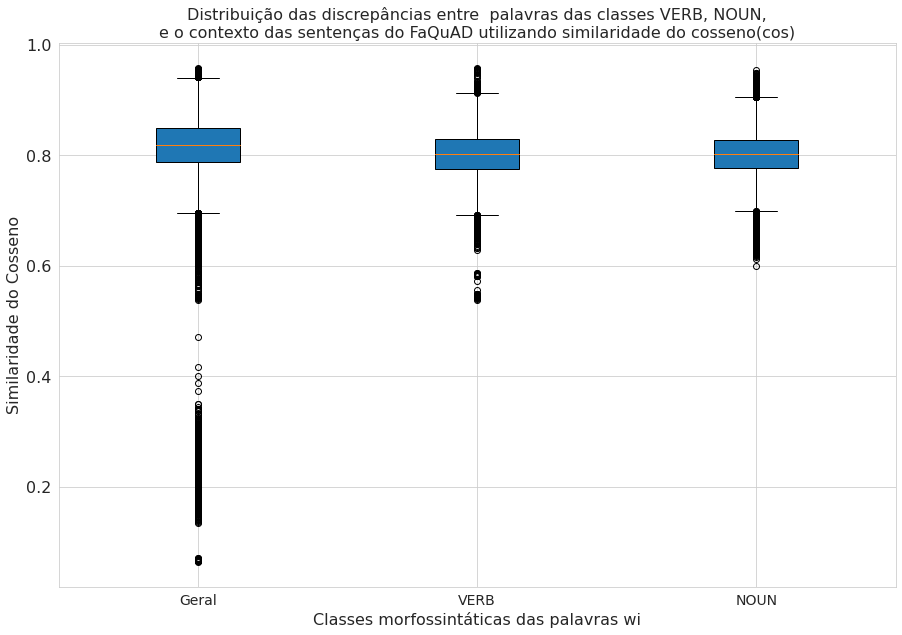

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxall_mean"]], lista_comparacao_classesVV[["cos_ctxall_mean"]], lista_comparacao_classesNN[["cos_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxall_mean"]],
                    lista_comparacao_classesVV[["euc_ctxall_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      euc_ctxall_mean euc_ctxall_mean euc_ctxall_mean
count   204582.000000    20191.000000    47221.000000
mean        22.560275       25.342731       23.276385
std          3.691554        4.183447        3.206298
min         10.244466       10.446237       10.244466
25%         20.110536       22.627509       21.360081
50%         22.229189       25.099951       23.058807
75%         24.572840       27.690548       25.051912
max         45.165359       45.165359       43.424953

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


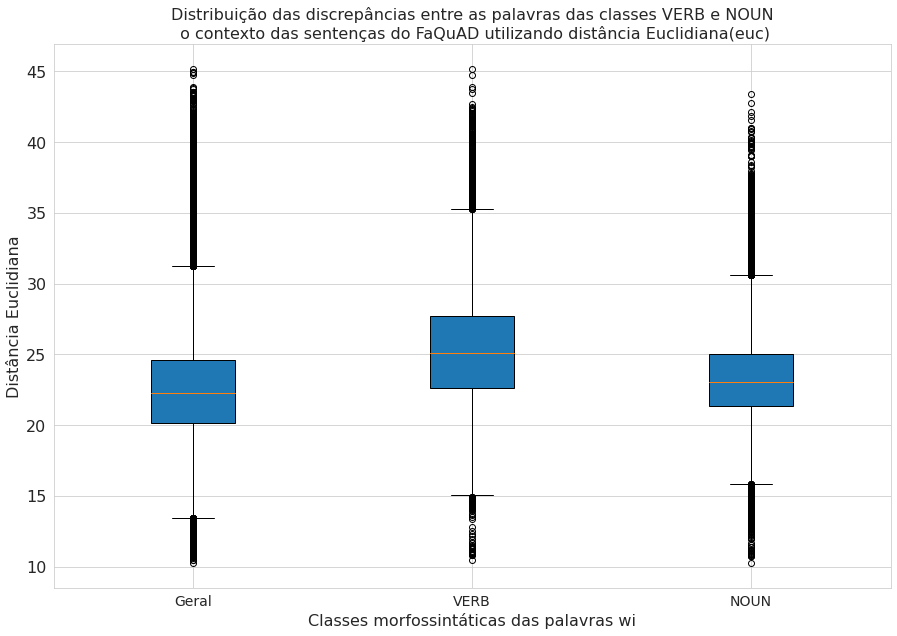

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxall_mean"]], lista_comparacao_classesVV[["euc_ctxall_mean"]], lista_comparacao_classesNN[["euc_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxall_mean"]],
                    lista_comparacao_classesVV[["man_ctxall_mean"]], 
                    lista_comparacao_classesNN[["man_ctxall_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral            VERB            NOUN
      man_ctxall_mean man_ctxall_mean man_ctxall_mean
count   204582.000000    20191.000000    47221.000000
mean      1087.476015     1204.052196     1099.016163
std        164.264300      178.422974      143.600945
min        494.070370      507.446400      494.070370
25%        979.457212     1089.270400     1013.065060
50%       1076.404600     1200.591600     1088.969600
75%       1183.582850     1313.006300     1181.370600
max       2096.301800     2096.301800     1996.594200

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


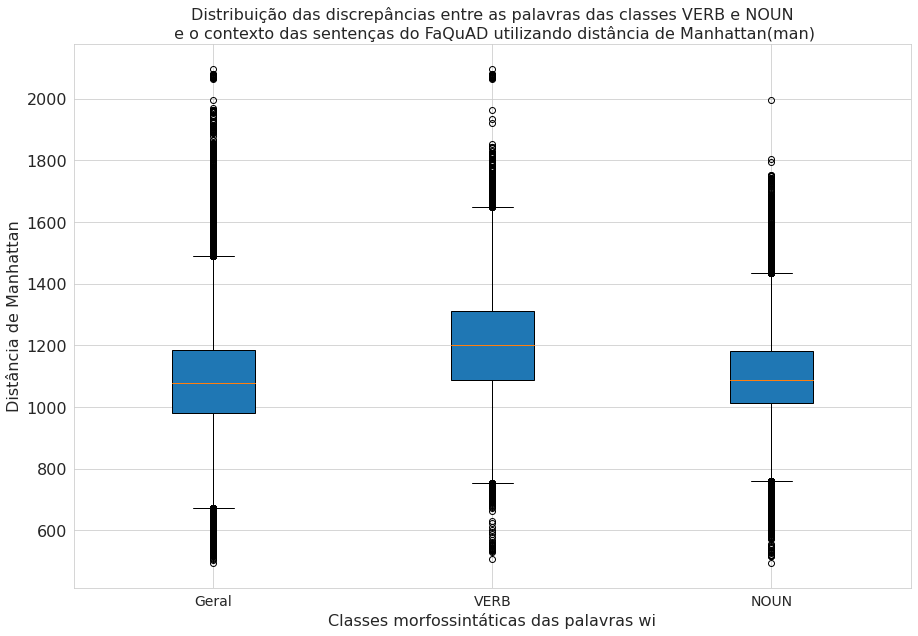

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxall_mean"]], lista_comparacao_classesVV[["man_ctxall_mean"]], lista_comparacao_classesNN[["man_ctxall_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com todas as palavras sem stopwords(ctxclean)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 20191


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count       20191.000000       20191.000000      20191.000000   
mean            0.811326          24.731028          0.802043   
std             0.050969           3.938316          0.055521   
min             0.508645          12.951006          0.508645   
25%             0.781270          22.107205          0.767420   
50%             0.818029          24.528278          0.808867   
75%             0.846843          26.877032          0.841796   
max             0.935620          48.667980          0.935620   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count      20191.000000      20191.000000       20191.000000  
mean          25.406927       1209.181027        1176.942456  
std            3.836268        174.367882         175.528741  
min           14.424446        697.656600         630.106450  
25%           22.945341       1095.006450        1057.995050  
50%           25.171650       1201.898200        1170.974400  
75%           27.456827       1308.633050        1281.939300  
max           48.667980       2148.943000        2052.186800

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/20191 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2 3461
      2        4 2854
      3        3 2484
      4        5 2171
      5        6 2020
      6        1 1677
      7        7 1516
      8        8 1004
      9        9  741
     10       10  534
     11       11  364
     12       12  338
     13       13  300
     14       14  274
     15       15  113
     16       16   81
     17        0   51
     18       20   42
     19       18   42
     20       41   21


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06557336449623108
Limite superior             : 0.9452033191919327
Limite inferior             : 0.6829098612070084


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 355 de 20191 ( 0.017582091030657224 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  355 de 20191 ( 0.017582091030657224 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação ?

 2 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação?

 3 0.5430207252502441 ver
         Quem é considerado o autor da frase ” Ciência da Computação tem tanto a ver com o computador como a astronomia com o telescópio [ … ] " ?

 4 0.5430207252502441 ver
         Quem é considerado o autor da frase ”Ciência da Computação tem tanto a ver com o computador como a astronomia com o telescópio […]"?

 5 0.5529261827468872 quer
         O que quer dizer quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 A quem é credita a frase " Ciência é para a Ciência da Computação assim como a hidrodinâmica é para a construção de encanamentos " ?
       1 0.7118289470672607 credita
       2 0.6829000115394592 é

 2 A quem é credita a frase "Ciência é para a Ciência da Computação assim como a hidrodinâmica é para a construção de encanamentos"?
       1 0.7118289470672607 credita
       2 0.6829000115394592 é

 3 Por que a contagem do tempo cursado é estabelecida a partir do ingresso do acadêmico na UFMS ?
       1 0.7952077388763428 estabelecida
       2 0.775123655796051 cursado
       3 0.6828479170799255 partir

 4 Quais os resultados finais que devem ser utilizadas para trabalho de conclusão de curso ?
       1 0.824842095375061 utilizadas
       2 0.6827724575996399 devem

 5 Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos deveriam ser resolvidos por um método efetivo ?
       1 0.8118247389793396 resolvidos
       2 0.79608970

##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.0743766725063324
Limite superior             : 0.9533611983060837
Limite inferior             : 0.6558545082807541


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 301 de 20191 ( 0.014907632113317816 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  301 de 20191 ( 0.014907632113317816 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação?

 2 0.508644700050354 quer
         O que quer dizer Total de Alunos Equivalentes da Graduação ?

 3 0.5215638279914856 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos podia ser resolvidos por um método efetivo ?

 4 0.5240298509597778 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos devem ser resolvidos por um método efetivo ?

 5 0.5246651768684387 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos poderão ser resolvidos por um método efetivo ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que fazer as bibliotecas e os centros de documentação ?
       1 0.6556930541992188 fazer

 2 O que diz o teorema da incompletude ?
       1 0.6556347608566284 diz

 3 Desde quando os processadores vêm sendo construídos em um único circuito único ?
       1 0.8416714668273926 construídos
       2 0.6556019186973572 vêm

 4 Quando o livro Calculando com numerais hindus foi mudado para o latim ?
       1 0.7778053283691406 mudado
       2 0.6555272340774536 Calculando

 5 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituir em fatos que beneficiarão os moradores de Brasília ” ?
       1 0.7268854975700378 constituir
       2 0.6803538799285889 beneficiarão
       3 0.6554927229881287 financiadas
       4 0.5941616892814636 passava
       5 0.5635766386985779 Há


##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.769826889038086
Limite superior             : 34.03177261352539
Limite inferior             : 14.952465057373047


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 449 de 20191 ( 0.022237630627507304 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 15 de 20191 ( 0.0007429052548165024 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  464 de 20191 ( 0.022980535882323808 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 48.6679801940918 Forma
         Quando se Forma a primeira turma de engenheiros de computação ?

 2 48.00374984741211 conhecida
         Como se conhecida a primeira universidade moderna ?

 3 43.41501998901367 quer
         O que quer acontece quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?

 4 43.24153518676758 ia
         O que quer ia quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?

 5 43.203643798828125 Deve
         o que Deve constar no formulário de inscrição ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 12.951005935668944 SGBDs
         O que seria SGBDs ?

 2 13.770211219787598 SGBDs
         O que foram SGBDs ?

 3 13.834833145141602 logarítmos
         Quem sabe os logarítmos ?

 4 13.951245307922363 logarítmos
         Quem fez os logarítmos ?

 5 14.187870979309082 logarítmos
         Quem faz os logarítmos ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quando se Forma a primeira turma de engenheiros de computação ?
       1 48.6679801940918 Forma

 2 Como se conhecida a primeira universidade moderna ?
       1 48.00374984741211 conhecida

 3 O que quer acontece quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?
       1 43.41501998901367 quer
       2 27.90499496459961 acontece
       3 23.97136688232422 opta
       4 22.66644096374512 avaliar

 4 O que quer ia quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?
       1 43.24153518676758 ia
       2 35.83860397338867 quer
       3 24.69460678100586 opta
       4 22.30282020568848 avaliar

 5 o que Deve constar no formulário de inscrição ?
       1 43.203643798828125 Deve
       2 19.963661193847656 constar


##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.511486053466797
Limite superior             : 34.224056243896484
Limite inferior             : 16.178112030029297


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 510 de 20191 ( 0.025258778663761083 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 30 de 20191 ( 0.0014858105096330048 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  540 de 20191 ( 0.026744589173394086 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 48.6679801940918 Forma
         Quando se Forma a primeira turma de engenheiros de computação ?

 2 48.00374984741211 conhecida
         Como se conhecida a primeira universidade moderna ?

 3 43.41501998901367 quer
         O que quer acontece quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?

 4 43.24153518676758 ia
         O que quer ia quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?

 5 43.203643798828125 Deve
         o que Deve constar no formulário de inscrição ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 14.424446105957031 faria
         O que Hollerith faria ?

 2 14.462815284729004 desenvolver
         Quem é responsável por desenvolver e desenvolver novas tecnologias ?

 3 14.56964874267578 pensou
         O que Hollerith pensou ?

 4 14.637475967407228 pensava
         O que Hollerith pensava ?

 5 14.953540802001951 cidadania
         o que é cidadania ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quando se Forma a primeira turma de engenheiros de computação ?
       1 48.6679801940918 Forma

 2 Como se conhecida a primeira universidade moderna ?
       1 48.00374984741211 conhecida

 3 O que quer acontece quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?
       1 43.41501998901367 quer
       2 28.68248176574707 opta
       3 27.90499496459961 acontece
       4 22.66644096374512 avaliar

 4 O que quer ia quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?
       1 43.24153518676758 ia
       2 35.83860397338867 quer
       3 28.526531219482425 opta
       4 22.30282020568848 avaliar

 5 o que Deve constar no formulário de inscrição ?
       1 43.203643798828125 Deve
       2 23.31490707397461 constar


##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 223.94425
Limite superior             : 1617.855675
Limite inferior             : 722.078675


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 284 de 20191 ( 0.014065672824525779 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 17 de 20191 ( 0.0008419592887920361 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  301 de 20191 ( 0.014907632113317816 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2052.1868 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2043.628 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se apresentam em fatos que beneficiarão os moradores de Brasília ” ?

 3 2043.5146 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituir em fatos que beneficiarão os moradores de Brasília ” ?

 4 2042.6104 Há
         De quem

###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 630.10645 SGBDs
         O que seria SGBDs ?

 2 677.4227 SGBDs
         O que foram SGBDs ?

 3 677.7205 logarítmos
         Quem sabe os logarítmos ?

 4 682.70465 logarítmos
         Quem fez os logarítmos ?

 5 697.6566 faria
         O que Hollerith faria ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2052.1868 Há
       2 1816.616 passava
       3 1233.0063 beneficiarão
       4 1210.4642 financiadas
       5 1192.9916 constituírem-se

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se apresentam em fatos que beneficiarão os moradores de Brasília ” ?
       1 2043.628 Há
       2 1800.4752 passava
       3 1494.6675 apresentam
       4 1224.1035 financiadas
       5 1216.6426 beneficiarão

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irre

##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 213.62659999999983
Limite superior             : 1629.0729499999998
Limite inferior             : 774.5665500000003


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 348 de 20191 ( 0.017235401911742856 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 36 de 20191 ( 0.0017829726115596058 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  384 de 20191 ( 0.01901837452330246 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2148.943 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2052.1868 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 2043.628 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se apresentam em fatos que beneficiarão os moradores de Brasília ” ?

 4 2043.5146 Há
     

###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_inferior) entre palavras da classe VERB e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 697.6566 faria
         O que Hollerith faria ?

 2 704.70105 pensou
         O que Hollerith pensou ?

 3 705.9492 pensava
         O que Hollerith pensava ?

 4 708.256 desenvolver
         Quem é responsável por desenvolver e desenvolver novas tecnologias ?

 5 712.7456 cidadania
         o que é cidadania ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe VERB e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2148.943 constituírem-se
       2 2052.1868 Há
       3 1816.616 passava
       4 1499.8363 financiadas
       5 1492.6699 beneficiarão

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2148.943 constituírem-se
       2 2052.1868 Há
       3 1816.616 passava
       4 1499.8363 financiadas
       5 1492.6699 beneficiarão

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade ir

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 47221


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]].describe(include=["float", "int"]) 

cos_ctxclean_mean  euc_ctxclean_mean  cos_ctxclean_max  \
count       47221.000000       47221.000000      47221.000000   
mean            0.825993          21.857361          0.814782   
std             0.045958           3.315166          0.055313   
min             0.553994          11.572813          0.553994   
25%             0.800951          19.688345          0.785888   
50%             0.831825          21.477093          0.825114   
75%             0.857735          23.569895          0.853694   
max             0.954357          45.852936          0.954357   

       euc_ctxclean_max  man_ctxclean_max  man_ctxclean_mean  
count      47221.000000      47221.000000       47221.000000  
mean          22.618188       1070.178864        1034.509492  
std            3.585914        167.633078         153.131857  
min           11.572813        565.882750         565.882750  
25%           20.164122        954.261350         934.104400  
50%           22.143478       1045.201400        1015.104400  
75%           24.594397       1165.413800        1115.250500  
max           45.852936       2009.354000        2009.354000

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/47221 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3 6170
      2        5 5704
      3        4 5160
      4        6 4404
      5        2 4282
      6        7 4051
      7        8 3673
      8        9 3090
      9        1 2495
     10       10 1670
     11       11 1613
     12       12 1167
     13       13  914
     14       14  628
     15       15  441
     16       17  399
     17       16  314
     18        0  289
     19       18  189
     20       19  147


##### COS - MEAN

In [ ]:
medida = "cos_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.05678367614746094
Limite superior             : 0.9429100751876831
Limite inferior             : 0.7157753705978394


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 8 de 47221 ( 0.0001694161495944601 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1126 de 47221 ( 0.023845323055420257 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1134 de 47221 ( 0.024014739205014717 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.9543566703796388 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 0.9515507817268372 cursos
         Os cursos de pós-graduação ou quais cursos ?

 3 0.9487794637680054 cursos
         Os cursos de pós-graduação foram quais cursos ?

 4 0.9479569792747498 cursos
         Os cursos de pós-graduação São quais cursos ?

 5 0.9475498795509338 cursos
         Os cursos de pós-graduação são quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5539944767951965 partir
         a partir de quando o semestre de posicionamento é interrompido ?

 2 0.5611217617988586 partir
         a partir de quando o semestre de posicionamento é suspenso ?

 3 0.5735968947410583 partir
         A partir de qual momento o tempo não será contabilizado ?

 4 0.576095700263977 partir
         a partir de quando o semestre de posicionamento é gratuito ?

 5 0.577470600605011 partir
         a partir de quando o semestre de posicionamento é obrigatório ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O trancamento de matrícula deve ser pedido caso o regime de exercícios domicilares for superior a quantos semestres ?
       1 0.8432994484901428 regime
       2 0.81100994348526 exercícios
       3 0.799191415309906 semestres
       4 0.7396575212478638 trancamento
       5 0.7157641649246216 matrícula

 2 Como deve ser localizada a carga horária faltante em caso de falta de cargha horária para integralização curricular ?
       1 0.8756522536277771 horária
       2 0.8432530164718628 carga
       3 0.8089758157730103 integralização
       4 0.7936098575592041 falta
       5 0.7157427668571472 caso

 3 Quantos dias no mínimo os lançamentos do período letivo especial no Siscad ão anteceder a data de matrícula do período letivo regular subsequente ?
       1 0.8074363470077515 período
       2 0.8015039563179016 lançamentos
       3 0.8009508848190308 dias
       4 0.7933448553085327 período
       5 0.7930957674980164 mínimo
       6 0.7463221549987793 matrícula
       7 0.71572554

##### COS - MAX

In [ ]:
medida = "cos_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06780517101287842
Limite superior             : 0.9554014205932617
Limite inferior             : 0.684180736541748


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 47221 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1250 de 47221 ( 0.02647127337413439 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1250 de 47221 ( 0.02647127337413439 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5539944767951965 partir
         a partir de quando o semestre de posicionamento é interrompido ?

 2 0.5611217617988586 partir
         a partir de quando o semestre de posicionamento é suspenso ?

 3 0.5627728700637817 hindu-arábico
         Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?

 4 0.5735968947410583 partir
         A partir de qual momento o tempo não será contabilizado ?

 5 0.5759369134902954 gestação
         Gestantes poderem ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxclean) < limite_inferior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual a engenharia no qual o estudo do hardware está parte ?
       1 0.9004772305488586 estudo
       2 0.9002764821052551 engenharia
       3 0.8535897135734558 hardware
       4 0.6840691566467285 parte

 2 Em qual ano de curso se justifica o estágio sanduíche ?
       1 0.8658587336540222 curso
       2 0.8495354652404785 estágio
       3 0.8404361605644226 ano
       4 0.6840543746948242 sanduíche

 3 O que a UFMS visa junto do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 0.8021571040153503 ambiente
       2 0.7978857159614563 ensino
       3 0.7951346635818481 preservação
       4 0.7876039147377014 recursos
       5 0.6864894032478333 meio
       6 0.6840397119522095 UFMS

 4 Quais os tipos de Programa de pós-graduação ?
       1 0.8431630730628967 tipos
       2 0.6840025782585144 pós-graduação

 5 Como o acadêmico poderá autenticar a fotocópia na Secretaria Acadêmica ?
       1 0.8103023767471313 acadêmico
       2 0.683953583240509 fotocópia


##### EUC - MEAN

In [ ]:
medida = "euc_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 3.8815498352050746
Limite superior             : 29.392219543457024
Limite inferior             : 13.866020202636724


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1433


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 66 de 47221 ( 0.0013976832341542958 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1499 de 47221 ( 0.03174435103026196 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 45.852935791015625 Dar
         Onde uma pessoa deve Dar aula para ser considerada professor nos Estados Unidos ?

 2 45.65447235107422 falta
         Compreender diferentes formas de pesquisa nos falta com o quê ?

 3 44.56544494628906 forma
         Com quem o computador moderno começou a ser forma ?

 4 42.325042724609375 parte
         Qual a engenharia no qual o estudo do hardware está parte ?

 5 41.01988983154297 migração
         Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 11.572813034057615 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 11.931535720825195 cursos
         Os cursos de pós-graduação ou quais cursos ?

 3 12.084074020385742 pergunta
         Qual foi a primeira pergunta ?

 4 12.102558135986328 ensino
         Quem quer o ensino superior ?

 5 12.2380952835083 cursos
         Os cursos de pós-graduação foram quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Onde uma pessoa deve Dar aula para ser considerada professor nos Estados Unidos ?
       1 45.852935791015625 Dar
       2 24.814720153808597 Onde
       3 23.254419326782227 aula
       4 23.124521255493164 pessoa
       5 20.805849075317383 professor

 2 Compreender diferentes formas de pesquisa nos falta com o quê ?
       1 45.65447235107422 falta
       2 27.446266174316406 quê
       3 22.041400909423828 formas
       4 21.324508666992188 pesquisa

 3 Com quem o computador moderno começou a ser forma ?
       1 44.56544494628906 forma
       2 19.44976806640625 computador

 4 Qual a engenharia no qual o estudo do hardware está parte ?
       1 42.325042724609375 parte
       2 19.61465072631836 hardware
       3 18.601919174194336 engenharia
       4 17.176271438598633 estudo

 5 Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?
       1 41.01988983154297 migração
       2 23.715377807617188 estudos
       3 23.676082611083984 p

##### EUC - MAX

In [ ]:
medida = "euc_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.430274963378906
Limite superior             : 31.239809036254883
Limite inferior             : 13.518709182739258


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 941


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 28 de 47221 ( 0.0005929565235806104 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  969 de 47221 ( 0.02052053111962898 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 45.852935791015625 Dar
         Onde uma pessoa deve Dar aula para ser considerada professor nos Estados Unidos ?

 2 45.65447235107422 falta
         Compreender diferentes formas de pesquisa nos falta com o quê ?

 3 44.56544494628906 forma
         Com quem o computador moderno começou a ser forma ?

 4 42.325042724609375 parte
         Qual a engenharia no qual o estudo do hardware está parte ?

 5 41.01988983154297 migração
         Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 11.572813034057615 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 11.931535720825195 cursos
         Os cursos de pós-graduação ou quais cursos ?

 3 12.084074020385742 pergunta
         Qual foi a primeira pergunta ?

 4 12.102558135986328 ensino
         Quem quer o ensino superior ?

 5 12.2380952835083 cursos
         Os cursos de pós-graduação foram quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Onde uma pessoa deve Dar aula para ser considerada professor nos Estados Unidos ?
       1 45.852935791015625 Dar
       2 24.814720153808597 Onde
       3 23.254419326782227 aula
       4 23.124521255493164 pessoa
       5 20.805849075317383 professor

 2 Compreender diferentes formas de pesquisa nos falta com o quê ?
       1 45.65447235107422 falta
       2 28.69875907897949 quê
       3 22.041400909423828 formas
       4 21.324508666992188 pesquisa

 3 Com quem o computador moderno começou a ser forma ?
       1 44.56544494628906 forma
       2 19.44976806640625 computador

 4 Qual a engenharia no qual o estudo do hardware está parte ?
       1 42.325042724609375 parte
       2 19.61465072631836 hardware
       3 18.601919174194336 engenharia
       4 17.176271438598633 estudo

 5 Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?
       1 41.01988983154297 migração
       2 23.715377807617188 estudos
       3 23.676082611083984 pl

##### MAN - MEAN

In [ ]:
medida = "man_ctxclean_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 181.14610000000005
Limite superior             : 1386.9696500000002
Limite inferior             : 662.38525


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 1387


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 67 de 47221 ( 0.0014188602528536034 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1454 de 47221 ( 0.03079138518879312 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2009.354 falta
         Compreender diferentes formas de pesquisa nos falta com o quê ?

 2 1849.0107 teorema
         Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?

 3 1841.7522 fim
         Qual a base da análise e interpretação dos dados coletados a fim da observação de fatos e fenômenos exatamente como ocorem realmente ?

 4 1821.5063 forma
         De qual área o estudo de sistemas computacionais comerciais forma parte ?

 5 1818.6681 forma
         Por que o estágio é a mais procura forma dentre as opções de atividade complementar de extensão ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 565.88275 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 581.7112 pergunta
         Qual foi a primeira pergunta ?

 3 581.80927 verdade
         o que é verdade ?

 4 582.51184 ensino
         Quem quer o ensino superior ?

 5 584.4792 cursos
         Os cursos de pós-graduação ou quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Compreender diferentes formas de pesquisa nos falta com o quê ?
       1 2009.354 falta
       2 1314.0435 quê
       3 1066.7289 formas
       4 1011.79974 pesquisa

 2 Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?
       1 1849.0107 teorema
       2 1195.7391 conceitos
       3 1123.3081 cálculo
       4 1096.7019 definição
       5 999.8406 recursividade

 3 Qual a base da análise e interpretação dos dados coletados a fim da observação de fatos e fenômenos exatamente como ocorem realmente ?
       1 1841.7522 fim
       2 1268.3782 base
       3 1216.6647 interpretação
       4 1202.0074 observação
       5 1129.1825 análise
       6 1087.9812 fenômenos
       7 1029.6324 dados
       8 981.8784 fatos

 4 De qual área o estudo de sistemas computacionais comerciais forma parte ?
       1 1821.5063 forma
       2 1510.2542 parte
       3 1276.2982 área
       4 1095.3354 estudo
       5 919.7444 sistemas

 5 Por que o estágio é a mais procura for

##### MAN - MAX

In [ ]:
medida = "man_ctxclean_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 211.15245000000004
Limite superior             : 1482.142475
Limite inferior             : 637.5326749999999


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 830


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 19 de 47221 ( 0.00040236335528684273 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  849 de 47221 ( 0.01797928887571208 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2009.354 falta
         Compreender diferentes formas de pesquisa nos falta com o quê ?

 2 1946.9579 hindu-arábico
         Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?

 3 1880.9302 hindu-arábico
         Quem foi responsável pela difusão do sistema de numer hindu-arábico no Oriente Médio ?

 4 1849.0107 teorema
         Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?

 5 1841.7522 fim
         Qual a base da análise e interpretação dos dados coletados a fim da observação de fatos e fenômenos exatamente como ocorem realmente ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxclean) < limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 565.88275 cursos
         Os cursos de pós-graduação e quais cursos ?

 2 581.7112 pergunta
         Qual foi a primeira pergunta ?

 3 581.80927 verdade
         o que é verdade ?

 4 582.51184 ensino
         Quem quer o ensino superior ?

 5 584.4792 cursos
         Os cursos de pós-graduação ou quais cursos ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxclean) > limite_superior) entre palavras da classe NOUN e o contexto de todas as palavras e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Compreender diferentes formas de pesquisa nos falta com o quê ?
       1 2009.354 falta
       2 1374.9983 quê
       3 1066.7289 formas
       4 1011.79974 pesquisa

 2 Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?
       1 1946.9579 hindu-arábico
       2 1243.5808 escravidão
       3 1237.0079 sistema
       4 1232.8857 difusão

 3 Quem foi responsável pela difusão do sistema de numer hindu-arábico no Oriente Médio ?
       1 1880.9302 hindu-arábico
       2 1297.0906 difusão
       3 1190.4369 sistema

 4 Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?
       1 1849.0107 teorema
       2 1257.4062 recursividade
       3 1195.7391 conceitos
       4 1123.3081 cálculo
       5 1096.7019 definição

 5 Qual a base da análise e interpretação dos dados coletados a fim da observação de fatos e fenômenos exatamente como ocorem realmente ?
       1 1841.7522 fim
       2 1268.3782 base
       3 1216.6647 inte

#### Comparando discrepância entre o contexto de todas as palavras e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean","euc_ctxclean_mean","cos_ctxclean_max","euc_ctxclean_max","man_ctxclean_max","man_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count     204582.000000     204582.000000    204582.000000    204582.000000   
mean           0.792510         23.771699         0.784764        24.303469   
std            0.066082          3.732203         0.067518         3.690113   
min            0.087471          0.000000         0.087471         0.000000   
25%            0.757907         21.317073         0.749419        21.871955   
50%            0.797617         23.607586         0.789857        24.102805   
75%            0.834491         25.980866         0.827579        26.455661   
max            1.000000         48.854042         1.000000        48.854042   

                                                      VERB                    \
      man_ctxclean_max man_ctxclean_mean cos_ctxclean_mean euc_ctxclean_mean   
count    204582.000000     204582.000000      20191.000000      20191.000000   
mean       1168.273160       1143.012059          0.811326         24.731028   
std         176.133466        178.765775          0.050969          3.938316   
min           0.000000          0.000000          0.508645         12.951006   
25%        1051.082025       1021.765615          0.781270         22.107205   
50%        1161.934700       1138.211600          0.818029         24.528278   
75%        1274.991750       1255.043100          0.846843         26.877032   
max        2416.819300       2107.836000          0.935620         48.667980   

                                                                            \
      cos_ctxclean_max euc_ctxclean_max man_ctxclean_max man_ctxclean_mean   
count     20191.000000     20191.000000     20191.000000      20191.000000   
mean          0.802043        25.406927      1209.181027       1176.942456   
std           0.055521         3.836268       174.367882        175.528741   
min           0.508645        14.424446       697.656600        630.106450   
25%           0.767420        22.945341      1095.006450       1057.995050   
50%           0.808867        25.171650      1201.898200       1170.974400   
75%           0.841796        27.456827      1308.633050       1281.939300   
max           0.935620        48.667980      2148.943000       2052.186800   

                   NOUN                                                      \
      cos_ctxclean_mean euc_ctxclean_mean cos_ctxclean_max euc_ctxclean_max   
count      47221.000000      47221.000000     47221.000000     47221.000000   
mean           0.825993         21.857361         0.814782        22.618188   
std            0.045958          3.315166         0.055313         3.585914   
min            0.553994         11.572813         0.553994        11.572813   
25%            0.800951         19.688345         0.785888        20.164122   
50%            0.831825         21.477093         0.825114        22.143478   
75%            0.857735         23.569895         0.853694        24.594397   
max            0.954357         45.852936         0.954357        45.852936   

                                          
      man_ctxclean_max man_ctxclean_mean  
count     47221.000000      47221.000000  
mean       1070.178864       1034.509492  
std         167.633078        153.131857  
min         565.882750        565.882750  
25%         954.261350        934.104400  
50%        1045.201400       1015.104400  
75%        1165.413800       1115.250500  
max        2009.354000       2009.354000

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxclean_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxclean_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      cos_ctxclean_mean cos_ctxclean_mean cos_ctxclean_mean
count     204582.000000      20191.000000      47221.000000
mean           0.792510          0.811326          0.825993
std            0.066082          0.050969          0.045958
min            0.087471          0.508645          0.553994
25%            0.757907          0.781270          0.800951
50%            0.797617          0.818029          0.831825
75%            0.834491          0.846843          0.857735
max            1.000000          0.935620          0.954357

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


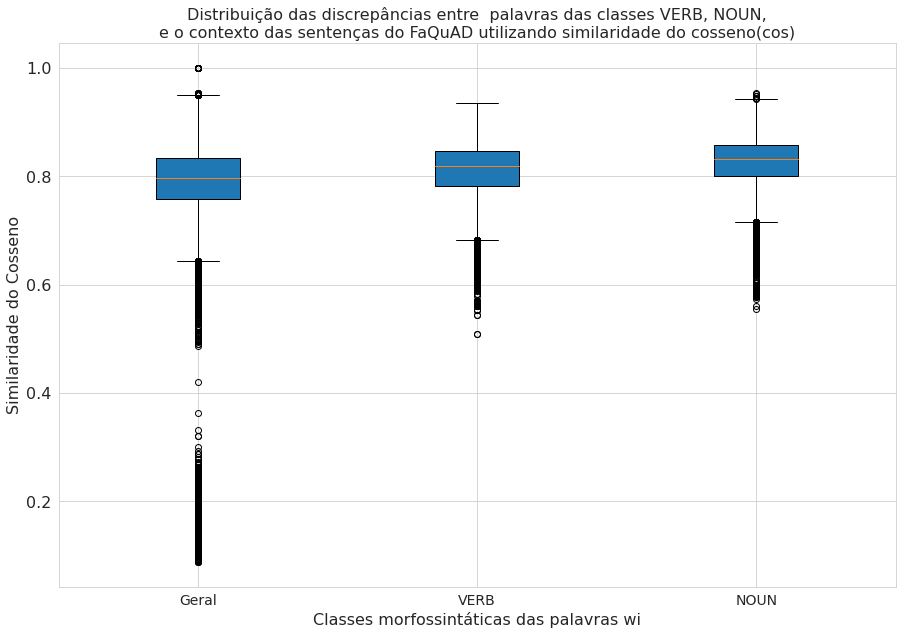

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxclean_mean"]], lista_comparacao_classesVV[["cos_ctxclean_mean"]], lista_comparacao_classesNN[["cos_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxclean_mean"]],
                    lista_comparacao_classesVV[["euc_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      euc_ctxclean_mean euc_ctxclean_mean euc_ctxclean_mean
count     204582.000000      20191.000000      47221.000000
mean          23.771699         24.731028         21.857361
std            3.732203          3.938316          3.315166
min            0.000000         12.951006         11.572813
25%           21.317073         22.107205         19.688345
50%           23.607586         24.528278         21.477093
75%           25.980866         26.877032         23.569895
max           48.854042         48.667980         45.852936

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


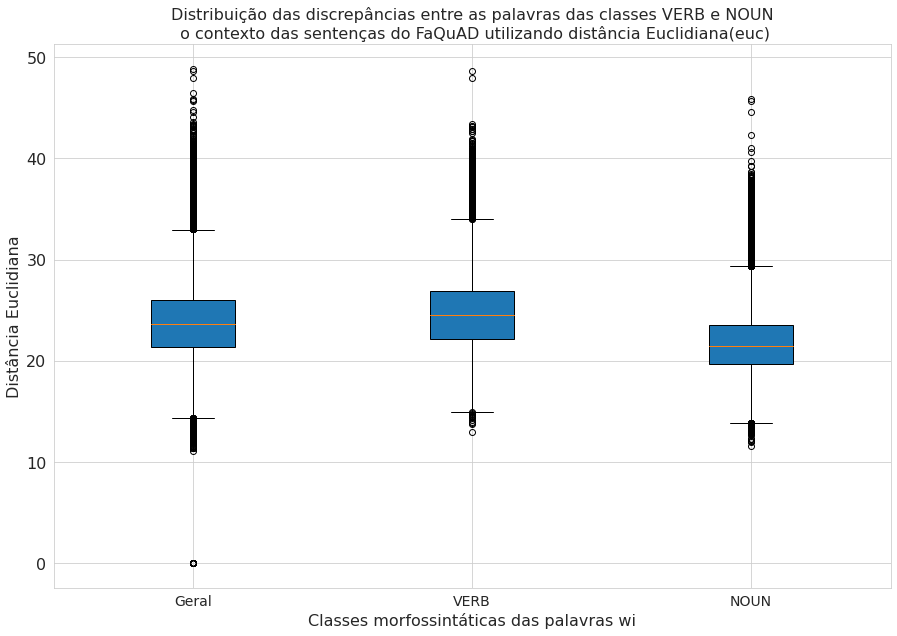

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxclean_mean"]], lista_comparacao_classesVV[["euc_ctxclean_mean"]], lista_comparacao_classesNN[["euc_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxclean_mean"]],
                    lista_comparacao_classesVV[["man_ctxclean_mean"]], 
                    lista_comparacao_classesNN[["man_ctxclean_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral              VERB              NOUN
      man_ctxclean_mean man_ctxclean_mean man_ctxclean_mean
count     204582.000000      20191.000000      47221.000000
mean        1143.012059       1176.942456       1034.509492
std          178.765775        175.528741        153.131857
min            0.000000        630.106450        565.882750
25%         1021.765615       1057.995050        934.104400
50%         1138.211600       1170.974400       1015.104400
75%         1255.043100       1281.939300       1115.250500
max         2107.836000       2052.186800       2009.354000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


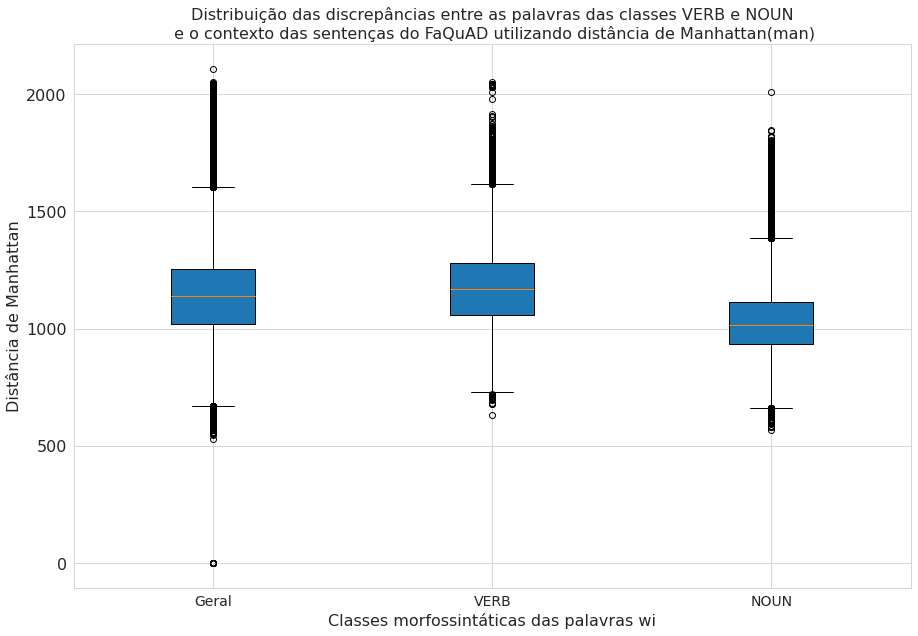

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxclean_mean"]], lista_comparacao_classesVV[["man_ctxclean_mean"]], lista_comparacao_classesNN[["man_ctxclean_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB e AUX(ctxverb)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 20191


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean", "euc_ctxverb_mean",
                          "man_ctxverb_mean", "cos_ctxverb_max",
                          "euc_ctxverb_max",  "man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count      20191.000000      20191.000000      20191.000000     20191.000000   
mean           0.919100         14.056261        673.925002         0.909742   
std            0.060371          8.784381        420.875838         0.072849   
min            0.621091          0.000000          0.000000         0.546779   
25%            0.879130          0.000000          0.000000         0.868594   
50%            0.919675         16.713814        801.517944         0.917733   
75%            1.000000         19.925132        953.226410         0.957579   
max            1.000000         40.276051       1946.588623         1.000000   

       euc_ctxverb_max  man_ctxverb_max  
count     20191.000000     20191.000000  
mean         14.862036       712.869701  
std           9.323236       447.925645  
min           0.000000         0.000000  
25%          11.877746       568.986755  
50%          17.122120       818.966309  
75%          21.169042      1016.034180  
max          41.658283      2155.059082

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/20191 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2 3461
      2        4 2854
      3        3 2484
      4        5 2171
      5        6 2020
      6        1 1677
      7        7 1516
      8        8 1004
      9        9  741
     10       10  534
     11       11  364
     12       12  338
     13       13  300
     14       14  274
     15       15  113
     16       16   81
     17        0   51
     18       20   42
     19       18   42
     20       41   21


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.12086957693099976
Limite superior             : 1.1813043653964996
Limite inferior             : 0.6978260576725006


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 45 de 20191 ( 0.002228715764449507 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  45 de 20191 ( 0.002228715764449507 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6210905909538269 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformando em fatos que beneficiarão os moradores de Brasília ” ?

 2 0.6227565407752991 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se forem em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.6228153705596924 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornar em fatos que beneficiarão os moradores de Brasília ” ?

 4 0.6231

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 A FAPDF tem finalidade de estimular, apoiar e promover o desenvolvimento científico de qual âmbito?
       1 0.9200418591499328 estimular
       2 0.9134923219680786 apoiar
       3 0.9018524885177612 promover
       4 0.6969214677810669 tem

 2 A FAPDF tem finalidade de estimular , apoiar e promover o desenvolvimento científico de qual âmbito ?
       1 0.9200418591499328 estimular
       2 0.9134923219680786 apoiar
       3 0.9018524885177612 promover
       4 0.6969214677810669 tem

 3 A FAPDF tem finalidade de estimular , incentivar e promover o desenvolvimento científico de qual âmbito ?
       1 0.9371537566184998 estimular
       2 0.931424617767334 incentivar
       3 0.9069889187812804 promover
       4 0.6954224705696106 tem

 4 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituem em fa

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.08898481726646423
Limite superior             : 1.091055765748024
Limite inferior             : 0.735116496682167


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 414 de 20191 ( 0.020504185032935468 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  414 de 20191 ( 0.020504185032935468 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5467785000801086 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.5937091112136841 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos podia ser resolvidos por um método efetivo ?

 3 0.5979099273681641 cursadas
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem cursadas?

 4 0.600775957107544 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos poderia ser resolvidos por um método efeti

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Como era feita a máquina de tecer números de Babbage ?
       1 0.8857080340385437 feita
       2 0.7347638010978699 tecer

 2 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem aplicadas ?
       1 0.797806441783905 apresentar
       2 0.7814658284187317 existir
       3 0.7761451005935669 deve
       4 0.7359058856964111 enquadrado
       5 0.7339286804199219 aplicadas
       6 0.7027361392974854 matricular
       7 0.6335704922676086 impeçam

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem executadas ?
       1 0.7970241904258728 apresentar
       2 0.7855463027954102 existir
       3 0.7736782431602478 deve
       4 0.7506393194198608 executadas
       5 0.7

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 19.925131797790527
Limite superior             : 49.81282949447632
Limite inferior             : -29.88769769668579


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 20191 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 20191 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 9.291296005249023
Limite superior             : 35.10598564147949
Limite inferior             : -2.0591983795166016


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 85 de 20191 ( 0.00420979644396018 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 20191 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  85 de 20191 ( 0.00420979644396018 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 41.65828323364258 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 40.27605056762695 provar
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fatos que beneficiarão os moradores de Brasília ” ?

 3 39.325321197509766 mostrar
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se mostrar em fatos que beneficiarão os moradores de Brasí

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 41.65828323364258 constituírem-se
       2 38.669708251953125 Há
       3 33.380943298339844 passava
       4 30.69848251342773 beneficiarão
       5 30.34163475036621 financiadas

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fatos que beneficiarão os moradores de Brasília ” ?
       1 40.27605056762695 provar
       2 38.44978332519531 Há
       3 33.0339241027832 passava
       4 31.686765670776367 beneficiarão
       5 30.54295539855957 financiadas

 3 De quem foram as palavras “ Há p

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 953.2264099121094
Limite superior             : 2383.0660247802734
Limite inferior             : -1429.839614868164


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 20191 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 20191 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 447.04742431640625
Limite superior             : 1686.6053161621094
Limite inferior             : -101.58438110351562


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 86 de 20191 ( 0.004259323460947947 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 20191 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  86 de 20191 ( 0.004259323460947947 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2155.05908203125 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 1946.588623046875 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 1943.7215576171875 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformando em fatos que beneficiarão os moradores de Brasíl

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2155.05908203125 constituírem-se
       2 1946.588623046875 Há
       3 1637.361083984375 passava
       4 1511.4544677734375 financiadas
       5 1510.836669921875 beneficiarão

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2155.05908203125 constituírem-se
       2 1946.588623046875 Há
       3 1637.361083984375 passava
       4 1511.4544677734375 financiadas
       5 1510.836669921875 beneficiarão

 3 De quem foram as palav

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 47221


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverb_mean","euc_ctxverb_mean",
                          "man_ctxverb_mean","cos_ctxverb_max",
                          "euc_ctxverb_max","man_ctxverb_max"]].describe(include=["float", "int"]) 

cos_ctxverb_mean  euc_ctxverb_mean  man_ctxverb_mean  cos_ctxverb_max  \
count      41984.000000      41984.000000      41984.000000     41984.000000   
mean           0.641167         33.227609       1573.014955         0.631713   
std            0.068724          4.311970        189.574662         0.072347   
min            0.367089         19.317062        906.888184         0.318914   
25%            0.595320         30.225821       1439.312836         0.582207   
50%            0.645260         32.880369       1563.135498         0.636511   
75%            0.690805         35.810095       1698.537933         0.684559   
max            0.892101         57.853046       2389.483154         0.892101   

       euc_ctxverb_max  man_ctxverb_max  
count     41984.000000     41984.000000  
mean         33.787677      1598.862781  
std           4.348734       191.729433  
min          19.317062       906.888184  
25%          30.688802      1461.874725  
50%          33.512224      1591.828735  
75%          36.446678      1727.222504  
max          57.853046      2445.218750

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/47221 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3 6170
      2        5 5704
      3        4 5160
      4        6 4404
      5        2 4282
      6        7 4051
      7        8 3673
      8        9 3090
      9        1 2495
     10       10 1670
     11       11 1613
     12       12 1167
     13       13  914
     14       14  628
     15       15  441
     16       17  399
     17       16  314
     18        0  289
     19       18  189
     20       19  147


##### COS - MEAN

In [ ]:
medida = "cos_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 47221 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 47221 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 47221 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 47221 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 47221 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 47221 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverb) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 47221 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 47221 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 47221 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 47221 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxverb_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 47221 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 47221 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxverb_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 0


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 47221 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 47221 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverb) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverb) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxvern) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### Comparando discrepância entre o contexto de palavras da classe VERB e palavras de todas classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean","euc_ctxverb_mean",
                                               "man_ctxverb_mean","cos_ctxverb_max",
                                               "euc_ctxverb_max","man_ctxverb_max"]],
                    lista_comparacao_classesVV[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean","euc_ctxverb_mean",
                                                "man_ctxverb_mean","cos_ctxverb_max",
                                                "euc_ctxverb_max","man_ctxverb_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count    186027.000000    186027.000000    186027.000000   186027.000000   
mean          0.708248        28.852819      1384.158980        0.701730   
std           0.123800         8.875884       415.965652        0.127221   
min           0.030959         0.000000         0.000000        0.030959   
25%           0.630071        26.017572      1269.327942        0.621840   
50%           0.693258        30.349098      1465.949585        0.689208   
75%           0.763323        34.149206      1635.011353        0.760732   
max           1.000000        59.446781      2420.440918        1.000000   

                                                  VERB                   \
      euc_ctxverb_max man_ctxverb_max cos_ctxverb_mean euc_ctxverb_mean   
count   186027.000000   186027.000000     20191.000000     20191.000000   
mean        29.267317     1403.576047         0.919100        14.056261   
std          8.979408      420.254998         0.060371         8.784381   
min          0.000000        0.000000         0.621091         0.000000   
25%         26.255325     1281.534668         0.879130         0.000000   
50%         30.707333     1482.823975         0.919675        16.713814   
75%         34.664671     1657.299744         1.000000        19.925132   
max         60.412590     2643.242676         1.000000        40.276051   

                                                                        \
      man_ctxverb_mean cos_ctxverb_max euc_ctxverb_max man_ctxverb_max   
count     20191.000000    20191.000000    20191.000000    20191.000000   
mean        673.925002        0.909742       14.862036      712.869701   
std         420.875838        0.072849        9.323236      447.925645   
min           0.000000        0.546779        0.000000        0.000000   
25%           0.000000        0.868594       11.877746      568.986755   
50%         801.517944        0.917733       17.122120      818.966309   
75%         953.226410        0.957579       21.169042     1016.034180   
max        1946.588623        1.000000       41.658283     2155.059082   

                  NOUN                                                    \
      cos_ctxverb_mean euc_ctxverb_mean man_ctxverb_mean cos_ctxverb_max   
count     41984.000000     41984.000000     41984.000000    41984.000000   
mean          0.641167        33.227609      1573.014955        0.631713   
std           0.068724         4.311970       189.574662        0.072347   
min           0.367089        19.317062       906.888184        0.318914   
25%           0.595320        30.225821      1439.312836        0.582207   
50%           0.645260        32.880369      1563.135498        0.636511   
75%           0.690805        35.810095      1698.537933        0.684559   
max           0.892101        57.853046      2389.483154        0.892101   

                                       
      euc_ctxverb_max man_ctxverb_max  
count    41984.000000    41984.000000  
mean        33.787677     1598.862781  
std          4.348734      191.729433  
min         19.317062      906.888184  
25%         30.688802     1461.874725  
50%         33.512224     1591.828735  
75%         36.446678     1727.222504  
max         57.853046     2445.218750

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverb_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxverb_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxverb_mean cos_ctxverb_mean cos_ctxverb_mean
count    186027.000000     20191.000000     41984.000000
mean          0.708248         0.919100         0.641167
std           0.123800         0.060371         0.068724
min           0.030959         0.621091         0.367089
25%           0.630071         0.879130         0.595320
50%           0.693258         0.919675         0.645260
75%           0.763323         1.000000         0.690805
max           1.000000         1.000000         0.892101

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


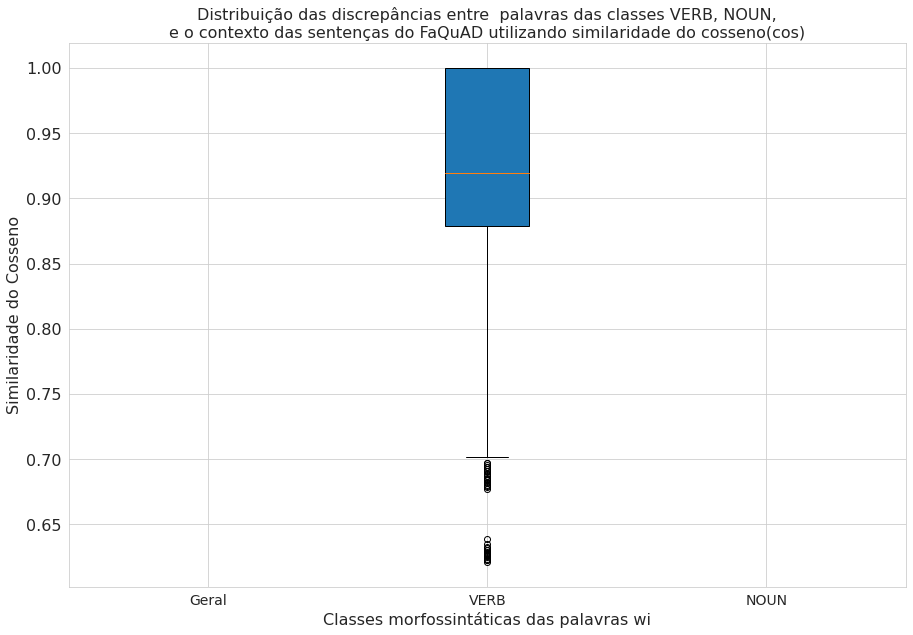

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverb_mean"]], lista_comparacao_classesVV[["cos_ctxverb_mean"]], lista_comparacao_classesNN[["cos_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverb_mean"]],
                    lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxverb_mean euc_ctxverb_mean euc_ctxverb_mean
count    186027.000000     20191.000000     41984.000000
mean         28.852819        14.056261        33.227609
std           8.875884         8.784381         4.311970
min           0.000000         0.000000        19.317062
25%          26.017572         0.000000        30.225821
50%          30.349098        16.713814        32.880369
75%          34.149206        19.925132        35.810095
max          59.446781        40.276051        57.853046

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


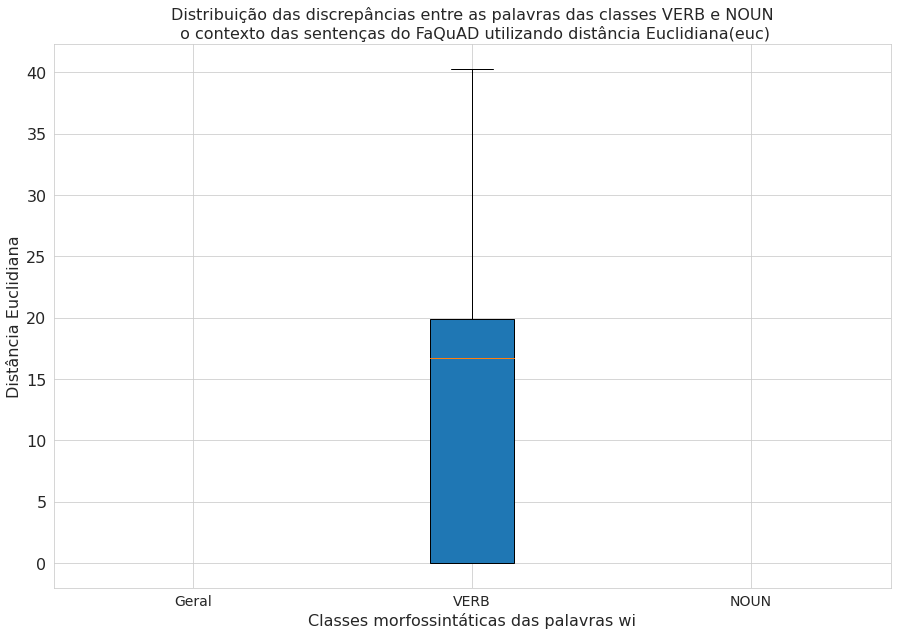

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverb_mean"]], 
           lista_comparacao_classesVV[["euc_ctxverb_mean"]], 
           lista_comparacao_classesNN[["euc_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverb_mean"]],
                    lista_comparacao_classesVV[["man_ctxverb_mean"]], 
                    lista_comparacao_classesNN[["man_ctxverb_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxverb_mean man_ctxverb_mean man_ctxverb_mean
count    186027.000000     20191.000000     41984.000000
mean       1384.158980       673.925002      1573.014955
std         415.965652       420.875838       189.574662
min           0.000000         0.000000       906.888184
25%        1269.327942         0.000000      1439.312836
50%        1465.949585       801.517944      1563.135498
75%        1635.011353       953.226410      1698.537933
max        2420.440918      1946.588623      2389.483154

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


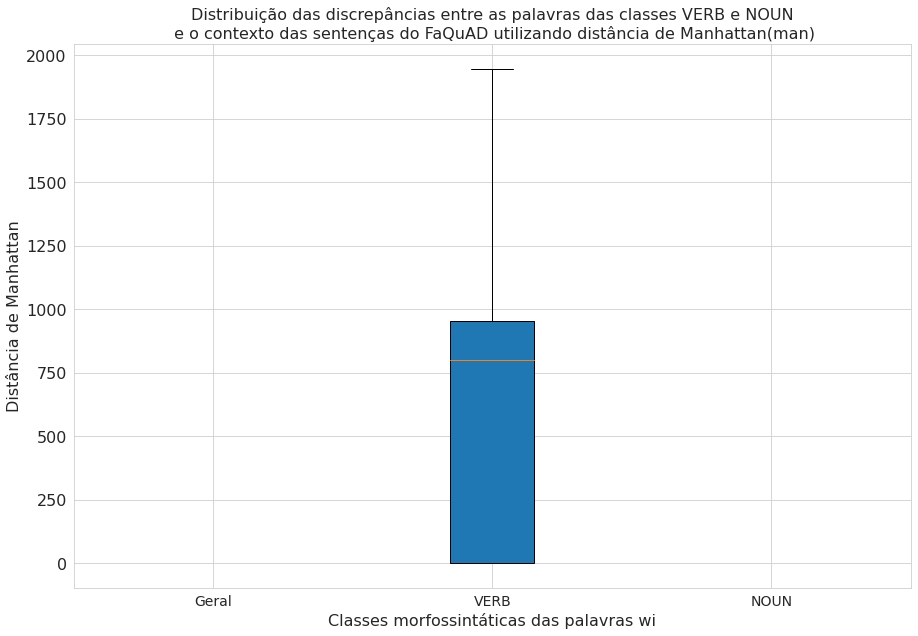

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverb_mean"]], 
           lista_comparacao_classesVV[["man_ctxverb_mean"]], 
           lista_comparacao_classesNN[["man_ctxverb_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe NOUN(ctxnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 20191


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean",
                          "man_ctxnoun_mean","cos_ctxnoun_max",
                          "euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count      19309.000000      19309.000000      19309.000000     19309.000000   
mean           0.676653         31.859588       1511.474459         0.668354   
std            0.058278          4.032888        176.459644         0.057768   
min            0.395881         18.659601        861.612183         0.395881   
25%            0.640969         29.211937       1393.689087         0.633386   
50%            0.679927         31.523319       1504.148438         0.672345   
75%            0.718486         34.099205       1614.914062         0.708663   
max            0.903529         53.475506       2395.207520         0.903529   

       euc_ctxnoun_max  man_ctxnoun_max  
count     19309.000000     19309.000000  
mean         32.413423      1537.836096  
std           3.747493       165.257693  
min          18.659601       861.612183  
25%          29.916636      1426.571045  
50%          31.982111      1522.501465  
75%          34.420940      1632.901855  
max          53.475506      2395.207520

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/20191 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2 3461
      2        4 2854
      3        3 2484
      4        5 2171
      5        6 2020
      6        1 1677
      7        7 1516
      8        8 1004
      9        9  741
     10       10  534
     11       11  364
     12       12  338
     13       13  300
     14       14  274
     15       15  113
     16       16   81
     17        0   51
     18       20   42
     19       18   42
     20       41   21


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 20191 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 20191 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 20191 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 20191 ( 0.0 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 20191 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 20191 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 20191 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 20191 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 20191 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 20191 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): nan
Limite superior             : nan
Limite inferior             : nan


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 20191 ( 0.0 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 0 de 20191 ( 0.0 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  0 de 20191 ( 0.0 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_inferior) entre palavras da classe VERB e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe VERB e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 47221


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]].describe(include=["float", "int"]) 

cos_ctxnoun_mean  euc_ctxnoun_mean  man_ctxnoun_mean  cos_ctxnoun_max  \
count      47221.000000      47221.000000      47221.000000     47221.000000   
mean           0.878429         17.696914        835.385697         0.866979   
std            0.055854          6.167775        289.322670         0.065506   
min            0.634331          0.000000          0.000000         0.565387   
25%            0.842979         15.857524        750.517090         0.830684   
50%            0.877219         18.549200        877.356812         0.870583   
75%            0.910970         21.130516        999.449402         0.907360   
max            1.000000         40.557644       1799.209473         1.000000   

       euc_ctxnoun_max  man_ctxnoun_max  
count     47221.000000     47221.000000  
mean         18.620415       879.105270  
std           6.338819       298.639662  
min           0.000000         0.000000  
25%          16.323467       773.727356  
50%          19.232294       908.731934  
75%          22.138178      1045.594238  
max          40.557644      1939.636963

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/47221 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3 6170
      2        5 5704
      3        4 5160
      4        6 4404
      5        2 4282
      6        7 4051
      7        8 3673
      8        9 3090
      9        1 2495
     10       10 1670
     11       11 1613
     12       12 1167
     13       13  914
     14       14  628
     15       15  441
     16       17  399
     17       16  314
     18        0  289
     19       18  189
     20       19  147


##### COS - MEAN

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06799048185348511
Limite superior             : 1.0129552781581879
Limite inferior             : 0.7409933507442474


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 47221 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 413 de 47221 ( 0.008746108722814002 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  413 de 47221 ( 0.008746108722814002 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6343310475349426 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornar em fatos que beneficiarão os moradores de Brasília ” ?

 2 0.6365123391151428 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornarem em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.6373059153556824 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformando em fatos que beneficiarão os moradores de Brasília ” 

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual quesito da gestão da tecnologia da informação não acelera o mesmo ritmo das políticas de segurança ?
       1 0.8725822567939758 gestão
       2 0.8468077778816223 tecnologia
       3 0.8367874026298523 segurança
       4 0.822016179561615 políticas
       5 0.8056565523147583 informação
       6 0.7655876874923706 quesito
       7 0.740969181060791 ritmo

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fatos que beneficiarão os moradores de Brasília ” ?
       1 0.7851932644844055 fatos
       2 0.7820806503295898 idealistas
       3 0.7793300747871399 resultados
       4 0.7477678656578064 moradores
       5 0.7409273386001587 palavras
       6 0.737739622592926 realidade
       7 0.7342683672904968 futuro
       8 0.7296131253242493 garantia
       9 0.7227805256843567 sonho
      

##### COS - MAX

In [ ]:
medida = "cos_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06799048185348511
Limite superior             : 1.0129552781581879
Limite inferior             : 0.7409933507442474


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 0 de 47221 ( 0.0 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 413 de 47221 ( 0.008746108722814002 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  413 de 47221 ( 0.008746108722814002 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.6343310475349426 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornar em fatos que beneficiarão os moradores de Brasília ” ?

 2 0.6365123391151428 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornarem em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.6373059153556824 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformando em fatos que beneficiarão os moradores de Brasília ” 

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxnoun) < limite_inferior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual quesito da gestão da tecnologia da informação não acelera o mesmo ritmo das políticas de segurança ?
       1 0.8725822567939758 gestão
       2 0.8468077778816223 tecnologia
       3 0.8367874026298523 segurança
       4 0.822016179561615 políticas
       5 0.8056565523147583 informação
       6 0.7655876874923706 quesito
       7 0.740969181060791 ritmo

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fatos que beneficiarão os moradores de Brasília ” ?
       1 0.7851932644844055 fatos
       2 0.7820806503295898 idealistas
       3 0.7793300747871399 resultados
       4 0.7477678656578064 moradores
       5 0.7409273386001587 palavras
       6 0.737739622592926 realidade
       7 0.7342683672904968 futuro
       8 0.7296131253242493 garantia
       9 0.7227805256843567 sonho
      

##### EUC - MEAN

In [ ]:
medida = "euc_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.272992134094238
Limite superior             : 29.04000425338745
Limite inferior             : 7.948035717010498


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 582


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3520 de 47221 ( 0.07454310582156244 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  4102 de 47221 ( 0.08686813070455941 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 40.55764389038086 diferente
         O que a UFMS visa diferente do ensino e da preservação dos recursos naturais do meio ambiente ?

 2 40.503173828125 m
         O que a UFMS visa m do ensino e da preservação dos recursos naturais do meio ambiente ?

 3 38.149696350097656 obra
         Qual obra atenção para a importância do papel do professor na formação do cidadão ?

 4 37.48871994018555 migração
         Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?

 5 36.83200454711914 teorema
         Qual teorema melhor a definição de conceitos como recursividade e cálculo lambda ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 soluções
         O que as soluções tecnológicas automatizam?

 2 0.0 professors
         O que os professors no Reino Unido geralmente usam ?

 3 0.0 professors
         O que os professors no Reino Unido geralmente encontram ?

 4 0.0 professors
         O que os professors no Reino Unido geralmente precisam ?

 5 0.0 professors
         O que os professors no Reino Unido geralmente conhecem ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que a UFMS visa diferente do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 40.55764389038086 diferente
       2 24.657773971557617 meio
       3 23.883405685424805 ensino
       4 22.84712791442871 UFMS
       5 22.812801361083984 recursos
       6 22.26311683654785 preservação
       7 19.56897354125977 ambiente

 2 O que a UFMS visa m do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 40.503173828125 m
       2 25.1247615814209 meio
       3 24.261816024780277 ensino
       4 23.168331146240234 recursos
       5 22.46038818359375 UFMS
       6 22.21954917907715 preservação
       7 20.005352020263672 ambiente

 3 Qual obra atenção para a importância do papel do professor na formação do cidadão ?
       1 38.149696350097656 obra
       2 25.52913475036621 atenção
       3 24.94877815246582 formação
       4 24.04792022705078 cidadão
       5 22.71662712097168 papel
       6 22.174877166748047 professor
       7 22.07381439208

##### EUC - MAX

In [ ]:
medida = "euc_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 5.81471061706543
Limite superior             : 30.860243797302246
Limite inferior             : 7.601401329040527


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 546


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3038 de 47221 ( 0.06433578280849622 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3584 de 47221 ( 0.07589843501831813 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 40.55764389038086 diferente
         O que a UFMS visa diferente do ensino e da preservação dos recursos naturais do meio ambiente ?

 2 40.503173828125 m
         O que a UFMS visa m do ensino e da preservação dos recursos naturais do meio ambiente ?

 3 39.51165390014648 hindu-arábico
         Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?

 4 38.149696350097656 obra
         Qual obra atenção para a importância do papel do professor na formação do cidadão ?

 5 37.48871994018555 migração
         Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 soluções
         O que as soluções tecnológicas automatizam?

 2 0.0 calendário
         O calendário acadêmico é determinado por quem ?

 3 0.0 calendário
         O calendário acadêmico é decidido por quem ?

 4 0.0 períodos
         Quando são oferecidos os períodos letivos especiais?

 5 0.0 períodos
         Quando são realizados os períodos letivos especiais ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que a UFMS visa diferente do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 40.55764389038086 diferente
       2 28.19828414916992 UFMS
       3 24.657773971557617 meio
       4 23.883405685424805 ensino
       5 22.812801361083984 recursos
       6 22.26311683654785 preservação
       7 19.56897354125977 ambiente

 2 O que a UFMS visa m do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 40.503173828125 m
       2 27.7670841217041 UFMS
       3 25.1247615814209 meio
       4 24.261816024780277 ensino
       5 23.168331146240234 recursos
       6 22.21954917907715 preservação
       7 20.005352020263672 ambiente

 3 Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?
       1 39.51165390014648 hindu-arábico
       2 24.08596992492676 difusão
       3 20.77862548828125 escravidão
       4 19.314088821411133 sistema

 4 Qual obra atenção para a importância do papel do professor na formação d

##### MAN - MEAN

In [ ]:
medida = "man_ctxnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 248.93231201171875
Limite superior             : 1372.8478698730469
Limite inferior             : 377.1186218261719


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 357


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3520 de 47221 ( 0.07454310582156244 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3877 de 47221 ( 0.08210330149721522 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1799.20947265625 teorema
         Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?

 2 1705.408447265625 tempo
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 1703.855712890625 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se traduz em fatos que beneficiarão os moradores de Brasília ” ?

 4 1701.4114990234375 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor ,

###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 2 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 3 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 4 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 5 0.0 soluções
         O que as soluções tecnológicas automatizam?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?
       1 1799.20947265625 teorema
       2 1102.0093994140625 conceitos
       3 1087.076904296875 cálculo
       4 1067.972900390625 definição
       5 1041.4991455078125 recursividade

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 1705.408447265625 tempo
       2 1408.889404296875 garantia
       3 1407.61181640625 palavras
       4 1391.689697265625 realidade
       5 1327.529052734375 fatos
       6 1325.8167724609375 resultados
       7 1319.6343994140625 sonho
       8 1287.0753173828125 futuro
       9 1251.50634765625 pesquisas
       10 1237.653076171875 moradores
       11 1228.777587890625 idealistas

 3 De quem foram as palavras “ Há

##### MAN - MAX

In [ ]:
medida = "man_ctxnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 271.86688232421875
Limite superior             : 1453.3945617675781
Limite inferior             : 365.9270324707031


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 485


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 3038 de 47221 ( 0.06433578280849622 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  3523 de 47221 ( 0.07460663687766037 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1939.636962890625 hindu-arábico
         Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?

 2 1847.522216796875 hindu-arábico
         Quem foi responsável pela difusão do sistema de numer hindu-arábico no Oriente Médio ?

 3 1800.307861328125 pré-requisitos
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem disciplinas ?

 4 1799.20947265625 teorema
         Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?

 5 1789.528076171875 pré-requisitos
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem isoladas ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 2 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 3 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 4 326.75506591796875 atividades
         Quais atividades estão inclusas nas atividades complementares?

 5 0.0 soluções
         O que as soluções tecnológicas automatizam?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?
       1 1939.636962890625 hindu-arábico
       2 1146.443359375 difusão
       3 991.430908203125 escravidão
       4 917.6617431640624 sistema

 2 Quem foi responsável pela difusão do sistema de numer hindu-arábico no Oriente Médio ?
       1 1847.522216796875 hindu-arábico
       2 1124.0618896484375 difusão
       3 823.832763671875 sistema

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem disciplinas ?
       1 1800.307861328125 pré-requisitos
       2 1534.3765869140625 caso
       3 1531.0074462890625 inicial
       4 1529.626953125 disciplinas
       5 1369.207275390625 carga
       6 1058.1956787109375 acadêmico
       7 1041.1046142578125 semestre
       8 1008.0147705078124 semestre
       9 958.5167236328124 disciplin

#### Comparando discrepância entre o contexto de palavras NOUN e palavras de todas classes, VERB e NOUN

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    lista_comparacao_classesVV[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean","euc_ctxnoun_mean","man_ctxnoun_mean","cos_ctxnoun_max","euc_ctxnoun_max","man_ctxnoun_max"]],
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count    196501.000000    196501.000000    196501.000000   196501.000000   
mean          0.732621        26.745067      1280.667327        0.725690   
std           0.108969         6.912576       331.909232        0.109167   
min           0.053923         0.000000         0.000000        0.053923   
25%           0.661976        23.622955      1128.510010        0.657057   
50%           0.721074        27.751289      1336.342285        0.715313   
75%           0.797423        31.047483      1494.890625        0.786123   
max           1.000000        53.475506      2549.481934        1.000000   

                                                  VERB                   \
      euc_ctxnoun_max man_ctxnoun_max cos_ctxnoun_mean euc_ctxnoun_mean   
count   196501.000000   196501.000000     19309.000000     19309.000000   
mean        27.228973     1303.545000         0.676653        31.859588   
std          6.790102      325.758612         0.058278         4.032888   
min          0.000000        0.000000         0.395881        18.659601   
25%         24.246254     1163.281494         0.640969        29.211937   
50%         28.089037     1352.021606         0.679927        31.523319   
75%         31.351574     1509.122314         0.718486        34.099205   
max         53.475506     2571.148926         0.903529        53.475506   

                                                                        \
      man_ctxnoun_mean cos_ctxnoun_max euc_ctxnoun_max man_ctxnoun_max   
count     19309.000000    19309.000000    19309.000000    19309.000000   
mean       1511.474459        0.668354       32.413423     1537.836096   
std         176.459644        0.057768        3.747493      165.257693   
min         861.612183        0.395881       18.659601      861.612183   
25%        1393.689087        0.633386       29.916636     1426.571045   
50%        1504.148438        0.672345       31.982111     1522.501465   
75%        1614.914062        0.708663       34.420940     1632.901855   
max        2395.207520        0.903529       53.475506     2395.207520   

                  NOUN                                                    \
      cos_ctxnoun_mean euc_ctxnoun_mean man_ctxnoun_mean cos_ctxnoun_max   
count     47221.000000     47221.000000     47221.000000    47221.000000   
mean          0.878429        17.696914       835.385697        0.866979   
std           0.055854         6.167775       289.322670        0.065506   
min           0.634331         0.000000         0.000000        0.565387   
25%           0.842979        15.857524       750.517090        0.830684   
50%           0.877219        18.549200       877.356812        0.870583   
75%           0.910970        21.130516       999.449402        0.907360   
max           1.000000        40.557644      1799.209473        1.000000   

                                       
      euc_ctxnoun_max man_ctxnoun_max  
count    47221.000000    47221.000000  
mean        18.620415      879.105270  
std          6.338819      298.639662  
min          0.000000        0.000000  
25%         16.323467      773.727356  
50%         19.232294      908.731934  
75%         22.138178     1045.594238  
max         40.557644     1939.636963

##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxnoun_mean"]],                    
                    lista_comparacao_classesVV[["cos_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["cos_ctxnoun_mean"]],
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      cos_ctxnoun_mean cos_ctxnoun_mean cos_ctxnoun_mean
count    196501.000000     19309.000000     47221.000000
mean          0.732621         0.676653         0.878429
std           0.108969         0.058278         0.055854
min           0.053923         0.395881         0.634331
25%           0.661976         0.640969         0.842979
50%           0.721074         0.679927         0.877219
75%           0.797423         0.718486         0.910970
max           1.000000         0.903529         1.000000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


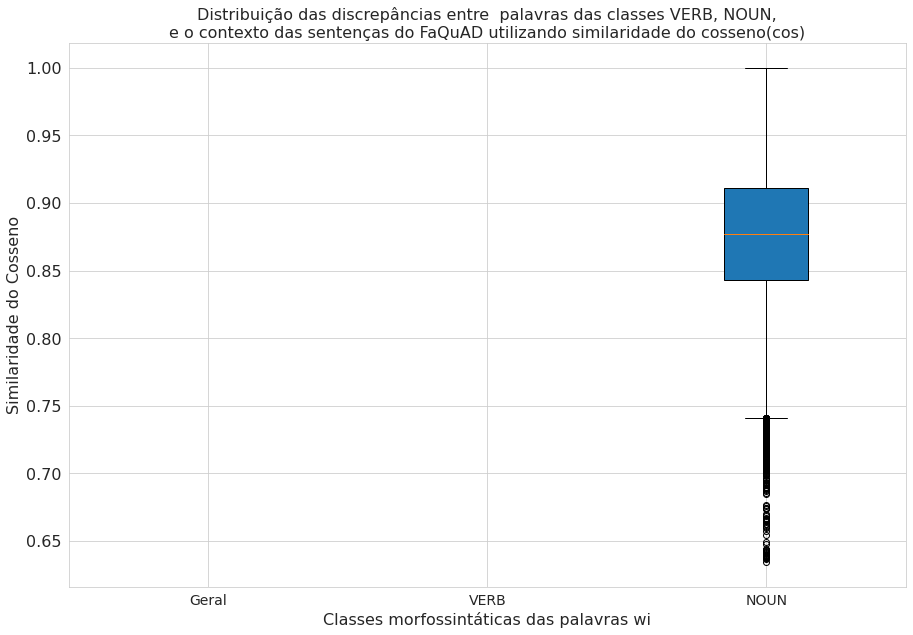

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do FaQuAD utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxnoun_mean"]], lista_comparacao_classesVV[["cos_ctxnoun_mean"]], lista_comparacao_classesNN[["cos_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["euc_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["euc_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      euc_ctxnoun_mean euc_ctxnoun_mean euc_ctxnoun_mean
count    196501.000000     19309.000000     47221.000000
mean         26.745067        31.859588        17.696914
std           6.912576         4.032888         6.167775
min           0.000000        18.659601         0.000000
25%          23.622955        29.211937        15.857524
50%          27.751289        31.523319        18.549200
75%          31.047483        34.099205        21.130516
max          53.475506        53.475506        40.557644

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


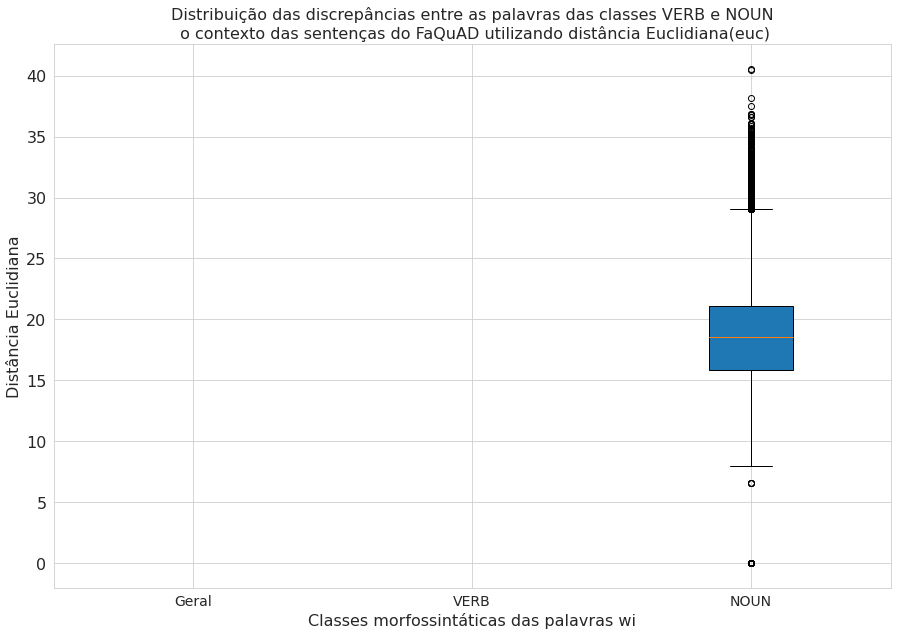

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do FaQuAD utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxnoun_mean"]], lista_comparacao_classesVV[["euc_ctxnoun_mean"]], lista_comparacao_classesNN[["euc_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxnoun_mean"]],
                    lista_comparacao_classesVV[["man_ctxnoun_mean"]], 
                    lista_comparacao_classesNN[["man_ctxnoun_mean"]],                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral             VERB             NOUN
      man_ctxnoun_mean man_ctxnoun_mean man_ctxnoun_mean
count    196501.000000     19309.000000     47221.000000
mean       1280.667327      1511.474459       835.385697
std         331.909232       176.459644       289.322670
min           0.000000       861.612183         0.000000
25%        1128.510010      1393.689087       750.517090
50%        1336.342285      1504.148438       877.356812
75%        1494.890625      1614.914062       999.449402
max        2549.481934      2395.207520      1799.209473

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


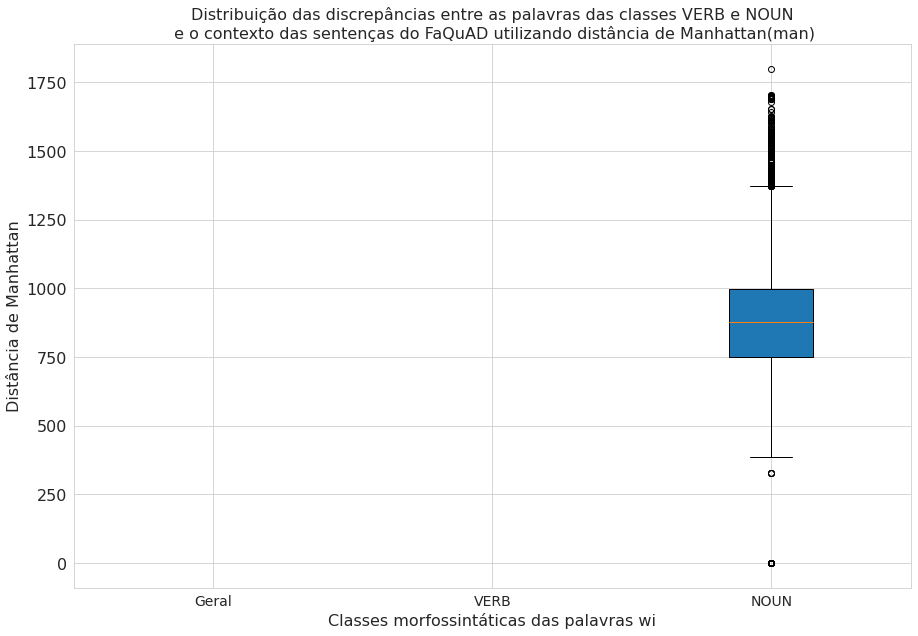

In [ ]:
# Import da bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do FaQuAD utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxnoun_mean"]], lista_comparacao_classesVV[["man_ctxnoun_mean"]], lista_comparacao_classesNN[["man_ctxnoun_mean"]]]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

### Contexto com palavras da classe VERB(AUX) e NOUN(ctxverbnoun)

#### VERB

In [ ]:
classe_morfosintatica = "VERB"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesVV = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 20191


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count          20191.000000          20191.000000          20191.000000   
mean               0.847291             22.240978           1057.391125   
std                0.048984              4.932912            227.301268   
min                0.573206              0.000000              0.000000   
25%                0.818776             19.990830            954.668671   
50%                0.846567             22.333448           1066.966553   
75%                0.875405             24.858289           1183.598816   
max                1.000000             42.891533           2030.208618   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count         20191.000000         20191.000000         20191.000000  
mean              0.837960            22.939103          1090.826243  
std               0.057500             5.086200           237.848503  
min               0.528096             0.000000             0.000000  
25%               0.808048            20.669161           984.913757  
50%               0.840460            23.065807          1098.828613  
75%               0.871928            25.664006          1219.963135  
max               1.000000            42.891533          2168.713379

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo VERB

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/20191 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        2 3461
      2        4 2854
      3        3 2484
      4        5 2171
      5        6 2020
      6        1 1677
      7        7 1516
      8        8 1004
      9        9  741
     10       10  534
     11       11  364
     12       12  338
     13       13  300
     14       14  274
     15       15  113
     16       16   81
     17        0   51
     18       20   42
     19       18   42
     20       41   21


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.056629687547683716
Limite superior             : 0.9603499621152878
Limite inferior             : 0.7338312119245529


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 372 de 20191 ( 0.01842405031944926 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 270 de 20191 ( 0.013372294586697043 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  642 de 20191 ( 0.0317963449061463 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 diz
         O que diz a Tese de Church-Turing?

 2 1.0 disse
         O que disse o MEC ?

 3 1.0 pensa
         O que pensa o MEC ?

 4 1.0 quer
         O que quer o MEC ?

 5 1.0 fez
         O que fez o MEC ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5732060670852661 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornam em fatos que beneficiarão os moradores de Brasília ” ?

 2 0.5733163356781006 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornar em fatos que beneficiarão os moradores de Brasília ” ?

 3 0.5733267068862915 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se tornarem em fatos que beneficiarão os moradores de Brasília ” ?

 4 0.57426238

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que acontece caso o acadêmico não renove a matrícula e estiver impedido de votar ?
       1 0.8291445970535278 renove
       2 0.7831898927688599 votar
       3 0.733731210231781 acontece

 2 como é realizada a seleção de alunos para uma disciplina cujo número de inscritos considera o número de vagas ?
       1 0.7476527690887451 considera
       2 0.7336040735244751 realizada

 3 O que quer saber quando um professor opta por avaliar a sua matéria através de seminários ao invés de provas ?
       1 0.8280106782913208 avaliar
       2 0.817726731300354 saber
       3 0.7426599860191345 opta
       4 0.7335160970687866 quer

 4 Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos conseguem ser resolvidos por um método efetivo ?
       1 0.8314489722251892 resolvidos
       2 0.8117266893386841 descobrir
       3 0.7921150922775269 conseguem
       4 0.7594655156135559 debruçarem
       5 0.7334886193275452 fez

 5 Em qual se

##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06388026475906372
Limite superior             : 0.9677482545375824
Limite inferior             : 0.7122271955013275


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 363 de 20191 ( 0.01797830716655936 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 504 de 20191 ( 0.02496161656183448 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  867 de 20191 ( 0.042939923728393836 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 diz
         O que diz a Tese de Church-Turing?

 2 1.0 disse
         O que disse o MEC ?

 3 1.0 pensa
         O que pensa o MEC ?

 4 1.0 quer
         O que quer o MEC ?

 5 1.0 fez
         O que fez o MEC ?


###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5280957221984863 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 0.5554878115653992 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos podia ser resolvidos por um método efetivo ?

 3 0.5607484579086304 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos poderão ser resolvidos por um método efetivo ?

 4 0.561381459236145 debruçarem
         Qual o problema de Hilbert que fez os matemáticos se debruçarem tentanto descobrir quais problemas matemáticos pode ser resolvidos por um método efetivo ?

 5 0.5623133182525635 debruçarem
         Qual o problema 

###### Top 5 documentos com as maiores discrepâncias (cos(wi,ctxverbnoun) < limite_inferior)  entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Gestantes poderão ser ajudadas pelo regime de exercícios a partir de qual mês de gestação?
       1 0.7957330346107483 poderão
       2 0.7121869921684265 ajudadas

 2 Gestantes poderão ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?
       1 0.7957330346107483 poderão
       2 0.7121869921684265 ajudadas

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se transformar em fatos que beneficiarão os moradores de Brasília ” ?
       1 0.7121749520301819 transformar
       2 0.6825070977210999 beneficiarão
       3 0.6596864461898804 financiadas
       4 0.6329329609870911 passava
       5 0.580807089805603 Há

 4 Qual a base da análise e interpretação dos dados coletados a respeito da observação de fatos e fenômenos exatamente como ocorem realmente ?
       1 0.7121424674987793 co

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.867458343505859
Limite superior             : 32.1594762802124
Limite inferior             : 12.689642906188965


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 374 de 20191 ( 0.018523104353424795 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 382 de 20191 ( 0.01891932048932693 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  756 de 20191 ( 0.037442424842751725 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.89153289794922 ultrapass
         como é realizada a seleção de alunos para uma disciplina cujo número de inscritos ultrapass o número de vagas ?

 2 42.15781021118164 provar
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fatos que beneficiarão os moradores de Brasília ” ?

 3 41.4316520690918 acelera
         Qual quesito da gestão da tecnologia da informação não acelera o mesmo ritmo das políticas de segurança ?

 4 41.29023361206055 mostrar
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se mostrar em fatos que beneficiarão os moradores de Brasília ” ?

 5 41.07725524902344 ia
         O que

###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 sejam
         O que sejam WebApps ?

 2 0.0 faz
         O que faz o MEC ?

 3 0.0 defende
         Quem defende o Ministério da Saúde ?

 4 0.0 decide
         Quem decide o Ministério da Saúde ?

 5 0.0 compõe
         Quem compõe o Ministério da Saúde ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 como é realizada a seleção de alunos para uma disciplina cujo número de inscritos ultrapass o número de vagas ?
       1 42.89153289794922 ultrapass
       2 29.237451553344727 realizada

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fatos que beneficiarão os moradores de Brasília ” ?
       1 42.15781021118164 provar
       2 40.31061172485352 Há
       3 35.234519958496094 passava
       4 25.907012939453125 beneficiarão
       5 24.840635299682617 financiadas

 3 Qual quesito da gestão da tecnologia da informação não acelera o mesmo ritmo das políticas de segurança ?
       1 41.4316520690918 acelera

 4 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , qu

##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.994845390319824
Limite superior             : 33.15627431869507
Limite inferior             : 13.176892757415771


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 366 de 20191 ( 0.01812688821752266 )


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 402 de 20191 ( 0.019909860829082266 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  768 de 20191 ( 0.03803674904660492 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 42.89153289794922 ultrapass
         como é realizada a seleção de alunos para uma disciplina cujo número de inscritos ultrapass o número de vagas ?

 2 42.2108268737793 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 42.15781021118164 provar
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fatos que beneficiarão os moradores de Brasília ” ?

 4 41.4316520690918 acelera
         Qual quesito da gestão da tecnologia da informação não acelera o mesmo ritmo das políticas de segurança ?

 5 41.29023361206055 mostrar


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 tem
         O que tem MVC ?

 2 0.0 compõe
         Quem compõe o Ministério da Saúde ?

 3 0.0 paga
         Quem paga o Ministério da Saúde ?

 4 0.0 governa
         Quem governa o Ministério da Saúde ?

 5 0.0 fez
         Quem fez o Ministério da Saúde ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 como é realizada a seleção de alunos para uma disciplina cujo número de inscritos ultrapass o número de vagas ?
       1 42.89153289794922 ultrapass
       2 29.237451553344727 realizada

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 42.2108268737793 constituírem-se
       2 40.6300048828125 Há
       3 35.62832260131836 passava
       4 30.727807998657227 beneficiarão
       5 30.41559600830078 financiadas

 3 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se provar em fatos que beneficiarão os moradores de Brasília ” ?
       1 42.15781021118164

##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 228.93014526367188
Limite superior             : 1526.9940338134766
Limite inferior             : 611.2734527587891


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 197 de 20191 ( 0.009756822346590066 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 387 de 20191 ( 0.019166955574265763 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  584 de 20191 ( 0.028923777920855827 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2030.2086181640625 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2019.4893798828125 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituir em fatos que beneficiarão os moradores de Brasília ” ?

 3 2018.331298828125 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se forem em fatos que beneficiarão os moradores de Brasília ” ?

 4 2017.97

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 610.6240234375 criada
         Quando Eduba foi criada?

 2 610.5626220703125 aprovado
         Quando Eduba foi aprovado ?

 3 604.427978515625 criado
         Quando Eduba foi criado ?

 4 604.3453369140625 controla
         O que o Siscad controla , gerencia e divulga ?

 5 603.392578125 assassinado
         Quando Eduba foi assassinado ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2030.2086181640625 Há
       2 1757.154052734375 passava
       3 1245.537353515625 beneficiarão
       4 1240.8685302734375 constituírem-se
       5 1215.226806640625 financiadas

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituir em fatos que beneficiarão os moradores de Brasília ” ?
       1 2019.4893798828125 Há
       2 1767.8348388671875 constituir
       3 1741.11669921875 passava
       4 1253.6583251953125 beneficiarão
       5 1226.5029296875 financiadas

 3 De quem foram as palavra

##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 235.04937744140625
Limite superior             : 1572.5372009277344
Limite inferior             : 632.3396911621094


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 251 de 20191 ( 0.012431281263929474 )


Encontra os documentos com as maiores similaridades (man(wi,wj) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 407 de 20191 ( 0.0201574959140211 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  658 de 20191 ( 0.03258877717795057 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 2168.71337890625 constituírem-se
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 2 2030.2086181640625 Há
         De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?

 3 2019.4893798828125 Há
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituir em fatos que beneficiarão os moradores de Brasília

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 632.1646728515625 controla
         O que o Siscad controla , decide e divulga ?

 2 630.4647216796875 presa
         Quando Eduba foi presa ?

 3 630.0225219726562 chamado
         Quando Eduba foi chamado ?

 4 629.293212890625 controla
         O que o Siscad controla , protege e divulga ?

 5 629.1184692382812 ficava
         Onde ficava o MIT ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)   entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2168.71337890625 constituírem-se
       2 2030.2086181640625 Há
       3 1757.154052734375 passava
       4 1508.5843505859375 beneficiarão
       5 1506.8321533203125 financiadas

 2 De quem foram as palavras “Há pouco tempo não passava de um sonho de idealistas, hoje é uma realidade irreversível. Mais do que isto é uma garantia de um futuro mais promissor, quando os resultados das pesquisas financiadas se constituírem-se em fatos que beneficiarão os moradores de Brasília”?
       1 2168.71337890625 constituírem-se
       2 2030.2086181640625 Há
       3 1757.154052734375 passava
       4 1508.5843505859375 beneficiarão
       5 1506.8321533203125 financiadas

 3 De quem foram as p

#### NOUN

In [ ]:
classe_morfosintatica = "NOUN"

##### Estatísticas

Filtrar comparação contexto com verbos

In [ ]:
lista_comparacao_classes = lista_comparacao_contexto[(lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]

lista_comparacao_classesNN = lista_comparacao_classes

print("Comparações:", len(lista_comparacao_classes))

Comparações: 47221


Estatísticas das medidas dos contextos e palavras

In [ ]:
# Import das bibliotecas
import pandas as pd

# Formata o número de casas decimais dos números reais
pd.set_option("precision", 6)

# Exibe as estatísticas
lista_comparacao_classes[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].describe(include=["float", "int"]) 

cos_ctxverbnoun_mean  euc_ctxverbnoun_mean  man_ctxverbnoun_mean  \
count          47221.000000          47221.000000          47221.000000   
mean               0.841426             20.882385            987.474733   
std                0.046028              3.485698            160.545961   
min                0.592524              0.000000              0.000000   
25%                0.812053             18.789530            891.371521   
50%                0.843506             20.833269            985.554443   
75%                0.872390             22.865572           1080.979492   
max                1.000000             39.103588           1761.926758   

       cos_ctxverbnoun_max  euc_ctxverbnoun_max  man_ctxverbnoun_max  
count         47221.000000         47221.000000         47221.000000  
mean              0.830249            21.651228          1023.566333  
std               0.057574             3.901036           181.751252  
min               0.539717             0.000000             0.000000  
25%               0.799203            19.215326           911.343079  
50%               0.837649            21.414747          1011.180969  
75%               0.869025            23.910856          1129.727173  
max               1.000000            39.489048          1946.494629

##### Top 20

Top 20 palavras(wi) em mais ocorrências nas comparações de pos(wi) do tipo NOUN e pos(wj) do tipo NOUN

In [ ]:
# Import das bibliotecas
import ast
from tqdm.notebook import tqdm as tqdm_notebook
from collections import Counter

# Barra de progresso dos documentos
lista_comparacao_classes_bar = tqdm_notebook(lista_comparacao_classes.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_comparacao_classes))

# Contador das palavras
contador = Counter()

# Percorre as comparações
for i, linha_comparacao in lista_comparacao_classes_bar:  
  #if i < 10:             
    contador[linha_comparacao[3]] += 1

Documentos:   0%|          | 0/47221 [00:00<?, ? documento/s]

In [ ]:
top = 20
lista = []
# Lista as ocorrências das palavras
for i, item in enumerate(sorted(contador, key = contador.get, reverse=True)):
  if i < top:
    lista.append([i+1, item, contador[item]])      

In [ ]:
# Converte em um dataFrame
df1 = pd.DataFrame(lista, columns=("ranque", "palavra", "#wi"))

# Motra o rank
print(df1.to_string(index=False))

 ranque  palavra  #wi
      1        3 6170
      2        5 5704
      3        4 5160
      4        6 4404
      5        2 4282
      6        7 4051
      7        8 3673
      8        9 3090
      9        1 2495
     10       10 1670
     11       11 1613
     12       12 1167
     13       13  914
     14       14  628
     15       15  441
     16       17  399
     17       16  314
     18        0  289
     19       18  189
     20       19  147


##### COS - MEAN

In [ ]:
medida = "cos_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.060337066650390625
Limite superior             : 0.9628954529762268
Limite inferior             : 0.7215471863746643


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 158 de 47221 ( 0.0033459689544905868 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 554 de 47221 ( 0.011732068359416361 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  712 de 47221 ( 0.015078037313906948 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 artigo
         O que Claude Shannon , no artigo A Mathematical Theory of Communication ?

 2 1.0 valor
         Qual o valor do POSCOMP ?

 3 1.0 necessidade
         O POSCOMP e a necessidade de quê ?

 4 1.0 doutorando
         O que o doutorando quer ?

 5 1.0 federação
         Qual a maior federação sindical docente de Portugal?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5925241708755493 gestação
         Gestantes poderem ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 2 0.5994164943695068 gestação
         Gestantes deve ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 3 0.6196915507316589 gestação
         Gestantes poderão ser ajudadas pelo regime de exercícios a partir de qual mês de gestação?

 4 0.6196915507316589 gestação
         Gestantes poderão ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 5 0.6247162818908691 gestação
         Gestantes podemos ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 A quem é credita a frase " Ciência voltada para a Ciência da Computação assim como a hidrodinâmica é para a construção de encanamentos " ?
       1 0.8398853540420532 hidrodinâmica
       2 0.8087661862373352 Ciência
       3 0.7437418699264526 frase
       4 0.7258079051971436 construção
       5 0.7214787602424622 encanamentos

 2 O processo seletivo do programa de monitoria da resolução nº 342 atinge qual finalidade ?
       1 0.8242478966712952 resolução
       2 0.8186159133911133 programa
       3 0.8086217641830444 monitoria
       4 0.8059277534484863 processo
       5 0.8050181269645691 finalidade
       6 0.7214678525924683 nº

 3 Qual foi a necessidade que fez a lei da criação da FAPDF ser aprovada pela lei nº 3.652 ?
       1 0.8777108192443848 lei
       2 0.8362168073654175 lei
       3 0.8145569562911987 necessidade
       4 0.7721101641654968 FAPDF
       5 0.7315108180046082 criação
       6 0.7214122414588928 nº

 4 Qual foi a necessidade que fez a lei da criação 

##### COS - MAX

In [ ]:
medida = "cos_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 0.06982213258743286
Limite superior             : 0.9737586081027985
Limite inferior             : 0.694470077753067


Encontra os documentos com as maiores similaridades (cos(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior", len(lista_comparacao_outliers_superior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_superior)/len(lista_comparacao_classes),")")

Outliers superior 140 de 47221 ( 0.0029647826179030516 )


Encontra os documentos com as maiores discrepâncias (cos(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 1232 de 47221 ( 0.026090087037546852 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1372 de 47221 ( 0.029054869655449907 )


###### Top 5 documentos com as maiores similaridades (cos(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1.0 artigo
         O que Claude Shannon , no artigo A Mathematical Theory of Communication ?

 2 1.0 entidade
         Qual a maior entidade sindical docente de Portugal ?

 3 1.0 necessidade
         O POSCOMP sem a necessidade de quê ?

 4 1.0 necessidade
         O POSCOMP e a necessidade de quê ?

 5 1.0 federação
         Qual a maior federação sindical docente de Portugal?


###### Top 5 documentos com as maiores discrepânciass (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.5397169589996338 gestação
         Gestantes poderem ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 2 0.5450561046600342 gestação
         Gestantes deve ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 3 0.5606001615524292 hindu-arábico
         Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?

 4 0.567431628704071 gestação
         Gestantes podemos ser ajudadas pelo regime de exercícios a partir de qual mês de gestação ?

 5 0.5677760243415833 gestação
         Gestantes poderão ser ajudadas pelo regime de exercícios a partir de qual mês de gestação?


###### Top 5 documentos com as maiores discrepâncias  (cos(wi,ctxverbnoun) < limite_inferior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quais outros critérios para seleção dos canditados que os programas precisam utilizar ?
       1 0.873694121837616 critérios
       2 0.8246086239814758 programas
       3 0.8177474737167358 seleção
       4 0.6943917870521545 canditados

 2 Onde deve ser registrado o requerimento para comprovação de afecções ?
       1 0.7723348140716553 requerimento
       2 0.7670055031776428 comprovação
       3 0.6943747997283936 afecções

 3 Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem consideradas ?
       1 0.7875553965568542 semestre
       2 0.7849903702735901 semestre
       3 0.7714398503303528 acadêmico
       4 0.7538272142410278 disciplinas
       5 0.7496736645698547 inicial
       6 0.6971129179000854 caso
       7 0.694324254989624 carga
       8 0.6176815629005432 pré-requisitos

 4 Qual teorema ser a definição de co

##### EUC - MEAN

In [ ]:
medida = "euc_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.076042175292969
Limite superior             : 28.97963523864746
Limite inferior             : 12.675466537475586


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 864


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 236 de 47221 ( 0.004997776413036573 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  1100 de 47221 ( 0.023294720569238262 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 39.10358810424805 diferente
         O que a UFMS visa diferente do ensino e da preservação dos recursos naturais do meio ambiente ?

 2 38.70495223999024 m
         O que a UFMS visa m do ensino e da preservação dos recursos naturais do meio ambiente ?

 3 38.229713439941406 candidato
         O que é necessário para que um indivíduo se candidato para obter a habilitação de professor nos países europeus ?

 4 38.20737838745117 migração
         Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?

 5 38.149696350097656 obra
         Qual obra atenção para a importância do papel do professor na formação do cidadão ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 conceito
         Qual o conceito do POSCOMP ?

 2 0.0 conteúdo
         Qual o conteúdo do POSCOMP ?

 3 0.0 preço
         Qual o preço do POSCOMP ?

 4 0.0 formato
         Qual o formato do POSCOMP ?

 5 0.0 benefício
         Qual o benefício do POSCOMP ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 O que a UFMS visa diferente do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 39.10358810424805 diferente
       2 26.63627815246582 meio
       3 24.289527893066406 recursos
       4 23.59482955932617 ensino
       5 22.83240509033203 preservação
       6 22.68354606628418 UFMS
       7 21.02725982666016 ambiente

 2 O que a UFMS visa m do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 38.70495223999024 m
       2 27.26421165466309 meio
       3 24.70966148376465 recursos
       4 24.003650665283203 ensino
       5 22.96248435974121 preservação
       6 22.3651123046875 UFMS
       7 21.67927360534668 ambiente

 3 O que é necessário para que um indivíduo se candidato para obter a habilitação de professor nos países europeus ?
       1 38.229713439941406 candidato
       2 25.785409927368164 países
       3 24.759355545043945 habilitação
       4 23.55807304382324 indivíduo
       5 23.330293655395508 professor

 4 Quem elabora 

##### EUC - MAX

In [ ]:
medida = "euc_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 4.695529937744137
Limite superior             : 30.954151153564446
Limite inferior             : 12.172031402587896


Encontra os documentos com as maiores discrepâncias (euc(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 703


Encontra os documentos com as maiores similaridades (euc(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 180 de 47221 ( 0.003811863365875352 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)
print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  883 de 47221 ( 0.018699307511488534 )


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 39.48904800415039 hindu-arábico
         Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?

 2 39.10358810424805 diferente
         O que a UFMS visa diferente do ensino e da preservação dos recursos naturais do meio ambiente ?

 3 38.70495223999024 m
         O que a UFMS visa m do ensino e da preservação dos recursos naturais do meio ambiente ?

 4 38.229713439941406 candidato
         O que é necessário para que um indivíduo se candidato para obter a habilitação de professor nos países europeus ?

 5 38.20737838745117 migração
         Quem elabora o plano de estudos do acadêmico quando se migração para uma nova matriz curricular ?


###### Top 5 documentos com as maiores similaridades (euc(wi,ctxverbnoun) < limite_superior) entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN.


In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[1]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 0.0 limite
         Qual o limite do POSCOMP ?

 2 0.0 poder
         Qual o poder do POSCOMP ?

 3 0.0 perfil
         Qual o perfil do POSCOMP ?

 4 0.0 necessidade
         O POSCOMP com a necessidade de quê ?

 5 0.0 necessidade
         O POSCOMP sem a necessidade de quê ?


###### Top 5 documentos com as maiores discrepâncias (euc(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?
       1 39.48904800415039 hindu-arábico
       2 24.628639221191406 difusão
       3 22.39467430114746 escravidão
       4 19.95345497131348 sistema

 2 O que a UFMS visa diferente do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 39.10358810424805 diferente
       2 28.0621280670166 UFMS
       3 26.63627815246582 meio
       4 24.289527893066406 recursos
       5 23.59482955932617 ensino
       6 22.83240509033203 preservação
       7 21.02725982666016 ambiente

 3 O que a UFMS visa m do ensino e da preservação dos recursos naturais do meio ambiente ?
       1 38.70495223999024 m
       2 27.69226837158203 UFMS
       3 27.26421165466309 meio
       4 24.70966148376465 recursos
       5 24.003650665283203 ensino
       6 22.96248435974121 preservação
       7 21.67927360534668 ambiente

 4 O que é necessário para que um indivíduo se candidato para obter a habili

##### MAN - MEAN

In [ ]:
medida = "man_ctxverbnoun_mean"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 189.60797119140625
Limite superior             : 1365.3914489746094
Limite inferior             : 606.9595642089844


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 656


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 265 de 47221 ( 0.005611909955316491 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  921 de 47221 ( 0.01950403422206222 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1761.9267578125 teorema
         Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?

 2 1702.2890625 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se traduz em fatos que beneficiarão os moradores de Brasília ” ?

 3 1700.970703125 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se constituem em fatos que beneficiarão os moradores de Brasília ” ?

 4 1699.133544921875 tempo
         De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando o

###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 606.38720703125 ideia
         Qual a ideia da metodologia de hoje ?

 2 606.38720703125 metodologia
         Qual a ideia da metodologia de hoje ?

 3 606.04296875 cursos
         Os cursos de pós-graduação eram quais cursos ?

 4 605.713134765625 horária
         qual a carga horária mínima do atendimento presencial ?

 5 604.5921020507812 gerencia
         O que o Siscad controla , gerencia e divulga ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes =  lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?
       1 1761.9267578125 teorema
       2 1164.454345703125 conceitos
       3 1143.607666015625 cálculo
       4 1082.439453125 recursividade
       5 1076.828125 definição

 2 De quem foram as palavras “ Há pouco tempo não passava de um sonho de idealistas , hoje é uma realidade irreversível . Mais do que isto é uma garantia de um futuro mais promissor , quando os resultados das pesquisas financiadas se traduz em fatos que beneficiarão os moradores de Brasília ” ?
       1 1702.2890625 tempo
       2 1458.7041015625 realidade
       3 1422.5400390625 palavras
       4 1409.848388671875 resultados
       5 1401.5126953125 sonho
       6 1400.8856201171875 garantia
       7 1338.43017578125 fatos
       8 1335.9478759765625 futuro
       9 1282.843994140625 pesquisas
       10 1262.120849609375 moradores
       11 1254.099853515625 idealistas

 3 De quem foram as palavras “ Há pouco tempo não passava d

##### MAN - MAX

In [ ]:
medida = "man_ctxverbnoun_max"

Documentos outliers

In [ ]:
# Encontra o primeiro quartil
quartil1 = np.quantile(lista_comparacao_classes[medida].values, 0.25)
 
# Encontra o terceiro quartil
quartil3 = np.quantile(lista_comparacao_classes[medida].values, 0.75)
mediana = np.median(lista_comparacao_classes[medida].values)
 
# Encontra a região entre quartil(iqr)
iqr = quartil3-quartil1
 
# Encontra os limites superior e inferiores dos outliers
limite_superior = quartil3+(1.5*iqr)
limite_inferior = quartil1-(1.5*iqr)

# Mostra os limites
print("Região entre os quartis(iqr):", iqr)
print("Limite superior             :", limite_superior)
print("Limite inferior             :", limite_inferior)

Região entre os quartis(iqr): 218.38409423828125
Limite superior             : 1457.3033142089844
Limite inferior             : 583.7669372558594


Encontra os documentos com as maiores discrepâncias (man(wi,contexto) > limite_superior)

In [ ]:
lista_comparacao_outliers_superior = lista_comparacao_classes[(lista_comparacao_classes[medida] > limite_superior)]

print("Outliers superior:", len(lista_comparacao_outliers_superior))

Outliers superior: 681


Encontra os documentos com as maiores similaridades (man(wi,contexto) < limite_inferior)

In [ ]:
lista_comparacao_outliers_inferior = lista_comparacao_classes[(lista_comparacao_classes[medida] < limite_inferior)]

print("Outliers inferior:", len(lista_comparacao_outliers_inferior), "de", len(lista_comparacao_classes),"(", len(lista_comparacao_outliers_inferior)/len(lista_comparacao_classes),")")

Outliers inferior: 205 de 47221 ( 0.00434128883335804 )


In [ ]:
totalOutliers = len(lista_comparacao_outliers_superior) + len(lista_comparacao_outliers_inferior)

print("Total outliers ", totalOutliers, "de", len(lista_comparacao_classes), "(", totalOutliers/len(lista_comparacao_classes), ")")

Total outliers  886 de 47221 ( 0.018762838567586454 )


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])   
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 1946.49462890625 hindu-arábico
         Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?

 2 1871.547607421875 hindu-arábico
         Quem foi responsável pela difusão do sistema de numer hindu-arábico no Oriente Médio ?

 3 1761.9267578125 teorema
         Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?

 4 1739.203857421875 conférences
         Pelo que passam os membros do corpo docente antes de serem designados Maître de conférences?

 5 1733.518798828125 pré-requisitos
         Em qual semestre o acadêmico deve ser enquadrado no caso de existir pré-requisitos que o impeçam de se matricular no semestre mais próximo ao inicial em que apresentar maior carga horária de disciplinas a serem isoladas ?


###### Top 5 documentos com as maiores similaridades (man(wi,ctxverbnoun) < limite_superior) entre palavras da classe VERB e NOUN e o contexto de palavras da classe VERB e NOUN.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers inferiores de forma ordenada
for i, linha in lista_comparacao_outliers_inferior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    print("\n", (cont+1), linha[medida], linha["wi"])
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("        ", sentenca)        
          cont = cont + 1


 1 583.7129516601562 atividades
         Quais atividades estão inclusas nas atividades complementares?

 2 583.7129516601562 atividades
         Quais atividades estão inclusas nas atividades complementares ?

 3 582.7034912109375 verdade
         O que é verdade ?

 4 582.7034912109375 verdade
         O que é verdade ?

 5 582.7034912109375 verdade
         O que é verdade ?


###### Top 5 documentos com as maiores discrepâncias (man(wi,ctxverbnoun) > limite_superior)  entre palavras da classe NOUN e o contexto de palavras da classe VERB e NOUN e a lista das palavras em ordem de discrepâncias.

In [ ]:
exibir = 5
cont = 0

# Percorre os outliers superiores de forma ordenada
for i, linha in lista_comparacao_outliers_superior.sort_values([medida],ascending=[0]).iterrows():  
  # Conta os elementos a serem exibidos
  if cont < exibir:    
    # Recupera o documento a ser exibido   
    documento = lista_documentos_agrupados_indexado.loc[linha["id"]]    
    
    # Recupera as sentenças do documento
    lista_sentenca_documento = documento["sentencas"]    
    # Percorre as sentenças do documento
    for j, sentenca in enumerate(lista_sentenca_documento):
      
      # Localiza a sentença
      if j == linha["index_sentenca"]:
          print("\n", (cont+1), sentenca)        
          cont1 = 0
          
          # localizar as comparações palavras documento                   
          comparacoes = lista_comparacao_contexto.loc[(lista_comparacao_contexto["id"] == linha["id"]) & (j == lista_comparacao_contexto["index_sentenca"]) & (lista_comparacao_contexto["pos_i"] == classe_morfosintatica)]    
          
          # Mostra as palavras e as medidas
          for k, linha1 in comparacoes.sort_values([medida],ascending=[0]).iterrows():

            if cont1 < len(sentenca):
               print("      ", (cont1+1), linha1[medida], linha1["wi"])   

            cont1 = cont1 + 1
          
          cont = cont + 1


 1 Quem foi responsável pela difusão do sistema de escravidão hindu-arábico no Oriente Médio ?
       1 1946.49462890625 hindu-arábico
       2 1168.371826171875 difusão
       3 1062.2232666015625 escravidão
       4 959.972900390625 sistema

 2 Quem foi responsável pela difusão do sistema de numer hindu-arábico no Oriente Médio ?
       1 1871.547607421875 hindu-arábico
       2 1169.690185546875 difusão
       3 927.6942138671876 sistema

 3 Qual teorema seja a definição de conceitos como recursividade e cálculo lambda ?
       1 1761.9267578125 teorema
       2 1320.214111328125 recursividade
       3 1164.454345703125 conceitos
       4 1143.607666015625 cálculo
       5 1076.828125 definição

 4 Pelo que passam os membros do corpo docente antes de serem designados Maître de conférences?
       1 1739.203857421875 conférences
       2 1472.08642578125 Maître
       3 1231.979248046875 corpo
       4 1085.2919921875 membros

 5 Em qual semestre o acadêmico deve ser enquadrado no c

#### Comparando discrepância entre o contexto de palavras VERB e NOUN e palavras de todas as classes, VERB e NOUN.

##### COS, EUC, MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean","euc_ctxverbnoun_mean","man_ctxverbnoun_mean","cos_ctxverbnoun_max","euc_ctxverbnoun_max","man_ctxverbnoun_max",]].dropna(),
                    ], 
                    axis="columns", 
                   keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count        203903.000000        203903.000000        203903.000000   
mean              0.773931            24.771677          1189.817711   
std               0.083973             4.768270           228.556697   
min               0.046383             0.000000             0.000000   
25%               0.725198            21.818462          1042.043457   
50%               0.774519            24.943878          1205.260498   
75%               0.832056            27.581625          1334.114868   
max               1.000000            51.320911          2233.275146   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count       203903.000000       203903.000000       203903.000000   
mean             0.766661           25.251125         1212.424941   
std              0.087622            4.900783          234.051214   
min              0.046383            0.000000            0.000000   
25%              0.718662           22.325173         1068.439392   
50%              0.767653           25.348953         1225.459106   
75%              0.826206           27.993016         1351.825684   
max              1.000000           51.320911         2518.620850   

                      VERB                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count         20191.000000         20191.000000         20191.000000   
mean              0.847291            22.240978          1057.391125   
std               0.048984             4.932912           227.301268   
min               0.573206             0.000000             0.000000   
25%               0.818776            19.990830           954.668671   
50%               0.846567            22.333448          1066.966553   
75%               0.875405            24.858289          1183.598816   
max               1.000000            42.891533          2030.208618   

                                                                   \
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max   
count        20191.000000        20191.000000        20191.000000   
mean             0.837960           22.939103         1090.826243   
std              0.057500            5.086200          237.848503   
min              0.528096            0.000000            0.000000   
25%              0.808048           20.669161          984.913757   
50%              0.840460           23.065807         1098.828613   
75%              0.871928           25.664006         1219.963135   
max              1.000000           42.891533         2168.713379   

                      NOUN                                            \
      cos_ctxverbnoun_mean euc_ctxverbnoun_mean man_ctxverbnoun_mean   
count         47221.000000         47221.000000         47221.000000   
mean              0.841426            20.882385           987.474733   
std               0.046028             3.485698           160.545961   
min               0.592524             0.000000             0.000000   
25%               0.812053            18.789530           891.371521   
50%               0.843506            20.833269           985.554443   
75%               0.872390            22.865572          1080.979492   
max               1.000000            39.103588          1761.926758   

                                                                   
      cos_ctxverbnoun_max euc_ctxverbnoun_max man_ctxverbnoun_max  
count        47221.000000        47221.000000        47221.000000  
mean             0.830249           21.651228         1023.566333  
std              0.057574            3.901036          181.751252  
min              0.539717            0.000000            0.000000  
25%              0.799203           19.215326          911.343079  


##### COS

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(),                    
                    lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna(),
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      cos_ctxverbnoun_mean cos_ctxverbnoun_mean cos_ctxverbnoun_mean
count        203903.000000         20191.000000         47221.000000
mean              0.773931             0.847291             0.841426
std               0.083973             0.048984             0.046028
min               0.046383             0.573206             0.592524
25%               0.725198             0.818776             0.812053
50%               0.774519             0.846567             0.843506
75%               0.832056             0.875405             0.872390
max               1.000000             1.000000             1.000000

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


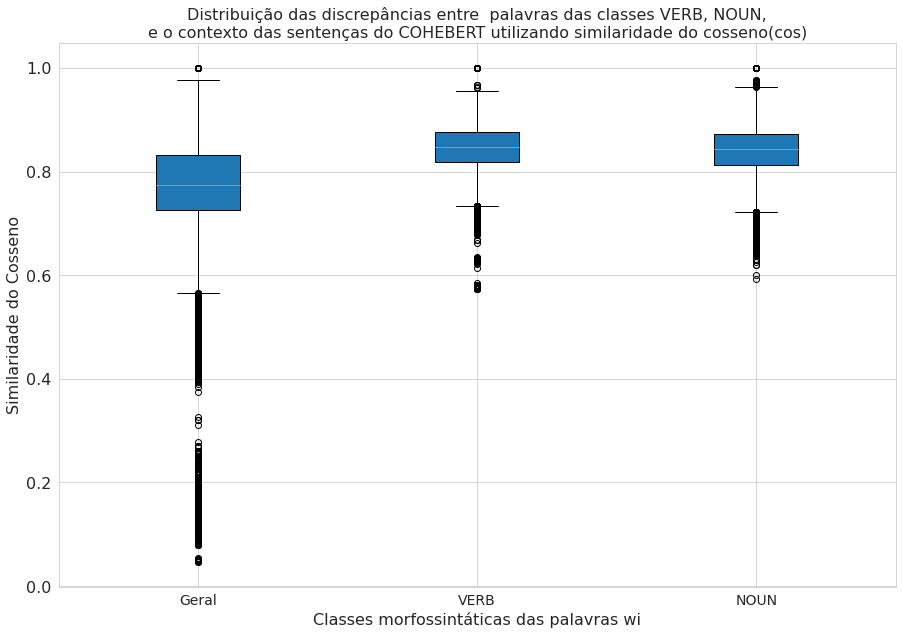

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre  palavras das classes VERB, NOUN,\ne o contexto das sentenças do COHEBERT utilizando similaridade do cosseno(cos)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Similaridade do Cosseno")

colunas = [lista_comparacao_contexto[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["cos_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["cos_ctxverbnoun_mean"]].dropna()]

ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

##### EUC

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      euc_ctxverbnoun_mean euc_ctxverbnoun_mean euc_ctxverbnoun_mean
count        203903.000000         20191.000000         47221.000000
mean             24.771677            22.240978            20.882385
std               4.768270             4.932912             3.485698
min               0.000000             0.000000             0.000000
25%              21.818462            19.990830            18.789530
50%              24.943878            22.333448            20.833269
75%              27.581625            24.858289            22.865572
max              51.320911            42.891533            39.103588

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


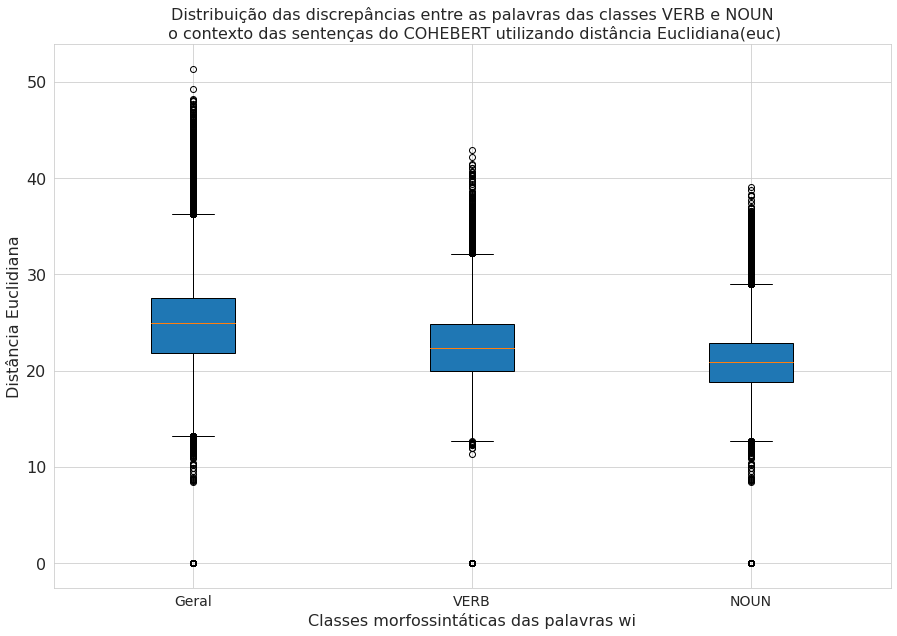

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n o contexto das sentenças do COHEBERT utilizando distância Euclidiana(euc)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância Euclidiana")

colunas = [lista_comparacao_contexto[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["euc_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["euc_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3 ], ["Geral", "VERB", "NOUN"])

plt.show()

##### MAN

In [ ]:
df_all = pd.concat([lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(),
                    lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
                    lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna(),                    
                    ], 
                    axis="columns", 
                    keys=["Geral", "VERB", "NOUN"])

df_all.describe(include=["float", "int"]) 

Geral                 VERB                 NOUN
      man_ctxverbnoun_mean man_ctxverbnoun_mean man_ctxverbnoun_mean
count        203903.000000         20191.000000         47221.000000
mean           1189.817711          1057.391125           987.474733
std             228.556697           227.301268           160.545961
min               0.000000             0.000000             0.000000
25%            1042.043457           954.668671           891.371521
50%            1205.260498          1066.966553           985.554443
75%            1334.114868          1183.598816          1080.979492
max            2233.275146          2030.208618          1761.926758

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


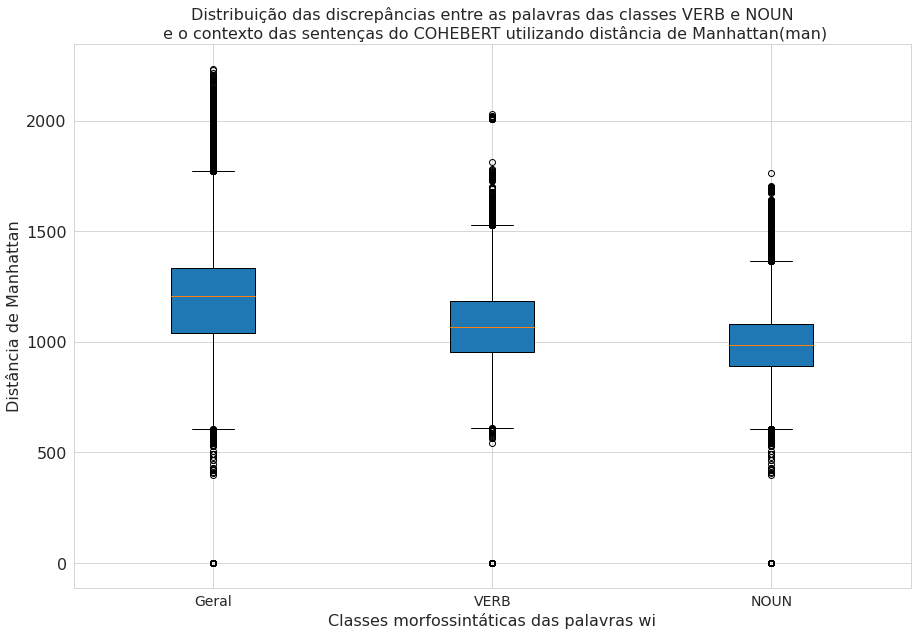

In [ ]:
# Import das bibliotecas.
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define o tamanho do gráfico 
fig, ax = plt.subplots(figsize =(15, 10))

# Estilo do gráfico
sns.set_style("whitegrid")

# Título do Gráfico
plt.title("Distribuição das discrepâncias entre as palavras das classes VERB e NOUN\n e o contexto das sentenças do COHEBERT utilizando distância de Manhattan(man)")
# Texto do eixo x
plt.xlabel("Classes morfossintáticas das palavras wi")
# Texto do eixo y
plt.ylabel("Distância de Manhattan")

colunas = [lista_comparacao_contexto[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesVV[["man_ctxverbnoun_mean"]].dropna(), 
           lista_comparacao_classesNN[["man_ctxverbnoun_mean"]].dropna()]
ax.boxplot(colunas, patch_artist=True)

# Rótulos para os boxplots
plt.xticks([1, 2, 3], ["Geral", "VERB", "NOUN"])

plt.show()

## 3.6 Ocorrências palavras e contexto

### Indexa os dados das comparações pelo id do documento

In [ ]:
# Expecifica o(s) campo(s) indexado(s) e faz uma cópia da lista indexada
lista_comparacao_contexto_indexado = lista_comparacao_contexto.set_index(["id"])
lista_comparacao_contexto_indexado.head()

index_documento  index_sentenca  index_wi          wi  pos_i  \
id                                                                 
1                 0               0         0        Como  SCONJ   
1                 0               0         1  enfileirar   VERB   
1                 0               0         2   elementos   NOUN   
1                 0               0         3          em    ADP   
1                 0               0         4         uma    DET   

    cos_ctxall_mean  euc_ctxall_mean  man_ctxall_mean  cos_ctxclean_mean  \
id                                                                         
1          0.828282        21.519108      1075.545000           0.795338   
1          0.957184        10.615781       524.864750           0.923698   
1          0.803867        26.599089      1214.868700           0.868563   
1          0.871055        20.539904       985.528140           0.828741   
1          0.840564        20.068254       958.674800           0.787430   

    euc_ctxclean_mean  ...  man_ctxclean_max  cos_ctxverb_max  \
id                     ...                                      
1           23.453634  ...       1157.058100         0.759586   
1           13.929335  ...       1131.780200         0.888775   
1           22.597618  ...       1028.900600         0.740469   
1           23.203224  ...       1111.173300         0.796027   
1           23.178740  ...       1096.644800         0.744569   

    euc_ctxverb_max  man_ctxverb_max  cos_ctxnoun_max  euc_ctxnoun_max  \
id                                                                       
1         25.941952      1294.481201         0.680192        29.916761   
1         18.006964       972.863525         0.740781        27.314678   
1         30.121441      1415.033325         0.927326        17.372261   
1         25.312115      1248.880127         0.801384        24.997398   
1         26.130171      1257.120117         0.727427        27.010202   

    man_ctxnoun_max  cos_ctxverbnoun_max  euc_ctxverbnoun_max  \
id                                                              
1       1453.618900             0.733323            26.951654   
1       1333.597400             0.819909            22.602350   
1        782.108460             0.897772            20.224216   
1       1188.405400             0.829802            23.141649   
1       1257.071300             0.760827            24.886763   

    man_ctxverbnoun_max  
id                       
1           1323.588700  
1           1117.259800  
1            922.564500  
1           1105.196000  
1           1168.039700  

[5 rows x 35 columns]

### 3.6.1 Similaridade coseno

#### 3.6.1.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'cos' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida cos_ctxall_mean  :  0.8090358675212904


#### 3.6.1.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações 
    if len(linha1[1]) != 0:

      # Percorre as comparações 
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.1.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida cos ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 elementos(NOUN)  24
4 em(ADP)  24
5 fila(NOUN)  20
6 pilha(NOUN)  20
7 e(CCONJ)  19
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.2 Distância Euclidiana

#### 3.6.2.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'euc' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida euc_ctxall_mean  :  22.545366594868323


#### 3.6.2.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.2.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida euc ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


### 3.6.3 Distância de Manhattan

#### 3.6.3.1 Organiza as comparações das palavras antes e depois da palavra chave

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Medida
# Para usar outras medidas altere aqui
medida = 'man' # medidas = {cos, euc, man}

# Estratégia medida
estrategia_medida = 'mean' # medidas = {mean, max}

# Equação medida
equacao_medida = "ctxall" # equação medida = {ctxall, ctxclean, ctxverb, ctxnoun, ctxverbnoun}

# Coluna da medida
coluna_equacao = medida + "_" + equacao_medida + "_" + estrategia_medida

# Constrói uma lista com as palavras próximas
lista_proximidade = []

# conta comparações
conta = 0

soma_medida = 0

# Barra de progresso dos documentos
lista_documentos_agrupados_bar = tqdm_notebook(lista_documentos_agrupados.iterrows(), desc=f"Documentos", unit=f" documento", total=len(lista_documentos_agrupados))

# Percorre os documentos
for i, linha1 in lista_documentos_agrupados_bar:  

  # if i < 5:

    # Lista para as comparações
    lista_proximidade_documento = []

    # Localiza as comparações do documento
    lista_comp = lista_comparacao_contexto_indexado.loc[linha1['id']]
    
    # Percorre as comparações do documento
    for i, linha in lista_comp.iterrows():
      
          # Conta o número de comparações
          conta = conta + 1
            
          # Acumula medida
          soma_medida = soma_medida +  linha[coluna_equacao]

          # Guarda os dados da comparação          
          lista_proximidade_documento.append([linha['wi'],          # 0
                                                    linha['pos_i'],       # 1
                                                    linha[coluna_equacao],# 2
                                                    ])
    
    # Guarda as comparações do documento
    lista_proximidade.append([linha1['id'], lista_proximidade_documento])

print("Número de comparações :", conta)
media = soma_medida / conta
print("Média medida", coluna_equacao, " : ", media)

Documentos:   0%|          | 0/40 [00:00<?, ? documento/s]

Número de comparações : 434
Média medida man_ctxall_mean  :  1079.1845001382487


#### 3.6.3.2 Seleciona comparações entre palavras onde a similaridade do coseno é maior que um determinado threshold

In [ ]:
# Import das bibliotecas.
from tqdm.notebook import tqdm as tqdm_notebook

# Limite da medida
threshold = 0.5

# Dicionário para guardar as ocorrências de comparações
frequencia_ocorrencia_palavra = {}

# Barra de progresso das proximidades
lista_proximidade_bar = tqdm_notebook(enumerate(lista_proximidade), desc=f"Comparações", unit=f" comparação", total=len(lista_proximidade))

# Percorre a lista de comparações com a chave
for i, linha1 in lista_proximidade_bar:
  # if i < 5:

    # Verifica se existe comparações
    if len(linha1[1]) != 0:

      # Percorre as comparações
      for j, linha2 in enumerate(linha1[1]):
          
        # Compara a medida se está acima do Threshold
        if linha2[2] >= threshold:

            # Monta a chave do dicionário
            chave = linha2[0] + "(" + linha2[1] + ") "

            # Recupera a chave para atualizar o valor
            if chave in frequencia_ocorrencia_palavra:
              valor = frequencia_ocorrencia_palavra.get(chave)
              frequencia_ocorrencia_palavra.update({chave: valor + 1})
            
            else:
              # Atualiza a chave com valor 1 se não existir
              frequencia_ocorrencia_palavra.update({chave: 1})

Comparações:   0%|          | 0/40 [00:00<?, ? comparação/s]

#### 3.6.3.3 Lista as 20 maiores ocorrências de palavras com similaridade acima do threshold com o contexto

In [ ]:
top = 20

print("Lista ordenada das ", top, " maiores ocorrências ordenadas de palavras comparadas com o contexto")
print("usando medida", medida ,",estratégia", estrategia_medida, "e equação", equacao_medida,"acima do threshold com o contexto")

# Lista as ocorrências das palavras
for i, item in enumerate(sorted(frequencia_ocorrencia_palavra, key = frequencia_ocorrencia_palavra.get, reverse=True)):
  if i < top:
    print (i+1, item, frequencia_ocorrencia_palavra[item])

Lista ordenada das  20  maiores ocorrências ordenadas de palavras comparadas com o contexto
usando medida man ,estratégia mean e equação ctxall acima do threshold com o contexto
1 uma(DET)  40
2 ?(PUNCT)  40
3 e(CCONJ)  28
4 elementos(NOUN)  24
5 em(ADP)  24
6 fila(NOUN)  20
7 pilha(NOUN)  20
8 empilhar(VERB)  18
9 O(PRON)  16
10 que(PRON)  16
11 é(AUX)  16
12 como(ADV)  14
13 Como(SCONJ)  12
14 enfileirar(VERB)  12
15 elemento(NOUN)  12
16 desempilhar(NOUN)  8
17 um(DET)  8
18 nela(PRON)  8
19 de(SCONJ)  8
20 desempilhar(VERB)  6


# 4 Finalização

## 4.1 Tempo final de processamento



In [ ]:
# Pega o tempo atual menos o tempo do início do processamento.
final_processamento = time.time()
tempo_total_processamento = formataTempo(final_processamento - inicio_processamento)

print("")
print("  Tempo processamento:  {:} (h:mm:ss)".format(tempo_total_processamento))


  Tempo processamento:  0:08:22 (h:mm:ss)
